In [5]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint, loguniform

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBClassifier, DMatrix, XGBRegressor
from category_encoders import TargetEncoder

import sys
print(sys.executable)

/usr/bin/python3


In [7]:
## Only use this for Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/MyDrive/oldAIboy/houseprice')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/oldAIboy/houseprice'

In [8]:
traindata = pd.read_csv("data/train.csv")
print("Full train dataset shape is {}".format(traindata.shape))
testdata = pd.read_csv("data/test.csv")
print("Full test dataset shape is {}".format(testdata.shape))

Full train dataset shape is (1460, 81)
Full test dataset shape is (1459, 80)


###### note: possible further FE tests: 1. bucket numberical feats (df[num_feat].apply(cat_func)); 2.normalize num feats; 3. try other models (regression, KNN)


### EDA - understand the data

##### EDA notes:
###### data distribution: found many relevant features such as SquareFeet/area,room counts,bathrms, garage, porch area etc. may be useful to create more powerful features by combining them
###### Features with high NA: some cat predictors have high NA% (PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu), some num features also have high NA% (LotFrontage), need to review the feature importance.
###### NA findings: garage features and bsmt features show the same NA%, may indicating the subjects are just NOT AVAILABLE. Should treat as 'None' /a separate class (tree ensemble can easily take advantage)
###### Many cat features have very few unique values (CentralAir, Street, Alley, Utilities etc.), some num features also have low nunique (HalfBath,BsmtHalfBath,BsmtFullBath), could conduct a process of feature selection to decide if they should be used for model training.

#### EDA 1: Data initial view - data overview, NA values, value variation // traindata, testdata

In [ ]:
## check train df info
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
## check test df info
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [ ]:
##check numerical features's distribution for traindata
traindata.describe().T

count           mean           std      min        25%  \
Id             1460.0     730.500000    421.610009      1.0     365.75   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageYrBlt    1379.0    1978.506164     24.689725   1900.0    1961.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
MoSold         1460.0       6.321918      2.703626      1.0       5.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                    50%        75%       max  
Id                730.5    1095.25    1460.0  
MSSubClass         50.0      70.00     190.0  
LotFrontage        69.0      80.00     313.0  
LotArea          9478.5   11601.50  215245.0  
OverallQual         6.0       7.00      10.0  
OverallCond         5.0       6.00       9.0  
YearBuilt        1973.0    2000.00    2010.0  
YearRemodAdd     1994.0    2004.00    2010.0  
MasVnrArea          0.0     166.00    1600.0  
BsmtFinSF1        383.5     712.25    5644.0  
BsmtFinSF2          0.0       0.00    1474.0  
BsmtUnfSF         477.5     808.00    2336.0  
TotalBsmtSF       991.5    1298.25    6110.0  
1stFlrSF         1087.0    1391.25    4692.0  
2ndFlrSF            0.0     728.00    2065.0  
LowQualFinSF        0.0       0.00     572.0  
GrLivArea        1464.0    1776.75    5642.0  
BsmtFullBath        0.0       1.00       3.0  
BsmtHalfBath        0.0       0.00       2.0  
FullBath            2.0       2.00       3.0  
HalfBath            0.0       1.00       2.0  
BedroomAbvGr        3.0       3.00       8.0  
KitchenAbvGr        1.0       1.00       3.0  
T

In [ ]:
##check numerical features's distribution for testdata
testdata.describe().T

count         mean          std     min      25%     50%  \
Id             1459.0  2190.000000   421.321334  1461.0  1825.50  2190.0   
MSSubClass     1459.0    57.378341    42.746880    20.0    20.00    50.0   
LotFrontage    1232.0    68.580357    22.376841    21.0    58.00    67.0   
LotArea        1459.0  9819.161069  4955.517327  1470.0  7391.00  9399.0   
OverallQual    1459.0     6.078821     1.436812     1.0     5.00     6.0   
OverallCond    1459.0     5.553804     1.113740     1.0     5.00     5.0   
YearBuilt      1459.0  1971.357779    30.390071  1879.0  1953.00  1973.0   
YearRemodAdd   1459.0  1983.662783    21.130467  1950.0  1963.00  1992.0   
MasVnrArea     1444.0   100.709141   177.625900     0.0     0.00     0.0   
BsmtFinSF1     1458.0   439.203704   455.268042     0.0     0.00   350.5   
BsmtFinSF2     1458.0    52.619342   176.753926     0.0     0.00     0.0   
BsmtUnfSF      1458.0   554.294925   437.260486     0.0   219.25   460.0   
TotalBsmtSF    1458.0  1046.117970   442.898624     0.0   784.00   988.0   
1stFlrSF       1459.0  1156.534613   398.165820   407.0   873.50  1079.0   
2ndFlrSF       1459.0   325.967786   420.610226     0.0     0.00     0.0   
LowQualFinSF   1459.0     3.543523    44.043251     0.0     0.00     0.0   
GrLivArea      1459.0  1486.045922   485.566099   407.0  1117.50  1432.0   
BsmtFullBath   1457.0     0.434454     0.530648     0.0     0.00     0.0   
BsmtHalfBath   1457.0     0.065202     0.252468     0.0     0.00     0.0   
FullBath       1459.0     1.570939     0.555190     0.0     1.00     2.0   
HalfBath       1459.0     0.377656     0.503017     0.0     0.00     0.0   
BedroomAbvGr   1459.0     2.854010     0.829788     0.0     2.00     3.0   
KitchenAbvGr   1459.0     1.042495     0.208472     0.0     1.00     1.0   
TotRmsAbvGrd   1459.0     6.385195     1.508895     3.0     5.00     6.0   
Fireplaces     1459.0     0.581220     0.647420     0.0     0.00     0.0   
GarageYrBlt    1381.0  1977.721217    26.431175  1895.0  1959.00  1979.0   
GarageCars     1458.0     1.766118     0.775945     0.0     1.00     2.0   
GarageArea     1458.0   472.768861   217.048611     0.0   318.00   480.0   
WoodDeckSF     1459.0    93.174777   127.744882     0.0     0.00     0.0   
OpenPorchSF    1459.0    48.313914    68.883364     0.0     0.00    28.0   
EnclosedPorch  1459.0    24.243317    67.227765     0.0     0.00     0.0   
3SsnPorch      1459.0     1.794380    20.207842     0.0     0.00     0.0   
ScreenPorch    1459.0    17.064428    56.609763     0.0     0.00     0.0   
PoolArea       1459.0     1.744345    30.491646     0.0     0.00     0.0   
MiscVal        1459.0    58.167923   630.806978     0.0     0.00     0.0   
MoSold         1459.0     6.104181     2.722432     1.0     4.00     6.0   
YrSold         1459.0  2007.769705     1.301740  2006.0  2007.00  2008.0   

                    75%      max  
Id              2554.50   2919.0  
MSSubClass        70.00    190.0  
LotFrontage       80.00    200.0  
LotArea        11517.50  56600.0  
OverallQual        7.00     10.0  
OverallCond        6.00      9.0  
YearBuilt       2001.00   2010.0  
YearRemodAdd    2004.00   2010.0  
MasVnrArea       164.00   1290.0  
BsmtFinSF1       753.50   4010.0  
BsmtFinSF2         0.00   1526.0  
BsmtUnfSF        797.75   2140.0  
TotalBsmtSF     1305.00   5095.0  
1stFlrSF        1382.50   5095.0  
2ndFlrSF         676.00   1862.0  
LowQualFinSF       0.00   1064.0  
GrLivArea       1721.00   5095.0  
BsmtFullBath       1.00      3.0  
BsmtHalfBath       0.00      2.0  
FullBath           2.00      4.0  
HalfBath           1.00      2.0  
BedroomAbvGr       3.00      6.0  
KitchenAbvGr       1.00      2.0  
TotRmsAbvGrd       7.00     15.0  
Fireplaces         1.00      4.0  
GarageYrBlt     2002.00   2207.0  
GarageCars         2.00      5.0  
GarageArea       576.00   1488.0  
WoodDeckSF       168.00   1424.0  
OpenPorchSF       72.00    742.0  
EnclosedPorch      0.00   1012.0  
3SsnPor

In [ ]:
###check available data types - 43 categorical and 38 numerical
traindata.dtypes.value_counts()

object     43
int64      35
float64     3
Name: count, dtype: int64

In [ ]:
## 43 categorical features
print(f'number of cat featurs: {traindata.select_dtypes(include=['object']).columns.shape}')
traindata.select_dtypes(include=['object']).columns

number of cat featurs: (43,)


Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [ ]:
## 37 categorical features ('Id' is not a feature)
print(f'number of numerical featurs: {traindata.select_dtypes(exclude=['object']).columns.shape}')
traindata.select_dtypes(exclude=['object']).columns

number of numerical featurs: (38,)


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [ ]:
### check features' NA% and nunique
# # note: many features have high NA% and low nunique - need to check if they are useful
colsinfotrain = pd.DataFrame(traindata.dtypes, columns=['dtype'])
colsinfotrain['NAcnt'] = traindata.isnull().sum()
colsinfotrain['NA%'] = colsinfotrain['NAcnt']/traindata.shape[0]
colsinfotrain['nunique'] = traindata.nunique()
colsinfotrain.sort_values(by=['NA%','nunique'], ascending=False, inplace=True)
colsinfotrain.head(15)

dtype  NAcnt       NA%  nunique
PoolQC         object   1453  0.995205        3
MiscFeature    object   1406  0.963014        4
Alley          object   1369  0.937671        2
Fence          object   1179  0.807534        4
MasVnrType     object    872  0.597260        3
FireplaceQu    object    690  0.472603        5
LotFrontage   float64    259  0.177397      110
GarageYrBlt   float64     81  0.055479       97
GarageType     object     81  0.055479        6
GarageQual     object     81  0.055479        5
GarageCond     object     81  0.055479        5
GarageFinish   object     81  0.055479        3
BsmtFinType2   object     38  0.026027        6
BsmtExposure   object     38  0.026027        4
BsmtFinType1   object     37  0.025342        6

In [ ]:
## check features with high NA% NA findings: garage features and bsmt features show the same or similar NA rate, may indicating garage/basement are just NOT AVAILABLE for those properties!
## If this is true, it would be good to separate them as a 'None' class, since this info may be a strong signal of lower house price, easier for tree ensemble models to learn
colsinfotrain.iloc[:30]

dtype  NAcnt       NA%  nunique
PoolQC         object   1453  0.995205        3
MiscFeature    object   1406  0.963014        4
Alley          object   1369  0.937671        2
Fence          object   1179  0.807534        4
MasVnrType     object    872  0.597260        3
FireplaceQu    object    690  0.472603        5
LotFrontage   float64    259  0.177397      110
GarageYrBlt   float64     81  0.055479       97
GarageType     object     81  0.055479        6
GarageQual     object     81  0.055479        5
GarageCond     object     81  0.055479        5
GarageFinish   object     81  0.055479        3
BsmtFinType2   object     38  0.026027        6
BsmtExposure   object     38  0.026027        4
BsmtFinType1   object     37  0.025342        6
BsmtQual       object     37  0.025342        4
BsmtCond       object     37  0.025342        4
MasVnrArea    float64      8  0.005479      327
Electrical     object      1  0.000685        5
Id              int64      0  0.000000     1460
LotArea         int64      0  0.000000     1073
GrLivArea       int64      0  0.000000      861
BsmtUnfSF       int64      0  0.000000      780
1stFlrSF        int64      0  0.000000      753
TotalBsmtSF     int64      0  0.000000      721
SalePrice       int64      0  0.000000      663
BsmtFinSF1      int64      0  0.000000      637
GarageArea      int64      0  0.000000      441
2ndFlrSF        int64      0  0.000000      417
WoodDeckSF      int64      0  0.000000      274

In [ ]:
##some features (especially categorical features) have low nunique - need to evaluate their importance (using boxplot)
colsinfotrain.sort_values(by='nunique').iloc[:30]

dtype  NAcnt       NA%  nunique
CentralAir    object      0  0.000000        2
Street        object      0  0.000000        2
Alley         object   1369  0.937671        2
Utilities     object      0  0.000000        2
PavedDrive    object      0  0.000000        3
HalfBath       int64      0  0.000000        3
BsmtHalfBath   int64      0  0.000000        3
LandSlope     object      0  0.000000        3
GarageFinish  object     81  0.055479        3
PoolQC        object   1453  0.995205        3
MasVnrType    object    872  0.597260        3
LandContour   object      0  0.000000        4
ExterQual     object      0  0.000000        4
BsmtExposure  object     38  0.026027        4
BsmtFullBath   int64      0  0.000000        4
BsmtQual      object     37  0.025342        4
BsmtCond      object     37  0.025342        4
MiscFeature   object   1406  0.963014        4
FullBath       int64      0  0.000000        4
Fence         object   1179  0.807534        4
LotShape      object      0  0.000000        4
KitchenAbvGr   int64      0  0.000000        4
Fireplaces     int64      0  0.000000        4
KitchenQual   object      0  0.000000        4
GarageCond    object     81  0.055479        5
BldgType      object      0  0.000000        5
LotConfig     object      0  0.000000        5
MSZoning      object      0  0.000000        5
GarageQual    object     81  0.055479        5
ExterCond     object      0  0.000000        5

In [ ]:
### investigate testdata's column infos (dtype, NAcnt etc, nunique)
colsinfotest = pd.DataFrame(testdata.dtypes, columns=['dtype'])
colsinfotest['NAcnt'] = testdata.isnull().sum()
colsinfotest['NA%'] = colsinfotest['NAcnt']/testdata.shape[0]
colsinfotest['nunique'] = testdata.nunique()
colsinfotest.sort_values(by=['NA%','nunique'], ascending=False, inplace=True)
colsinfotest

dtype  NAcnt       NA%  nunique
PoolQC        object   1456  0.997944        2
MiscFeature   object   1408  0.965045        3
Alley         object   1352  0.926662        2
Fence         object   1169  0.801234        4
MasVnrType    object    894  0.612748        3
...              ...    ...       ...      ...
HalfBath       int64      0  0.000000        3
KitchenAbvGr   int64      0  0.000000        3
PavedDrive    object      0  0.000000        3
Street        object      0  0.000000        2
CentralAir    object      0  0.000000        2

[80 rows x 4 columns]

In [ ]:
##check features' low variation
colsinfotest.sort_values(by='nunique').iloc[:30]

dtype  NAcnt       NA%  nunique
Utilities      object      2  0.001371        1
PoolQC         object   1456  0.997944        2
Street         object      0  0.000000        2
CentralAir     object      0  0.000000        2
Alley          object   1352  0.926662        2
MasVnrType     object    894  0.612748        3
PavedDrive     object      0  0.000000        3
MiscFeature    object   1408  0.965045        3
GarageFinish   object     78  0.053461        3
LandSlope      object      0  0.000000        3
HalfBath        int64      0  0.000000        3
KitchenAbvGr    int64      0  0.000000        3
BsmtHalfBath  float64      2  0.001371        3
Fence          object   1169  0.801234        4
LotShape       object      0  0.000000        4
LandContour    object      0  0.000000        4
KitchenQual    object      1  0.000685        4
ExterQual      object      0  0.000000        4
Heating        object      0  0.000000        4
Electrical     object      0  0.000000        4
RoofMatl       object      0  0.000000        4
BsmtFullBath  float64      2  0.001371        4
BsmtExposure   object     44  0.030158        4
BsmtQual       object     44  0.030158        4
BsmtCond       object     45  0.030843        4
GarageQual     object     78  0.053461        4
ExterCond      object      0  0.000000        5
FireplaceQu    object    730  0.500343        5
HeatingQC      object      0  0.000000        5
FullBath        int64      0  0.000000        5

#### Reorg the data to prepare next steps' data EDA and modeling // traindata->X_train_combo, ylog; testdata -> X_test

In [9]:
##separate X and y: create X_train_combo and ylog
## X_train_combo will be split into X_train and X_val later
X_train_combo = traindata.drop('SalePrice', axis=1)
## apply log to target to better evaluate the model
ylog = np.log(traindata['SalePrice'])

## set up the dataset for final submission
X_test = testdata.copy(deep=True) ##create a data copy

In [10]:
print(f'Check if traindata and testdata columns are the same, the result is: {X_train_combo.columns.equals(X_test.columns)}')

Check if traindata and testdata columns are the same, the result is: True


In [6]:
X_train_combo.set_index('Id',inplace=True)
X_test.set_index('Id',inplace=True)

print(X_train_combo.shape)
print(X_test.shape)

(1460, 79)
(1459, 79)


#### EDA 2: Visualize data - obtain deeper understanding of the data (potential values of each features, correlation among features etc.)

In [ ]:
#### separate numerical and categorical features
num_features = X_train_combo.select_dtypes(include=[np.number])
cat_features = X_train_combo.select_dtypes(include=['object', 'category'])
print(f'num_features shape are {num_features.shape}')
print(f'cat_features shape are {cat_features.shape}')

num_features shape are (1460, 36)
cat_features shape are (1460, 43)


##### scatter plot upon numerical features
###### Some features seem to have strong correlation with sales price: OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd, GarageArea
###### A lot of features are correlated such as SF/Area features and room count features. Maybe a good idea to combine them to shape new features.
###### some year related features such as 'YearBuilt' and 'YearRemodAdd' could be transformed into a recency index.

In [ ]:
feature_importances_df.iloc[-20:]

Feature  Importance
59  EnclosedPorch    0.001369
26      ExterCond    0.001352
65         YrSold    0.001336
35      HeatingQC    0.001336
37     Electrical    0.001145
32   BsmtFinType2    0.001106
14     HouseStyle    0.000991
2     LotFrontage    0.000961
8       LotConfig    0.000931
5        LotShape    0.000835
23     MasVnrType    0.000708
27     Foundation    0.000706
62       PoolArea    0.000705
0      MSSubClass    0.000650
7       Utilities    0.000617
34        Heating    0.000498
63        MiscVal    0.000000
20       RoofMatl    0.000000
12     Condition2    0.000000
4          Street    0.000000

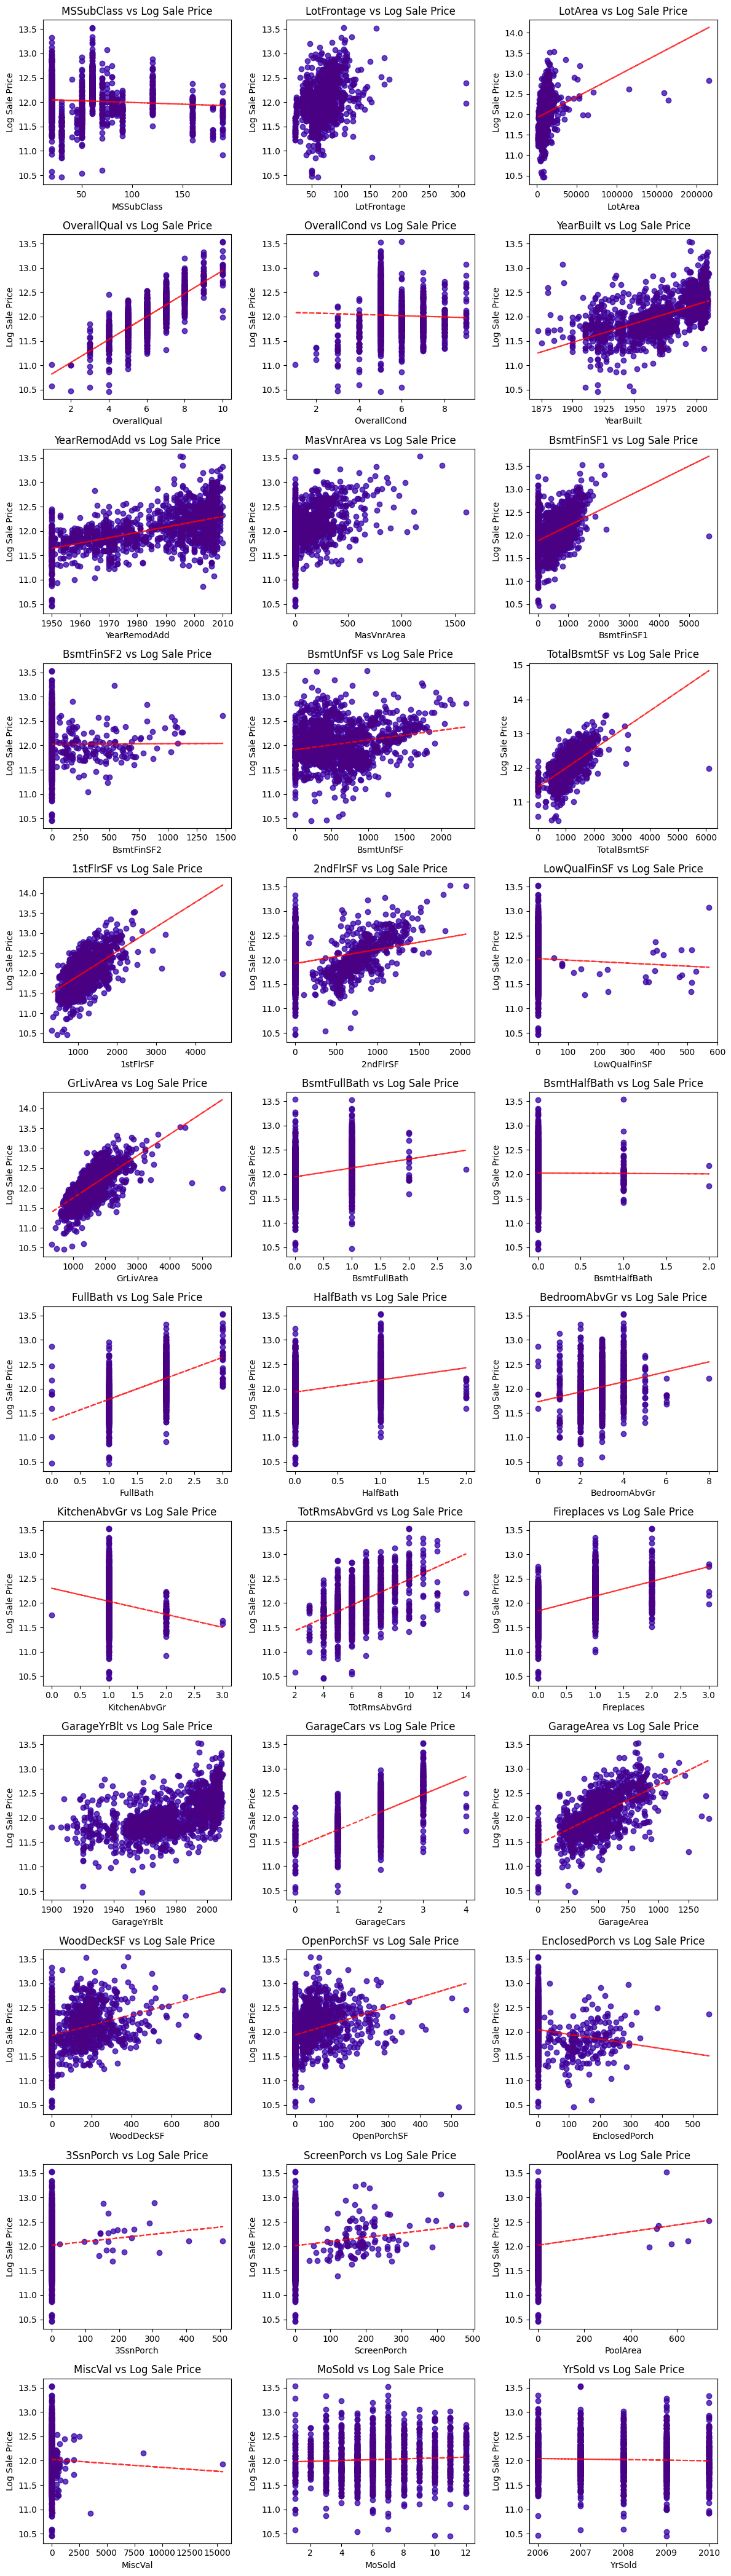

In [ ]:
# Create a figure with subplots for each numerical feature
n_features = len(num_features.columns)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

plt.figure(figsize=(12, 3.5*n_rows))

for idx, col in enumerate(num_features.columns):
    plt.subplot(n_rows, n_cols, idx + 1)

    # Get non-null values only
    # mask = ~num_features[col].isna()
    x = num_features.loc[:, col]
    y = ylog

    # Create scatter plot
    plt.scatter(x, y, alpha=0.5, color='blue')
    # Create scatter plot with a modern color scheme
    plt.scatter(x, y, alpha=0.5, color='#4B0082')  # Deep indigo color that's trendy but still professional
    try:
        # Add regression line using numpy's polyfit
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x), "r--", alpha=0.8)
    except:
        # If regression fails, just skip the line
        pass

    plt.xlabel(col)
    plt.ylabel('Log Sale Price')
    plt.title(f'{col} vs Log Sale Price')

plt.tight_layout()
plt.show()

##### boxplot on cat features
###### found potential strong cat features: GarageQual, GarageCond, SaleType, neighborhood (PoolQC- high NA)
###### majority cat features are week predictors, should test whether just throw away?


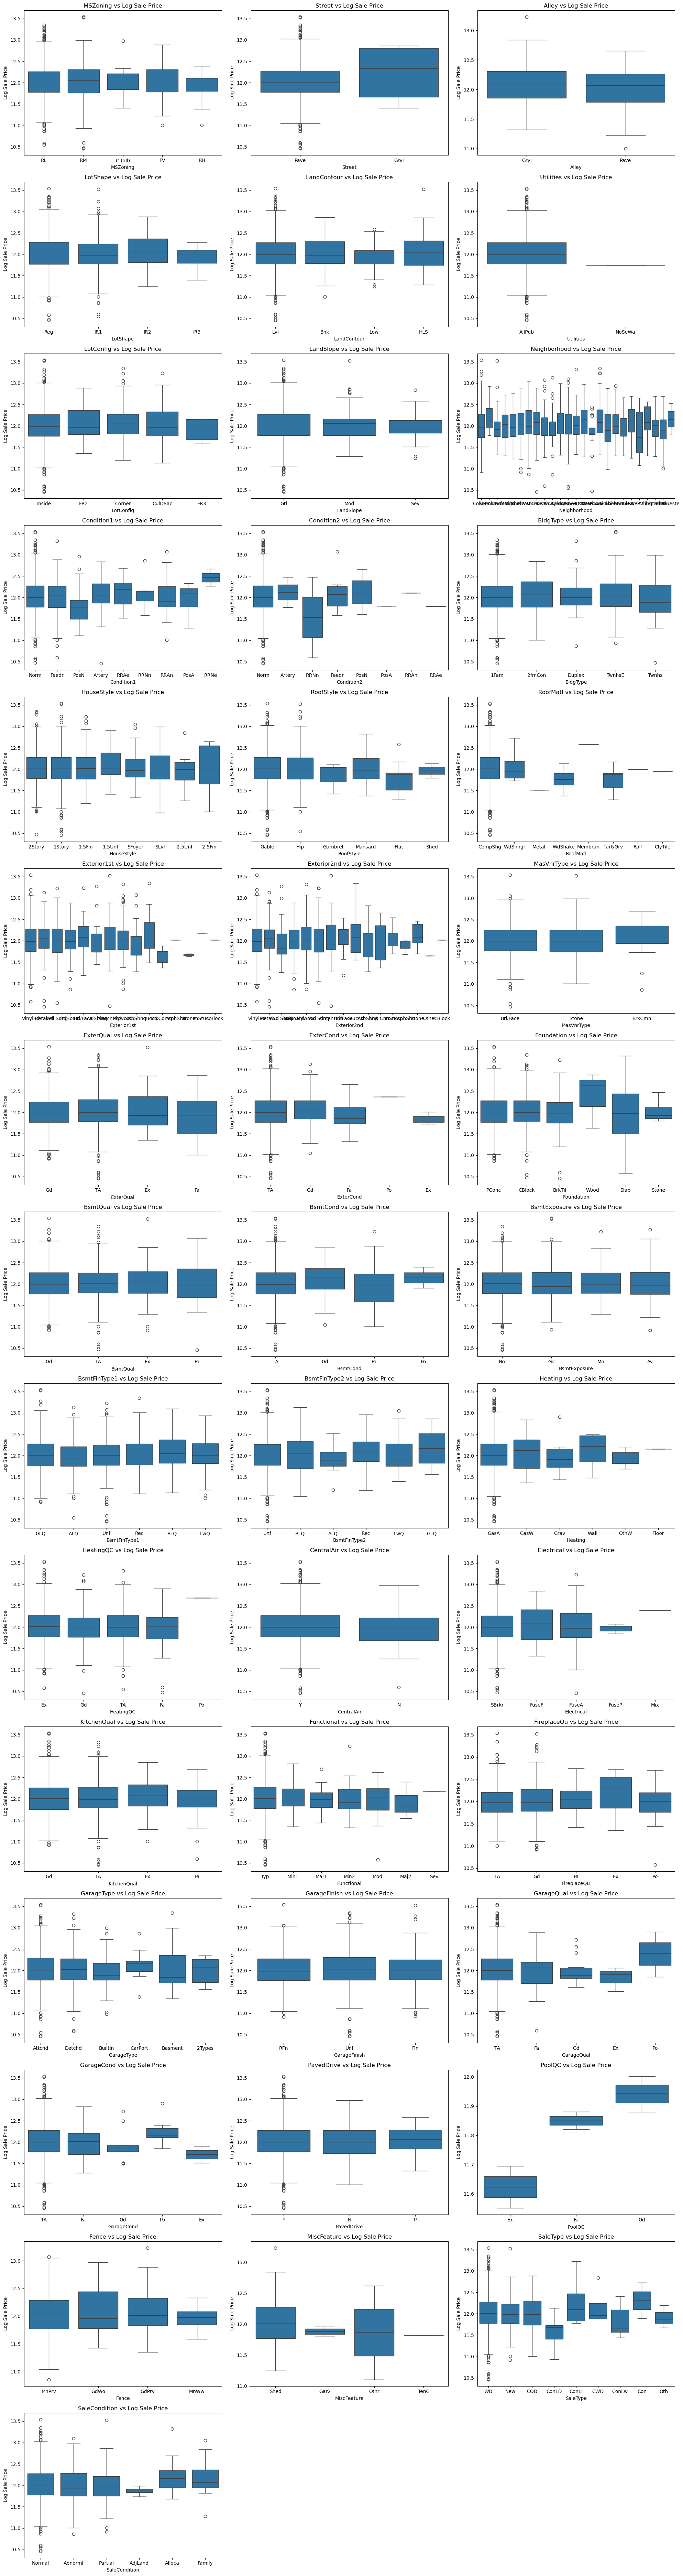

In [ ]:
# Create a figure with subplots for each numerical feature
n_features = len(cat_features.columns)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

plt.figure(figsize=(20, 5*n_rows))

for idx, col in enumerate(cat_features.columns):
    plt.subplot(n_rows, n_cols, idx + 1)

    # Get non-null values only
    # mask = ~num_features[col].isna()
    # x = num_features.loc[mask, col]
    # y = ylog[mask]
    x = cat_features.loc[:, col]
    y = ylog
    dfset = pd.DataFrame({'categorical_feature': x, 'target': y})
    # Create scatter plot
    sns.boxplot(x='categorical_feature', y='target', data=dfset)
    # Create scatter plot with a modern color scheme
    #plt.scatter(x, y, alpha=0.5, color='#4B0082')  # Deep indigo color that's trendy but still professional
    plt.xlabel(col)
    plt.ylabel('Log Sale Price')
    plt.title(f'{col} vs Log Sale Price')

plt.tight_layout()
plt.show()

##### use anova analysis to double check the importance of cat features

### Feature preprocessing  
###### handle NA treatment for both categorical and numerical features; categorical feature treatment: onehot vs. dummy vs. ordinal??, np.log on skewed features?

##### Analyze NA values // X_train_combo


In [ ]:
## Drop 4 features with hgih NA% (PoolQC,MiscFeature,Alley,Fence), they don't show promising views on boxplot analysis
## X_train_combo.drop(['PoolQC','MiscFeature','Alley','Fence'], axis=1, inplace=True)

In [ ]:
## collect column list for na values imputation
catna_cols=colsinfotrain.loc[(colsinfotrain.NAcnt>0) & (colsinfotrain.dtype=='object')].index.tolist()
numna_cols=colsinfotrain.loc[(colsinfotrain.NAcnt>0) & ~(colsinfotrain.dtype=='object')].index.tolist()

In [ ]:
print(catna_cols)
print(numna_cols)

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'GarageType', 'GarageQual', 'GarageCond', 'GarageFinish', 'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond', 'Electrical']
['LotFrontage', 'GarageYrBlt', 'MasVnrArea']


###### look into 'MasVnrType', NA value is because there is 0 MasVnrArea. Should set 'None' where MasVnrArea is 0

In [ ]:
X_train_combo[['MasVnrType','MasVnrArea']]

MasVnrType  MasVnrArea
Id                         
1       BrkFace       196.0
2           NaN         0.0
3       BrkFace       162.0
4           NaN         0.0
5       BrkFace       350.0
...         ...         ...
1456        NaN         0.0
1457      Stone       119.0
1458        NaN         0.0
1459        NaN         0.0
1460        NaN         0.0

[1460 rows x 2 columns]

In [ ]:
X_train_combo.loc[X_train_combo.MasVnrArea==0,'MasVnrType'].unique()

array([nan, 'BrkFace', 'Stone'], dtype=object)

###### look into 'FireplaceQU', NA value is because Fireplace doesn't exist. Should fillna with 'None'

In [ ]:
X_train_combo.loc[X_train_combo.Fireplaces==0,['FireplaceQu']]

FireplaceQu
Id              
1            NaN
6            NaN
11           NaN
13           NaN
16           NaN
...          ...
1453         NaN
1454         NaN
1455         NaN
1459         NaN
1460         NaN

[690 rows x 1 columns]

In [ ]:
X_train_combo.loc[X_train_combo.Fireplaces==0,'FireplaceQu'].unique()

array([nan], dtype=object)

###### look into garage related features ('GarageType', 'GarageQual', 'GarageCond', 'GarageFinish'), NA value is because there is no garage, should set all NA as 'None'

In [ ]:
X_train_combo.loc[X_train_combo.GarageArea==0,['GarageArea','GarageCars','GarageType', 'GarageQual', 'GarageCond', 'GarageFinish']]

GarageArea  GarageCars GarageType GarageQual GarageCond GarageFinish
Id                                                                        
40             0           0        NaN        NaN        NaN          NaN
49             0           0        NaN        NaN        NaN          NaN
79             0           0        NaN        NaN        NaN          NaN
89             0           0        NaN        NaN        NaN          NaN
90             0           0        NaN        NaN        NaN          NaN
...          ...         ...        ...        ...        ...          ...
1350           0           0        NaN        NaN        NaN          NaN
1408           0           0        NaN        NaN        NaN          NaN
1450           0           0        NaN        NaN        NaN          NaN
1451           0           0        NaN        NaN        NaN          NaN
1454           0           0        NaN        NaN        NaN          NaN

[81 rows x 6 columns]

In [ ]:
X_train_combo.loc[X_train_combo.GarageArea==0,['GarageArea','GarageType', 'GarageQual', 'GarageCond', 'GarageFinish']].nunique()

GarageArea      1
GarageType      0
GarageQual      0
GarageCond      0
GarageFinish    0
dtype: int64

###### look into bsmt related features ('BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond'), NA value is because there is no basement, should set all NA as 'None'

In [ ]:
X_train_combo[['TotalBsmtSF','BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond']]

TotalBsmtSF BsmtFinType2 BsmtExposure BsmtFinType1 BsmtQual BsmtCond
Id                                                                        
1             856          Unf           No          GLQ       Gd       TA
2            1262          Unf           Gd          ALQ       Gd       TA
3             920          Unf           Mn          GLQ       Gd       TA
4             756          Unf           No          ALQ       TA       Gd
5            1145          Unf           Av          GLQ       Gd       TA
...           ...          ...          ...          ...      ...      ...
1456          953          Unf           No          Unf       Gd       TA
1457         1542          Rec           No          ALQ       Gd       TA
1458         1152          Unf           No          GLQ       TA       Gd
1459         1078          Rec           Mn          GLQ       TA       TA
1460         1256          LwQ           No          BLQ       TA       TA

[1460 rows x 6 columns]

In [ ]:
X_train_combo.loc[X_train_combo.TotalBsmtSF==0,['BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond']].nunique()

BsmtFinType2    0
BsmtExposure    0
BsmtFinType1    0
BsmtQual        0
BsmtCond        0
dtype: int64

###### look into 'Electrical' ?, There is only one NA value, can just apply mode

In [ ]:
X_train_combo.loc[X_train_combo.Electrical.isnull(),['Electrical','Utilities']]

Electrical Utilities
Id                       
1380        NaN    AllPub

In [ ]:
X_train_combo['Utilities'].unique()

array(['AllPub', 'NoSeWa'], dtype=object)

###### check 3 numercial feats with NAs ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']: 'LotFrontage' should be turned to 0?

###### numercial feats 'LotFrontage' should be imputed by median grouped by 'BldgType'

In [ ]:
X_train_combo.loc[X_train_combo.LotFrontage.isnull(),['BldgType']].value_counts()

BldgType
1Fam        226
TwnhsE       22
Duplex        5
2fmCon        3
Twnhs         3
Name: count, dtype: int64

In [ ]:
X_train_combo.loc[X_train_combo.BldgType=='TwnhsE',['LotFrontage']].describe()

LotFrontage
count    92.000000
mean     41.978261
std      11.788408
min      21.000000
25%      34.000000
50%      41.000000
75%      50.000000
max      75.000000

In [ ]:
X_train_combo.loc[X_train_combo.BldgType=='Duplex',['LotFrontage']].describe()

LotFrontage
count    47.000000
mean     71.595745
std      14.296031
min      35.000000
25%      61.500000
50%      70.000000
75%      80.500000
max     110.000000

In [ ]:
X_train_combo.loc[X_train_combo.BldgType=='1Fam',['LotFrontage']].describe()

LotFrontage
count   994.000000
mean     74.503018
std      22.514368
min      30.000000
25%      60.000000
50%      71.000000
75%      83.750000
max     313.000000

###### numercial feats 'GarageYrBlt' is because there is no garage, should be inserted with a very old year, should use 1700

In [ ]:
X_train_combo[['YearBuilt']].describe()

YearBuilt
count  1460.000000
mean   1971.267808
std      30.202904
min    1872.000000
25%    1954.000000
50%    1973.000000
75%    2000.000000
max    2010.000000

###### numercial feats 'MasVnrArea' , should be set as 0

In [ ]:
X_train_combo.loc[X_train_combo.MasVnrArea.isnull(),'MasVnrType']

Id
235     NaN
530     NaN
651     NaN
937     NaN
974     NaN
978     NaN
1244    NaN
1279    NaN
Name: MasVnrType, dtype: object

In [ ]:
X_train_combo['GarageYrBlt']

###### ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']


##### Feature preprocessing starts here: make a copy of X_train_combo as  X_mlb

In [11]:
X_mlb = X_train_combo.copy(deep=True) ##create a data copy
ylog.index=X_mlb.index

##### Feature preprocessing: treat NA values//dataset:X_mlb

In [12]:
## drop 2 categorical features with super high NA%
X_mlb.drop(['PoolQC','MiscFeature'], axis=1, inplace=True)
### fill NA for a bunch of categorical features - fill with 'None'
catna_none = ['Alley','Fence','MasVnrType', 'FireplaceQu', 'GarageType', 'GarageQual', 'GarageCond', 'GarageFinish', 'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond']
X_mlb[catna_none] = X_mlb[catna_none].fillna('None')
### fill na for cat features 'Electrical' - fill with most frequent value
most_frequent_value = X_mlb['Electrical'].mode()[0]
X_mlb['Electrical'] = X_mlb['Electrical'].fillna(most_frequent_value)
### fill NA for 2 numerical features
X_mlb['GarageYrBlt'] = X_mlb['GarageYrBlt'].fillna(1700) ##fill na of garageyrblt with 1700
X_mlb['MasVnrArea'] = X_mlb['MasVnrArea'].fillna(0) ##fill na of MasVnrArea with 0
##fill na of LotFrontage with mean
X_mlb['LotFrontage'] = X_mlb['LotFrontage'].fillna(X_mlb['LotFrontage'].mean())

### Model building & Feature Engineering

##### Model test 1 - RandomForest model & one-hot encoder (onehot generates too many features) -> rmse:0.1503

In [ ]:
# Get list of categorical columns
categorical_columns = X_mlb.select_dtypes(include=['object']).columns

# Update OneHotEncoder to use sparse_output parameter instead of sparse
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Refit and transform
onehot_encoded = onehot.fit_transform(X_mlb[categorical_columns])
onehot_feature_names = onehot.get_feature_names_out(categorical_columns)

# Convert to DataFrame and join with numeric columns
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_feature_names, index=X_mlb.index)
X_mlb_onehot = pd.concat([X_mlb.select_dtypes(exclude=['object']), onehot_df], axis=1)

# Split the data into training and validation sets with fixed validation size of 200 samples
X_train, X_valid, y_train, y_valid = train_test_split(X_mlb_onehot, ylog, test_size=200, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")


Training set shape: (1260, 293)
Validation set shape: (200, 293)


In [ ]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_valid)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Root Mean Squared Error: {rmse:.4f}')

Root Mean Squared Error: 0.1503


In [ ]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_valid)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Root Mean Squared Error: {rmse:.4f}')

Root Mean Squared Error: 0.1486


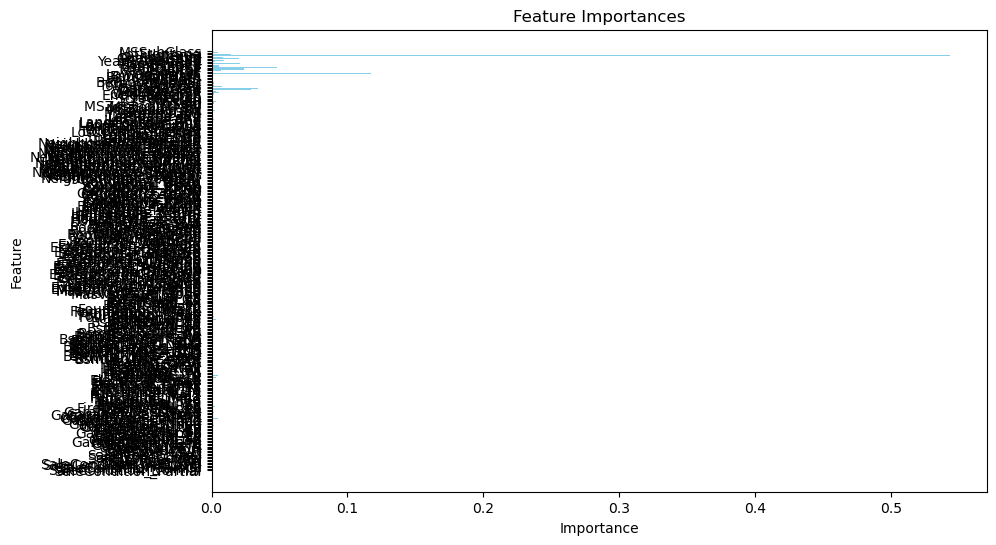

In [ ]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_mlb_onehot.columns

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

##### Feature Engineering - Use mean encoder to extract meaning out of categorical features (X_train_encoded, X_valid_encoded // ylog)

In [13]:
# Split the data into training and validation sets with fixed validation size of 200 samples
X_train, X_valid, y_train, y_valid = train_test_split(X_mlb, ylog, test_size=200, random_state=42)
from category_encoders import TargetEncoder

# Get list of categorical columns from Xcombo
catcollist = X_mlb.select_dtypes(include=['object']).columns.tolist()

# Apply mean encoding on the training set
mean_encoder = TargetEncoder(cols=catcollist)
X_train_encoded = mean_encoder.fit_transform(X_train, y_train)
# Transform the test set using the fitted mean encoder
X_valid_encoded = mean_encoder.transform(X_valid)

print("Training Set shape: ", X_train_encoded.shape)
print("Test Set shape: ", X_valid_encoded.shape)

Training Set shape:  (1260, 78)
Test Set shape:  (200, 78)


##### Model test 2 - RandomForest model & MeanEncoder -> rmse: 0.1450 (MeanEncoder seems helping model learn well!)

In [ ]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train_encoded, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_valid_encoded)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Root Mean Squared Error: {rmse:.4f}')

Root Mean Squared Error: 0.1450


###### Feature importance: Seems only one feature playing an outstanding role to help model to learn

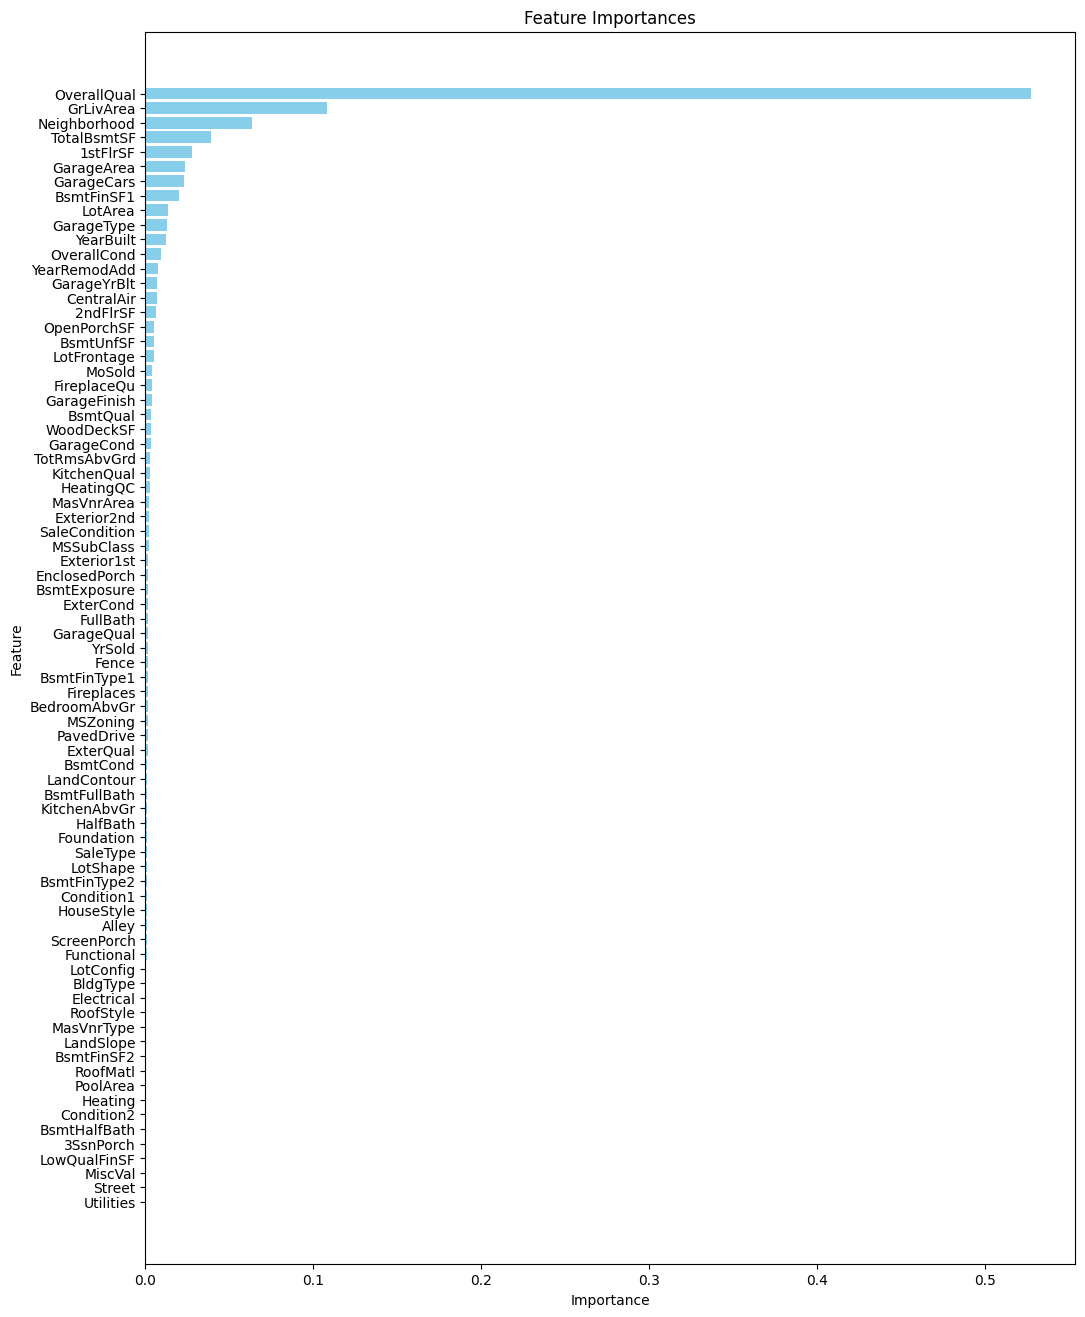

In [ ]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train_encoded.columns

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 16))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [ ]:
feature_importances_df.iloc[:20]

Feature  Importance
16   OverallQual    0.527353
45     GrLivArea    0.108081
11  Neighborhood    0.063266
37   TotalBsmtSF    0.039208
42      1stFlrSF    0.027474
61    GarageArea    0.023843
60    GarageCars    0.022935
33    BsmtFinSF1    0.019749
3        LotArea    0.013225
57    GarageType    0.012932
18     YearBuilt    0.012160
17   OverallCond    0.009368
19  YearRemodAdd    0.007642
58   GarageYrBlt    0.006971
40    CentralAir    0.006685
43      2ndFlrSF    0.006504
66   OpenPorchSF    0.005366
36     BsmtUnfSF    0.005242
2    LotFrontage    0.005138
73        MoSold    0.004041

##### model test 3 - XGBoost & meanEncoder - rmse 0.1446 (The famous Gradient Boosting Tree model seems not help too much?)

In [ ]:
xgbmodel = XGBRegressor(objective='reg:squarederror',
                        n_estimators=100,
                        learning_rate=0.1,
                        eval_metric='rmse',
                        n_jobs=-1)
# Fit the model with evaluation set
xgbmodel.fit(X_train_encoded, y_train, eval_set=[(X_valid_encoded, y_valid)], verbose=False)

y_pred = xgbmodel.predict(X_valid_encoded)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Root Mean Squared Error: {rmse:.4f}')

Root Mean Squared Error: 0.1446


##### Model test 4 - XGBoost w paratuning & meanEncoder - rmse 0.1312 (RandomizedSearchCV helped a lot to find good parameters for Gradient Boosting Tree)

In [ ]:
%%time
## test on parameter tuning for xgboost (keep features)
xgbmodel = XGBRegressor(objective='reg:squarederror',eval_metric='rmse')
# Define the parameter distribution
param_dist = { 'n_estimators': randint(150, 500)
                ,'max_depth': randint(3, 10)  # Randomly pick between 3 and 10
                ,'learning_rate': loguniform(0.005, 0.3)  # Log-uniform distribution between 0.01 and 0.3
                ,'subsample': uniform(0.5, 0.5)  # Randomly pick between 0.6 and 1.0
                ,'colsample_bytree': uniform(0.4, 0.6)  # Randomly pick between 0.6 and 1.0
                ,'gamma': uniform(0, 0.5)  # Randomly pick between 0 and 0.5
                ,'min_child_weight': randint(1, 6)  # Randomly pick between 1 and 5
                #,'reg_alpha': uniform(0, 10)  # Randomly pick between 0 and 10
                #,'reg_lambda': uniform(0, 10)  # Randomly pick between 0 and 10
             }
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgbmodel, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42, verbose=2, n_jobs=3)
# Fit the model
random_search.fit(X_train_encoded, y_train, eval_set=[(X_valid_encoded, y_valid)],verbose=False)
# Print the best score
print("Best score: ", np.sqrt((-random_search.best_score_)))
# Print the best parameters
print("Best parameters found: ", random_search.best_params_)
# Use the best model to make predictions
tunedmodel = random_search.best_estimator_
# Evaluate the model using RMSE
y_pred = tunedmodel.predict(X_valid_encoded)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Root Mean Squared Error for testset: {rmse:.4f}')

ytrain_pred = tunedmodel.predict(X_train_encoded)
rmse_train = np.sqrt(mean_squared_error(y_train, ytrain_pred))
print(f'Root Mean Squared Error for trainset: {rmse_train:.4f}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score:  0.1284057066203352
Best parameters found:  {'colsample_bytree': 0.916438349953806, 'gamma': 0.0034760652655953517, 'learning_rate': 0.04047212046195181, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 374, 'subsample': 0.5599326836668415}
Root Mean Squared Error for testset: 0.1312
Root Mean Squared Error for trainset: 0.0753
CPU times: user 1.97 s, sys: 164 ms, total: 2.13 s
Wall time: 58 s


###### Feature importance: more features are making significant contribution on help train the model. XGBoost seems to able to utilize more features to train the model!

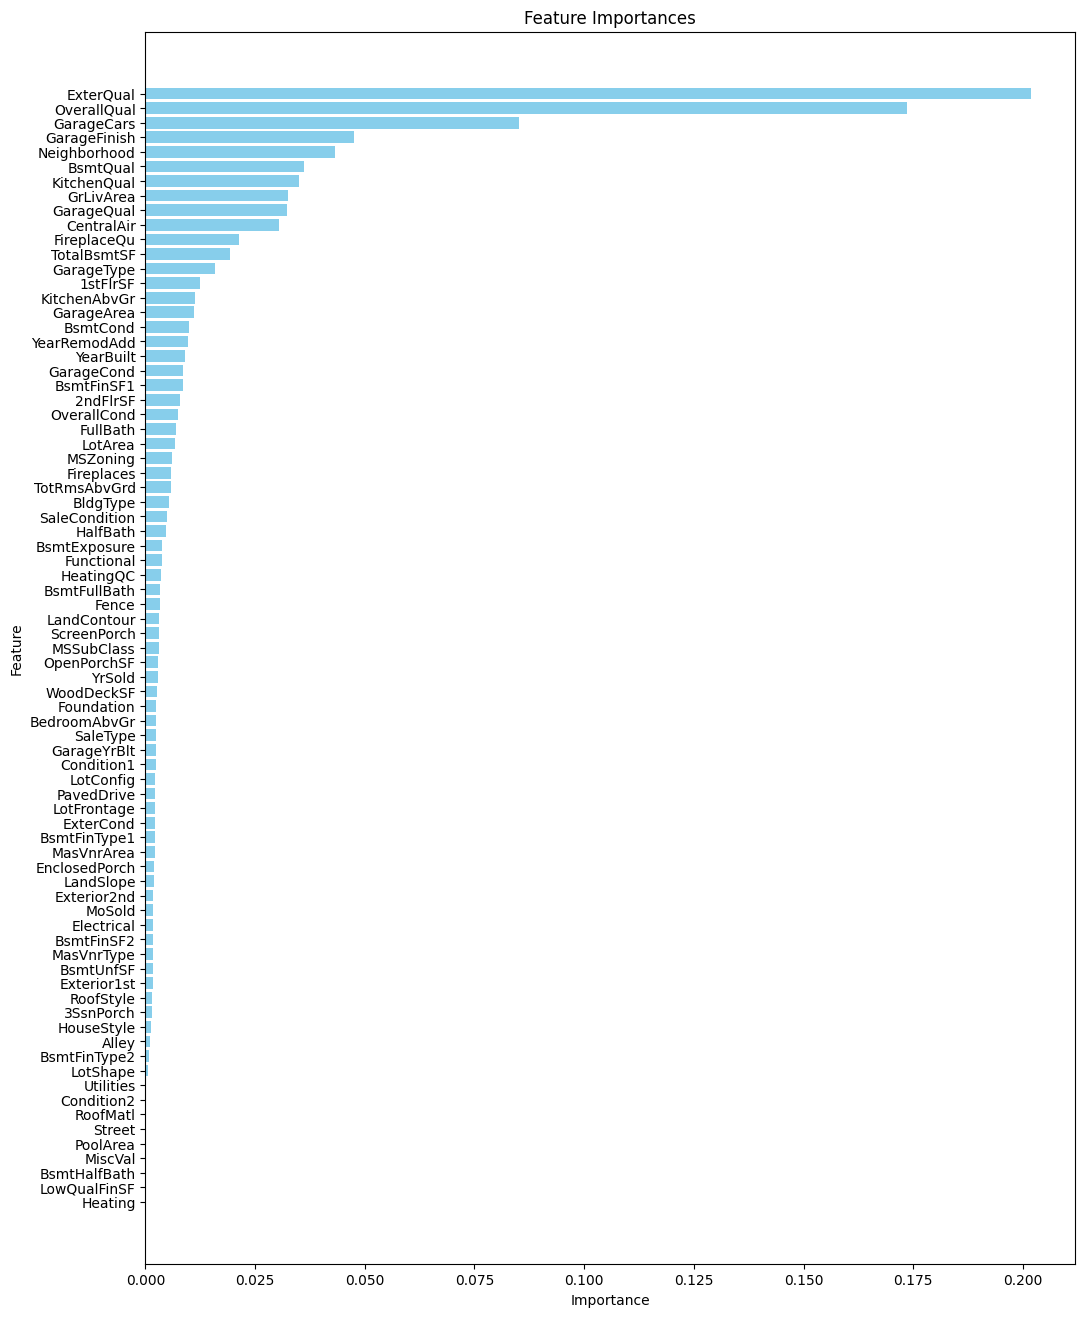

In [ ]:
# Get feature importances
importances = tunedmodel.feature_importances_
feature_names = X_train_encoded.columns

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 16))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [ ]:
feature_importances_df.iloc[:20]

Feature  Importance
26     ExterQual    0.201879
16   OverallQual    0.173552
60    GarageCars    0.085149
59  GarageFinish    0.047593
11  Neighborhood    0.043223
29      BsmtQual    0.036199
52   KitchenQual    0.035056
45     GrLivArea    0.032431
62    GarageQual    0.032232
40    CentralAir    0.030453
56   FireplaceQu    0.021421
37   TotalBsmtSF    0.019336
57    GarageType    0.015884
42      1stFlrSF    0.012524
51  KitchenAbvGr    0.011210
61    GarageArea    0.011090
30      BsmtCond    0.009868
19  YearRemodAdd    0.009645
18     YearBuilt    0.008947
63    GarageCond    0.008651

###### test using pipeline: RSME: 0.1315

In [ ]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor

# Custom transformer to handle mean encoding with target
class TargetEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.encoder = TargetEncoder(cols=self.cols)

    def fit(self, X, y=None):
        self.encoder.fit(X, y)
        return self

    def transform(self, X, y=None):
        return self.encoder.transform(X)


# Get list of categorical columns
catcollist = X_mlb.select_dtypes(include=['object']).columns.tolist()

# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_mlb, ylog, test_size=200, random_state=42)

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('mean_enc', TargetEncoderWrapper(cols=catcollist), catcollist)
    ],
    remainder='passthrough'
)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror',eval_metric='rmse'))
])

# Define parameter grid for RandomizedSearchCV
param_dist = { 'model__n_estimators': randint(150, 500)
                ,'model__max_depth': randint(3, 10)  # Randomly pick between 3 and 10
                ,'model__learning_rate': loguniform(0.005, 0.3)  # Log-uniform distribution between 0.01 and 0.3
                ,'model__subsample': uniform(0.5, 0.5)  # Randomly pick between 0.6 and 1.0
                ,'model__colsample_bytree': uniform(0.4, 0.6)  # Randomly pick between 0.6 and 1.0
                ,'model__gamma': uniform(0, 0.5)  # Randomly pick between 0 and 0.5
                ,'model__min_child_weight': randint(1, 6)  # Randomly pick between 1 and 5
                #,'reg_alpha': uniform(0, 10)  # Randomly pick between 0 and 10
                #,'reg_lambda': uniform(0, 10)  # Randomly pick between 0 and 10
             }

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42, verbose=2, n_jobs=3)

# Fit RandomizedSearchCV with training data
random_search.fit(X_train, y_train)
# Print the best score
print("Best score: ", np.sqrt((-random_search.best_score_)))
# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate on validation set
y_pred = best_model.predict(X_valid)
final_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

print(f'Final RMSE on Validation Set: {final_rmse}')


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score:  0.12812945397291306
Best parameters found:  {'model__colsample_bytree': 0.916438349953806, 'model__gamma': 0.0034760652655953517, 'model__learning_rate': 0.04047212046195181, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 374, 'model__subsample': 0.5599326836668415}
Final RMSE on Validation Set: 0.1314879422959735


##### Model test 5: feature selection RFE (XGBoost w paratuning & meanEncoder) rmse: 0.1270 (X_train_RFE, X_valid_RFE)

In [ ]:
%%time
from sklearn.feature_selection import RFE

# Initialize the model
xgbmodel = XGBRegressor(objective='reg:squarederror',
                        n_estimators=100,
                        learning_rate=0.1,
                        eval_metric='rmse',
                        n_jobs=-1)

# Perform RFE
selector = RFE(estimator=xgbmodel, n_features_to_select=60, step=1)
selector = selector.fit(X_train_encoded, y_train)

# Get the selected features
selected_features = X_train_encoded.columns[selector.support_]
X_train_RFE = selector.transform(X_train_encoded)
X_valid_RFE = selector.transform(X_valid_encoded)

In [ ]:
%%time
## test on parameter tuning for xgboost (keep features)
xgbmodel = XGBRegressor(objective='reg:squarederror',eval_metric='rmse')
# Define the parameter distribution
param_dist = { 'n_estimators': randint(150, 500)
                ,'max_depth': randint(3, 10)  # Randomly pick between 3 and 10
                ,'learning_rate': loguniform(0.005, 0.3)  # Log-uniform distribution between 0.01 and 0.3
                ,'subsample': uniform(0.5, 0.5)  # Randomly pick between 0.6 and 1.0
                ,'colsample_bytree': uniform(0.4, 0.6)  # Randomly pick between 0.6 and 1.0
                ,'gamma': uniform(0, 0.5)  # Randomly pick between 0 and 0.5
                ,'min_child_weight': randint(1, 6)  # Randomly pick between 1 and 5
                #,'reg_alpha': uniform(0, 10)  # Randomly pick between 0 and 10
                #,'reg_lambda': uniform(0, 10)  # Randomly pick between 0 and 10
             }
# Initialize RandomizedSearchCV
random_search_rfe = RandomizedSearchCV(estimator=xgbmodel, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42, verbose=2, n_jobs=3)
# Fit the model
random_search_rfe.fit(X_train_RFE, y_train, eval_set=[(X_valid_RFE, y_valid)],verbose=False)
# Print the best score
print("Best score: ", np.sqrt((-random_search_rfe.best_score_)))
# Print the best parameters
print("Best parameters found: ", random_search_rfe.best_params_)
# Use the best model to make predictions
tunedmodel_rfe = random_search_rfe.best_estimator_
# Evaluate the model using RMSE
y_pred = tunedmodel_rfe.predict(X_valid_RFE)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Root Mean Squared Error for testset: {rmse:.4f}')
ytrain_pred = tunedmodel_rfe.predict(X_train_RFE)
rmse_train = np.sqrt(mean_squared_error(y_train, ytrain_pred))
print(f'Root Mean Squared Error for trainset: {rmse_train:.4f}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score:  0.12653205175949037
Best parameters found:  {'colsample_bytree': 0.916438349953806, 'gamma': 0.0034760652655953517, 'learning_rate': 0.04047212046195181, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 374, 'subsample': 0.5599326836668415}
Root Mean Squared Error for testset: 0.1270
Root Mean Squared Error for trainset: 0.0753
CPU times: user 5.59 s, sys: 114 ms, total: 5.71 s
Wall time: 40.2 s


In [ ]:
###which columns were dropped?
# Get the dropped features
dropped_features = X_train_encoded.columns[~selector.support_]

print("Dropped Features:")
print(dropped_features)


Dropped Features:
Index(['MSSubClass', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'Utilities',
       'Condition2', 'HouseStyle', 'RoofMatl', 'MasVnrType', 'MasVnrArea',
       'Heating', 'Electrical', 'LowQualFinSF', '3SsnPorch', 'PoolArea',
       'MiscVal'],
      dtype='object')


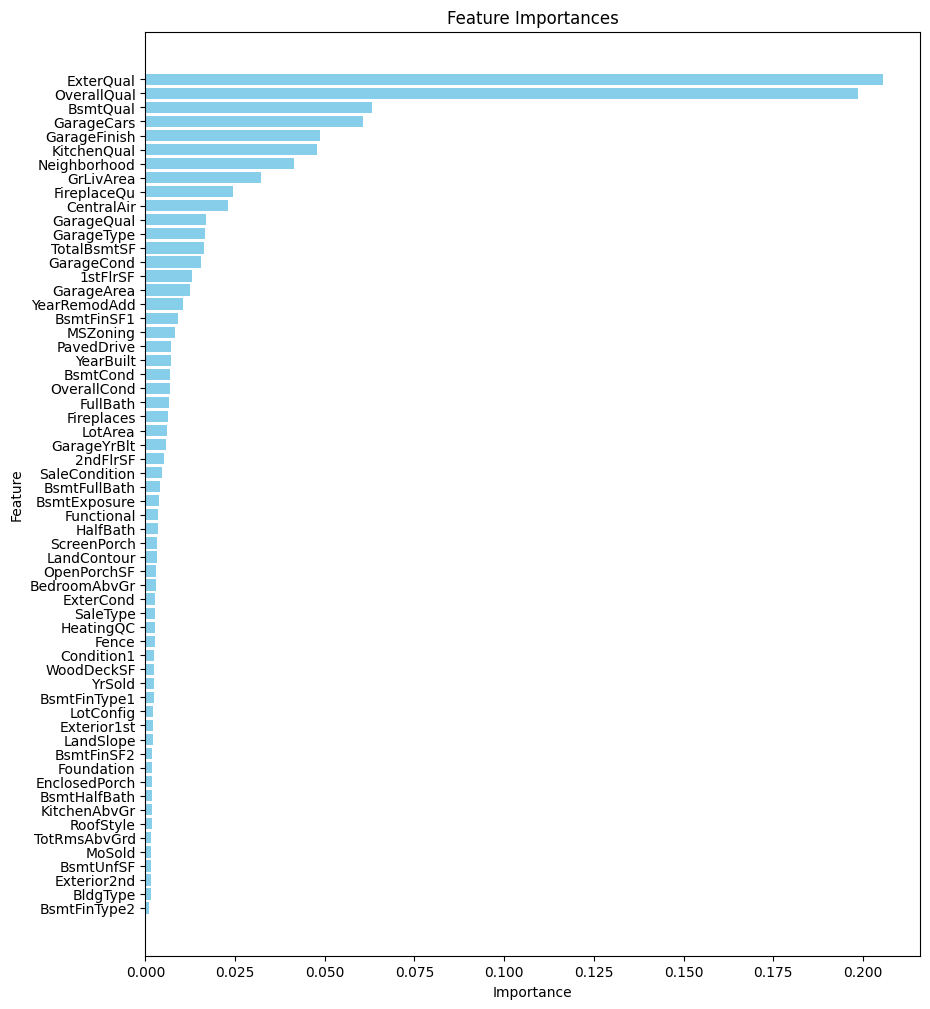

In [ ]:
# Get feature importances
importances = tunedmodel_rfe.feature_importances_
feature_names = selected_features

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

### Model inference nference rmse 0.122 - ranked 242 among 3,600 participants

#### Retrain the fine-tuned XGBregressor by using the combined X_train_RFE

In [ ]:
X_train_RFE

array([[1.20839037e+01, 7.07610000e+04, 1.21094630e+01, ...,
        2.00600000e+03, 1.19972403e+01, 1.20092636e+01],
       [1.20839037e+01, 2.18720000e+04, 1.22695371e+01, ...,
        2.00800000e+03, 1.19972403e+01, 1.20092636e+01],
       [1.17071333e+01, 1.06900000e+04, 1.20261102e+01, ...,
        2.00900000e+03, 1.19972403e+01, 1.20092636e+01],
       ...,
       [1.20839037e+01, 8.17200000e+03, 1.20261102e+01, ...,
        2.00600000e+03, 1.19972403e+01, 1.20092636e+01],
       [1.20839037e+01, 7.64200000e+03, 1.20261102e+01, ...,
        2.00700000e+03, 1.19972403e+01, 1.20092636e+01],
       [1.20839037e+01, 3.68400000e+03, 1.20261102e+01, ...,
        2.00900000e+03, 1.19972403e+01, 1.20092636e+01]])

In [ ]:
## combine the train data and valid data
X_train_RFEdf = pd.DataFrame(X_train_RFE, columns=selected_features)
X_valid_RFEdf = pd.DataFrame(X_valid_RFE, columns=selected_features)

X_trainrfe_combo = pd.concat([X_train_RFEdf, X_valid_RFEdf], axis=0)

print(X_trainrfe_combo)

      MSZoning  LotArea  LandContour  LotConfig  LandSlope  Neighborhood  \
0    12.083904  70761.0    12.109463  12.010547  12.104148     12.163862   
1    12.083904  21872.0    12.269537  12.021972  12.023059     12.165863   
2    11.707133  10690.0    12.026110  12.010547  12.023059     11.671803   
3    12.083904   9200.0    12.026110  12.010547  12.023059     12.521820   
4    12.083904   8450.0    12.026110  12.010547  12.023059     12.179004   
..         ...      ...          ...        ...        ...           ...   
195  12.083904   7800.0    11.813764  12.010547  12.104148     11.708049   
196  12.246084   3316.0    12.026110  12.010547  12.023059     12.300876   
197  11.886886   8500.0    12.026110  12.010547  12.023059     11.671803   
198  12.246084   2645.0    12.026110  12.010547  12.023059     12.300876   
199  12.083904   7681.0    12.026110  12.021972  12.023059     12.196986   

     Condition1   BldgType  OverallQual  OverallCond  ...  PavedDrive  \
0     12.04475

In [ ]:
## combine the train data and valid data
y_train_RFE = pd.DataFrame(y_train)
y_valid_RFE = pd.DataFrame(y_valid)
y_trainrfe_combo = pd.concat([y_train_RFE, y_valid_RFE], axis=0, ignore_index=True)
y_trainrfe_combo

SalePrice
0     12.542545
1     12.072541
2     11.898188
3     12.660328
4     12.128111
...         ...
1455  12.323856
1456  12.190959
1457  10.596635
1458  12.058153
1459  11.950535

[1460 rows x 1 columns]

In [ ]:
%%time
### retrain the model based on the whole dataset

# Retrieve the best parameters from RandomizedSearchCV
best_params = random_search_rfe.best_params_

# Add additional parameters
additional_params = {
    'objective':'reg:squarederror',
    'eval_metric':'rmse'
}

# Update the best parameters with the new ones
best_params.update(additional_params)

# Create a new model with the updated parameters
model_inference = XGBRegressor(**best_params)

# Train the final model on the combined dataset (or any dataset you choose)
model_inference.fit(X_trainrfe_combo, y_trainrfe_combo)

ytrain_pred_rfe = model_inference.predict(X_trainrfe_combo)
rmse_train = np.sqrt(mean_squared_error(y_trainrfe_combo, ytrain_pred_rfe))
print(f'Root Mean Squared Error for trainset: {rmse_train:.4f}')

Root Mean Squared Error for trainset: 0.0794
CPU times: user 2.21 s, sys: 6.07 ms, total: 2.22 s
Wall time: 2.17 s


#### Implement data cleaning and feature engi for X_test

In [17]:
print(X_test.shape)
X_test.head()

(1459, 79)


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave   NaN      Reg   
1462          20       RL         81.0    14267   Pave   NaN      IR1   
1463          60       RL         74.0    13830   Pave   NaN      IR1   
1464          60       RL         78.0     9978   Pave   NaN      IR1   
1465         120       RL         43.0     5005   Pave   NaN      IR1   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1461         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1462         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
1463         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
1464         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1465         HLS    AllPub    Inside  ...         144        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1461         NaN       0       6    2010        WD         Normal  
1462        Gar2   12500       6    2010        WD         Normal  
1463         NaN       0       3    2010        WD         Normal  
1464         NaN       0       6    2010        WD         Normal  
1465         NaN       0       1    2010        WD         Normal  

[5 rows x 79 columns]

In [19]:
## drop 2 categorical features with super high NA%
X_test2 = X_test.copy(deep=True)
X_test2.drop(['PoolQC','MiscFeature'], axis=1, inplace=True)
### fill NA for a bunch of categorical features - fill with 'None'
catna_none = ['Alley','Fence','MasVnrType', 'FireplaceQu', 'GarageType', 'GarageQual', 'GarageCond', 'GarageFinish', 'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond']
X_test2[catna_none] = X_test2[catna_none].fillna('None')
### fill na for cat features 'Electrical' - fill with most frequent value
most_frequent_value = X_test2['Electrical'].mode()[0]
X_test2['Electrical'] = X_test2['Electrical'].fillna(most_frequent_value)
### fill NA for 2 numerical features
X_test2['GarageYrBlt'] = X_test2['GarageYrBlt'].fillna(1700) ##fill na of garageyrblt with 1700
X_test2['MasVnrArea'] = X_test2['MasVnrArea'].fillna(0) ##fill na of MasVnrArea with 0
##fill na of LotFrontage with mean
X_test2['LotFrontage'] = X_test2['LotFrontage'].fillna(X_test2['LotFrontage'].mean())

X_test_encoded = mean_encoder.transform(X_test2)

print("Training Set shape: ", X_train_encoded.shape)
print("Valid Set shape: ", X_valid_encoded.shape)
print("Test Set shape: ", X_test_encoded.shape)


Training Set shape:  (1260, 77)
Valid Set shape:  (200, 77)
Test Set shape:  (1459, 77)


In [ ]:
X_test_RFE = selector.transform(X_test_encoded)
print(X_test_RFE.shape)

(1459, 60)



#### Implement inference - obtained inference rmse 0.122 - ranked 242 among 3,600 participants

In [ ]:
y_pred_test = model_inference.predict(X_test_RFE)
testpred = np.exp(y_pred_test)
print(np.mean(testpred))
print(testpred)

test_id=X_test.index.tolist()
def submit_method(test_id, y_prediction):
    sub = pd.DataFrame()
    sub['Id'] = test_id
    sub['SalePrice'] = y_prediction
    print(sub.shape)
    return sub

subcsv=submit_method(test_id, testpred)

subcsv.to_csv('submission20250301v2.csv', index=False)

177583.69
[126646.5  160282.86 183504.62 ... 160738.4  115585.23 196617.1 ]


In [ ]:
test_id=X_test.index.tolist()
def submit_method(test_id, y_prediction):
    sub = pd.DataFrame()
    sub['Id'] = test_id
    sub['SalePrice'] = y_prediction
    print(sub.shape)
    return sub

subcsv=submit_method(test_id, testpred)

subcsv.to_csv('submission20250301v2.csv', index=False)

(1459, 2)


### Feature Engineering
##### Try to create new features through combining existing features and create more powerful ones. But this doesn't really help XGBoost regressor.
##### The learning here is that, for XGBoost, you'd better let it handle feature engineering by itself instead of manually creating new ones. XGBoost naturally can handle feature selection and feature interaction by using its algorthm.

In [ ]:
## make a copy of X_mlb to handle feature engineering
X_mlbfe = X_mlb.copy(deep=True)

#### Feature Engineering 1 - Create new numerical feats (SF features, room counts, porch size etc) - rmse: 0.1318: Didn't get better performance! Just wondering if there are some redudant/correlated features, should have better performance if conducting feature selection

In [ ]:
### good above grade living area // new formula
X_mlbfe['GrLivArea_good'] = X_mlbfe['GrLivArea']-X_mlbfe['LowQualFinSF']
### good above grade living area%
X_mlbfe['GrLivArea_good%'] = X_mlbfe['GrLivArea_good']/X_mlbfe['GrLivArea']

### total liv area (bsmt area + grlivarea )
X_mlbfe['LivArea_total'] = X_mlbfe['GrLivArea']+X_mlbfe['TotalBsmtSF']
### total liv area good (finished bsmt area + grlivarea_good)
X_mlbfe['LivArea_good'] = X_mlbfe['GrLivArea_good']+X_mlbfe['BsmtFinSF1']+X_mlbfe['BsmtFinSF1']
### total liv area good %
X_mlbfe['LivArea_good%'] = X_mlbfe['LivArea_good']/X_mlbfe['LivArea_total']

## TotalOutdoorArea
X_mlbfe['TotalOutdoorArea'] = X_mlbfe['WoodDeckSF'] + X_mlbfe['OpenPorchSF'] + X_mlbfe['EnclosedPorch'] + X_mlbfe['3SsnPorch'] + X_mlbfe['ScreenPorch']

## calculate SQFT per room // new formula
X_mlbfe["SqFtPerRoom"] = X_mlbfe["GrLivArea"] / (X_mlbfe["TotRmsAbvGrd"])

## add count of bathrooms
X_mlbfe['Total_Bathrooms'] = (X_mlbfe['FullBath'] + (0.5 * X_mlbfe['HalfBath']) +X_mlbfe['BsmtFullBath'] + (0.5 * X_mlbfe['BsmtHalfBath']))
## enhance the feature of house condiction
#X_mlbfe['Total_Home_Quality'] = X_mlbfe['OverallQual'] + X_mlbfe['OverallCond']
### transform year features
X_mlbfe["HouseAge"] = pd.to_numeric(X_mlbfe["YrSold"])-pd.to_numeric(X_mlbfe["YearBuilt"])
X_mlbfe["RenovateAge"] = pd.to_numeric(X_mlbfe["YrSold"]) - pd.to_numeric(X_mlbfe["YearRemodAdd"])

X_mlbfe['Total_Home_Quality'] = X_mlbfe['OverallQual'] + X_mlbfe['OverallCond']

# Split the data into training and validation sets with fixed validation size of 200 samples
Xfe_train, Xfe_valid, y_train, y_valid = train_test_split(X_mlbfe, ylog, test_size=200, random_state=42)

#from category_encoders import TargetEncoder
catcollist = X_mlbfe.select_dtypes(include=['object']).columns.tolist()
# Apply mean encoding on the training set
mean_encoder = TargetEncoder(cols=catcollist)
Xfe_train_encoded = mean_encoder.fit_transform(Xfe_train, y_train)
# Transform the test set using the fitted mean encoder
Xfe_valid_encoded = mean_encoder.transform(Xfe_valid)

# Now X_train_encoded and X_test_encoded are ready for model training and evaluation
print("Training Set shape:", Xfe_train_encoded.shape)
print("Test Set shape:", Xfe_valid_encoded.shape)

Training Set shape: (1260, 89)
Test Set shape: (200, 89)


In [ ]:
%%time
## test on parameter tuning for xgboost (keep features)
xgbmodel = XGBRegressor(objective='reg:squarederror',eval_metric='rmse')
# Define the parameter distribution
param_dist = { 'n_estimators': randint(150, 500)
                ,'max_depth': randint(3, 10)  # Randomly pick between 3 and 10
                ,'learning_rate': loguniform(0.005, 0.3)  # Log-uniform distribution between 0.01 and 0.3
                ,'subsample': uniform(0.5, 0.5)  # Randomly pick between 0.6 and 1.0
                ,'colsample_bytree': uniform(0.4, 0.6)  # Randomly pick between 0.6 and 1.0
                ,'gamma': uniform(0, 0.5)  # Randomly pick between 0 and 0.5
                ,'min_child_weight': randint(1, 6)  # Randomly pick between 1 and 5
                #,'reg_alpha': uniform(0, 10)  # Randomly pick between 0 and 10
                #,'reg_lambda': uniform(0, 10)  # Randomly pick between 0 and 10
             }
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgbmodel, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42, verbose=2, n_jobs=3)
# Fit the model
random_search.fit(Xfe_train_encoded, y_train, eval_set=[(Xfe_valid_encoded, y_valid)],verbose=False)
# Print the best score
print("Best score: ", np.sqrt((-random_search.best_score_)))
# Print the best parameters
print("Best parameters found: ", random_search.best_params_)
# Use the best model to make predictions
tunedmodel = random_search.best_estimator_
# Evaluate the model using RMSE
y_pred = tunedmodel.predict(Xfe_valid_encoded)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Root Mean Squared Error for testset: {rmse:.4f}')

ytrain_pred = tunedmodel.predict(Xfe_train_encoded)
rmse_train = np.sqrt(mean_squared_error(y_train, ytrain_pred))
print(f'Root Mean Squared Error for trainset: {rmse_train:.4f}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score:  0.12663244539456384
Best parameters found:  {'colsample_bytree': 0.4991601634378015, 'gamma': 0.007818203370596966, 'learning_rate': 0.028303612950642508, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 285, 'subsample': 0.5027610585618012}
Root Mean Squared Error for testset: 0.1318
Root Mean Squared Error for trainset: 0.0890
CPU times: user 3.35 s, sys: 365 ms, total: 3.71 s
Wall time: 1min 59s


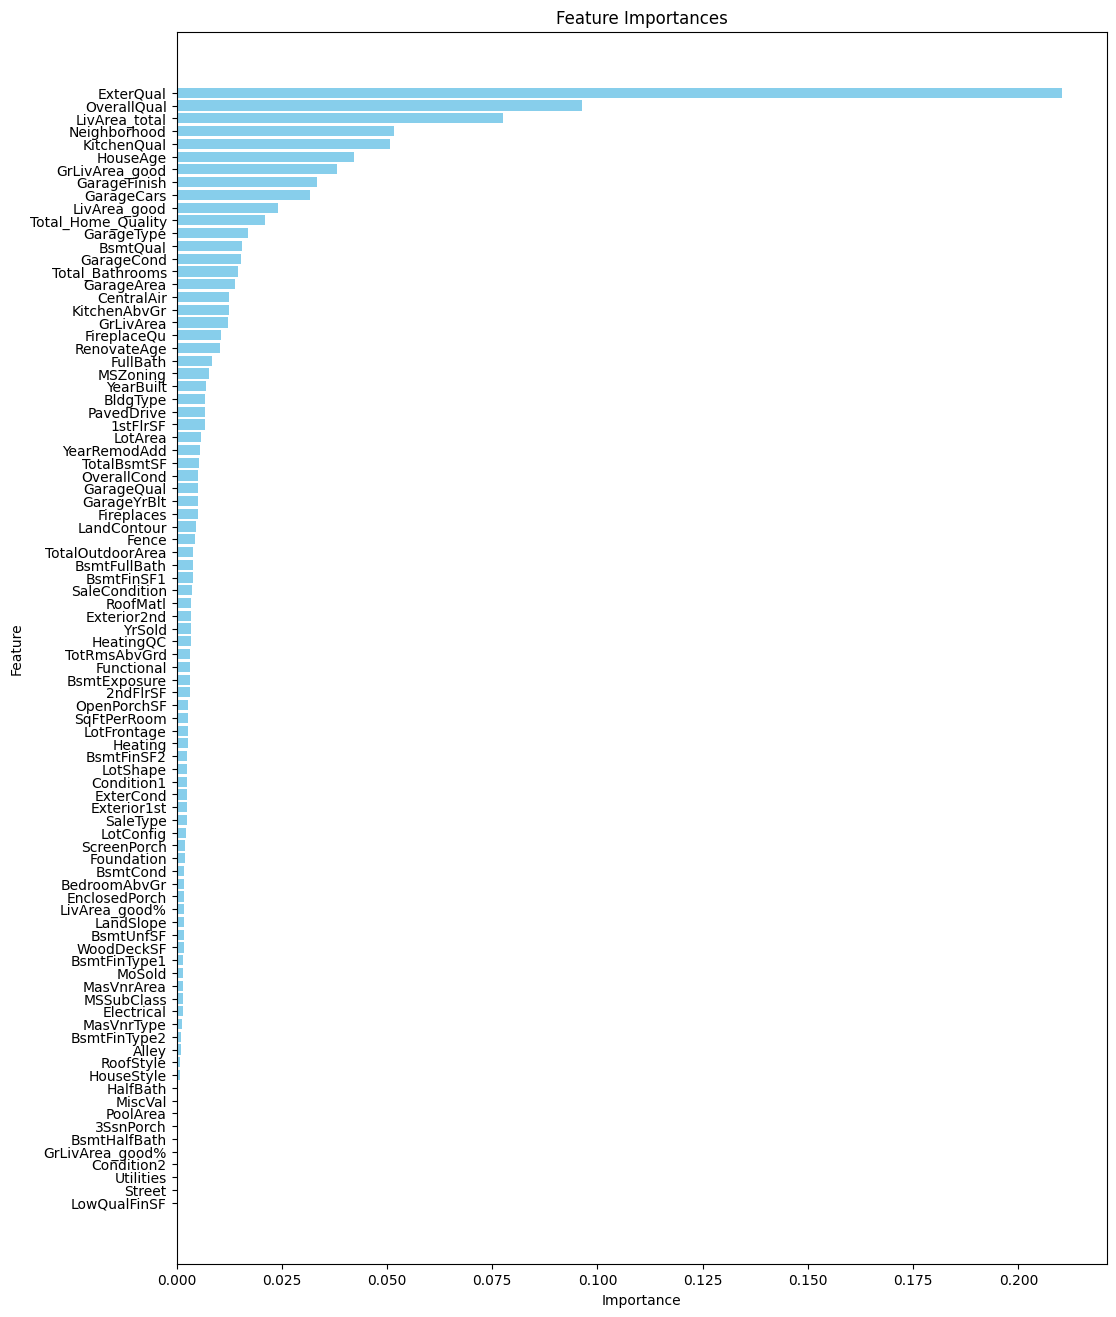

In [ ]:
# Get feature importances
importances = tunedmodel.feature_importances_
feature_names = X_train_encoded.columns

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 16))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#### Feature Engineering 2 - try to overcome overfitting: mannually cut redundant features - rmse: 0.1331; the model performance gets worse, so need to figure out a better way of feature selection

In [ ]:
## make a copy of the data
X_mlbfe12 = X_mlb.copy(deep=True)

X_mlbfe12.drop(['GrLivArea_good','LowQualFinSF','LivArea_good','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                  'FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','OverallCond','YearBuilt','YearRemodAdd','YrSold','MoSold'], axis=1, inplace=True)

# Split the data into training and validation sets with fixed validation size of 200 samples
X_train, X_valid, y_train, y_valid = train_test_split(X_mlbfe12, ylog, test_size=200, random_state=42)

#from category_encoders import TargetEncoder
catcollist = X_mlbfe12.select_dtypes(include=['object']).columns.tolist()
# Apply mean encoding on the training set
mean_encoder = TargetEncoder(cols=catcollist)
X_train_encoded = mean_encoder.fit_transform(X_train, y_train)
# Transform the test set using the fitted mean encoder
X_valid_encoded = mean_encoder.transform(X_valid)

# Now X_train_encoded and X_test_encoded are ready for model training and evaluation
print("Training Set shape:", X_train_encoded.shape)
print("Test Set shape:", X_valid_encoded.shape)

Training Set shape: (1260, 68)
Test Set shape: (200, 68)


In [ ]:
%%time
## 2 more feats
## test on parameter tuning for xgboost (keep features)
xgbmodel = XGBRegressor(objective='reg:squarederror',eval_metric='rmse')
# Define the parameter distribution
param_dist = { 'n_estimators': randint(150, 500)
                ,'max_depth': randint(3, 10)  # Randomly pick between 3 and 10
                ,'learning_rate': loguniform(0.005, 0.3)  # Log-uniform distribution between 0.01 and 0.3
                ,'subsample': uniform(0.5, 0.5)  # Randomly pick between 0.6 and 1.0
                ,'colsample_bytree': uniform(0.4, 0.6)  # Randomly pick between 0.6 and 1.0
                ,'gamma': uniform(0, 0.5)  # Randomly pick between 0 and 0.5
                ,'min_child_weight': randint(1, 6)  # Randomly pick between 1 and 5
                #,'reg_alpha': uniform(0, 10)  # Randomly pick between 0 and 10
                #,'reg_lambda': uniform(0, 10)  # Randomly pick between 0 and 10
             }
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgbmodel, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42, verbose=2, n_jobs=3)
# Fit the model
random_search.fit(X_train_encoded, y_train, eval_set=[(X_valid_encoded, y_valid)],verbose=False)
# Print the best score
print("Best score: ", np.sqrt((-random_search.best_score_)))
# Print the best parameters
print("Best parameters found: ", random_search.best_params_)
# Use the best model to make predictions
tunedmodel = random_search.best_estimator_
# Evaluate the model using RMSE
y_pred = tunedmodel.predict(X_valid_encoded)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Root Mean Squared Error for testset: {rmse:.4f}')

ytrain_pred = tunedmodel.predict(X_train_encoded)
rmse_train = np.sqrt(mean_squared_error(y_train, ytrain_pred))
print(f'Root Mean Squared Error for trainset: {rmse_train:.4f}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score:  0.12628409293524456
Best parameters found:  {'colsample_bytree': 0.5437371344001835, 'gamma': 0.07244743604561155, 'learning_rate': 0.037092921636491055, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 352, 'subsample': 0.6848272280307022}
Root Mean Squared Error for testset: 0.1331
Root Mean Squared Error for trainset: 0.0753
CPU times: user 1.85 s, sys: 123 ms, total: 1.98 s
Wall time: 45 s


#### Feature Engineering 3 - Try RFE feature selection - RMSE: 0.1293; The performance didn't show improvements! Why? I guess XGBoost library natually can handle a lot of feature selection and feature interactions, which already extract a lot of meaningful info out of the features.

In [ ]:
##               70: 0.1321; 65:0.1288; 62:0.1335; 60:0.1280; 55:0.1307
## 2 more feats: 70: 0.1282; 68:0.1261; 65:0.1292; 63:0.1306; 60:0.1291;
## last tests:   70: 0.1317; 68:0.1295; 65:0.1307; 63:0.1; 60:0.1;
## new test: 75:0.1306; 73:0.1299; 70: 0.1309; 68:0.1293

In [ ]:
%%time
## Implement RFE feature selection
from sklearn.feature_selection import RFE

# Initialize the model
xgbmodel = XGBRegressor(objective='reg:squarederror',
                        n_estimators=100,
                        learning_rate=0.1,
                        eval_metric='rmse',
                        n_jobs=-1)

# Perform RFE
selector = RFE(estimator=xgbmodel, n_features_to_select=68, step=1)
selector = selector.fit(Xfe_train_encoded, y_train)

# Get the selected features
selected_features = Xfe_train.columns[selector.support_]
Xfe_train_RFE = selector.transform(Xfe_train_encoded)
Xfe_valid_RFE = selector.transform(Xfe_valid_encoded)

print(f'RFE train set shape is {Xfe_train_RFE.shape}')
print(f'RFE valid set shape is {Xfe_valid_RFE.shape}')

RFE train set shape is (1260, 68)
RFE valid set shape is (200, 68)
CPU times: user 46.5 s, sys: 193 ms, total: 46.6 s
Wall time: 34.4 s


In [ ]:
%%time
## test on parameter tuning for xgboost (keep features)
xgbmodel = XGBRegressor(objective='reg:squarederror',eval_metric='rmse')
# Define the parameter distribution
param_dist = { 'n_estimators': randint(150, 500)
                ,'max_depth': randint(3, 10)  # Randomly pick between 3 and 10
                ,'learning_rate': loguniform(0.005, 0.3)  # Log-uniform distribution between 0.01 and 0.3
                ,'subsample': uniform(0.5, 0.5)  # Randomly pick between 0.6 and 1.0
                ,'colsample_bytree': uniform(0.4, 0.6)  # Randomly pick between 0.6 and 1.0
                ,'gamma': uniform(0, 0.5)  # Randomly pick between 0 and 0.5
                ,'min_child_weight': randint(1, 6)  # Randomly pick between 1 and 5
                #,'reg_alpha': uniform(0, 10)  # Randomly pick between 0 and 10
                #,'reg_lambda': uniform(0, 10)  # Randomly pick between 0 and 10
             }
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgbmodel, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42, verbose=2, n_jobs=3)
# Fit the model
random_search.fit(Xfe_train_RFE, y_train, eval_set=[(Xfe_valid_RFE, y_valid)],verbose=False)
# Print the best score
print("Best score: ", np.sqrt((-random_search.best_score_)))
# Print the best parameters
print("Best parameters found: ", random_search.best_params_)
# Use the best model to make predictions
tunedmodel = random_search.best_estimator_
# Evaluate the model using RMSE
y_pred = tunedmodel.predict(Xfe_valid_RFE)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Root Mean Squared Error for testset: {rmse:.4f}')

ytrain_pred = tunedmodel.predict(Xfe_train_RFE)
rmse_train = np.sqrt(mean_squared_error(y_train, ytrain_pred))
print(f'Root Mean Squared Error for trainset: {rmse_train:.4f}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score:  0.1274051303551732
Best parameters found:  {'colsample_bytree': 0.4991601634378015, 'gamma': 0.007818203370596966, 'learning_rate': 0.028303612950642508, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 285, 'subsample': 0.5027610585618012}
Root Mean Squared Error for testset: 0.1293
Root Mean Squared Error for trainset: 0.0897
CPU times: user 1.75 s, sys: 159 ms, total: 1.91 s
Wall time: 1min 9s


### Deep Neutral Network
#### DNN is famous for creating new features and handling feature selection, let's give it a try!

#### Some preparation - import library, build data pipeline, curate testdata

In [10]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.7 MB/s eta 0:00:00


In [12]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import optuna

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# ====== Data Pipeline ======

batch_size = 32
train_features_np = X_train_encoded.values
valid_features_np = X_valid_encoded.values

# Normalize features using StandardScaler
scaler = StandardScaler()
train_features_np = scaler.fit_transform(train_features_np)
valid_features_np = scaler.transform(valid_features_np)

## Normalize prediction target
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1))

# Convert NumPy arrays to PyTorch tensors after normalization
train_features = torch.tensor(train_features_np, dtype=torch.float32).to(device)
valid_features = torch.tensor(valid_features_np, dtype=torch.float32).to(device)
train_labels = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1).to(device)
valid_labels = torch.tensor(y_valid_scaled, dtype=torch.float32).view(-1, 1).to(device)

# Create dataloaders
# batch_size = 16
train_dataset = TensorDataset(train_features, train_labels)
valid_dataset = TensorDataset(valid_features, valid_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

### DNN complex tuning - add LR

#### Model tuning and training

In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import optuna

# ====== Setup: Device and Fixed Hyperparameters ======
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Fixed hyperparameters (for aspects not tuned by Optuna)
# batch_size = 32         # Batch size
dropout_rate = 0.2      # Dropout rate in the MLP
max_epochs = 100        # Maximum number of epochs per trial
patience = 10           # Patience for early stopping (used in scheduler)
criterion = nn.MSELoss()  # Mean Squared Error for regression

# ====== Model Definition Functions ======
def define_model(trial):
    """Define the MLP architecture for a given Optuna trial.
       Tuning both number of hidden layers and neurons per layer."""
    n_layers = trial.suggest_int("n_layers", 2, 4)
    layers = []
    input_dim = X_train.shape[1]  # number of features
    for i in range(n_layers):
        units = trial.suggest_int(f"n_units_l{i}", 64, 256)
        layers.append(nn.Linear(input_dim, units))
        layers.append(nn.ReLU())
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))
        input_dim = units
    layers.append(nn.Linear(input_dim, 1))  # Output layer for regression
    model = nn.Sequential(*layers)
    return model

def build_model_from_config(config):
    """Rebuild a model from a configuration dictionary (e.g., best found params)."""
    n_layers = config["n_layers"]
    layers = []
    input_dim = X_train.shape[1]
    for i in range(n_layers):
        units = config[f"n_units_l{i}"]
        layers.append(nn.Linear(input_dim, units))
        layers.append(nn.ReLU())
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))
        input_dim = units
    layers.append(nn.Linear(input_dim, 1))
    model = nn.Sequential(*layers)
    return model

# ====== Training Function with ReduceLROnPlateau ======
def train_model(model, lr):
    """
    Train the model for up to max_epochs with early stopping using
    ReduceLROnPlateau for dynamic learning rate adjustment.
    Returns the best validation loss and the best model state dict.
    """
    # Create optimizer with the tuned learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Setup ReduceLROnPlateau scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=patience, factor=0.5, min_lr=1e-6, verbose=True
    )

    best_val_loss = float('inf')
    best_state_dict = None

    for epoch in range(1, max_epochs + 1):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        val_loss_sum = 0.0
        total_samples = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                val_loss_sum += F.mse_loss(preds, y_batch, reduction='sum').item()
                total_samples += len(X_batch)
        val_loss = val_loss_sum / total_samples

        # Update best validation loss and state dict if improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}

        # Step the scheduler using the validation loss
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}: val_loss={val_loss:.6f}, lr={current_lr:.1e}")

        # Early stopping: if lr has reached the minimum threshold, stop training
        if current_lr <= scheduler.min_lrs[0]:
            print(f"Learning rate reached minimum threshold ({scheduler.min_lrs[0]}). Early stopping.")
            break

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    return best_val_loss, best_state_dict

# ====== Global Tracking for Best Model ======
best_global_model_state = None
best_global_val_loss = float('inf')
best_global_params = None

# ====== Optuna Objective Function ======
def objective(trial):
    global best_global_model_state, best_global_val_loss, best_global_params

    # Tune the initial learning rate as well as the network architecture
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    model = define_model(trial).to(device)
    val_loss, best_state = train_model(model, lr)

    # Update global best if current trial is better
    if val_loss < best_global_val_loss:
        best_global_val_loss = val_loss
        best_global_params = trial.params  # includes architecture & learning rate
        best_global_model_state = best_state
        torch.save(best_global_model_state, "best_dnnmodel2_statedict.pth")
        print(f"*** New best model found! Val MSE={val_loss:.6f}, Params={best_global_params}")
    return val_loss  # Optuna minimizes this

# ====== Run Optuna Study ======
study = optuna.create_study(direction="minimize")
print("Starting hyperparameter search...")
study.optimize(objective, n_trials=100, gc_after_trial=True)  # 100 trials

# ====== Hyperparameter Tuning Results ======
print("\nOptuna search completed.")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial index: {study.best_trial.number}")
print(f"Best validation MSE: {study.best_value:.6f}")
best_params = study.best_params
print("Best hyperparameter configuration:", best_params)

best_val_rmse = study.best_value ** 0.5
print(f"Best validation RMSE: {best_val_rmse:.6f}")


[I 2025-03-08 20:55:39,482] A new study created in memory with name: no-name-1b575c30-028c-4b49-ba3f-e3445ad19540


Using device: cuda
Starting hyperparameter search...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: val_loss=0.144845, lr=1.9e-03
Epoch 2: val_loss=0.140727, lr=1.9e-03
Epoch 3: val_loss=0.194526, lr=1.9e-03
Epoch 4: val_loss=0.224558, lr=1.9e-03
Epoch 5: val_loss=0.121393, lr=1.9e-03
Epoch 6: val_loss=0.167220, lr=1.9e-03
Epoch 7: val_loss=0.162397, lr=1.9e-03
Epoch 8: val_loss=0.143942, lr=1.9e-03
Epoch 9: val_loss=0.131134, lr=1.9e-03
Epoch 10: val_loss=0.164309, lr=1.9e-03
Epoch 11: val_loss=0.201017, lr=1.9e-03
Epoch 12: val_loss=0.180842, lr=1.9e-03
Epoch 13: val_loss=0.159464, lr=1.9e-03
Epoch 14: val_loss=0.152160, lr=1.9e-03
Epoch 15: val_loss=0.135335, lr=1.9e-03
Epoch 16: val_loss=0.139537, lr=9.5e-04
Epoch 17: val_loss=0.130255, lr=9.5e-04
Epoch 18: val_loss=0.139157, lr=9.5e-04
Epoch 19: val_loss=0.147659, lr=9.5e-04
Epoch 20: val_loss=0.137343, lr=9.5e-04
Epoch 21: val_loss=0.138261, lr=9.5e-04
Epoch 22: val_loss=0.137117, lr=9.5e-04
Epoch 23: val_loss=0.124934, lr=9.5e-04
Epoch 24: val_loss=0.127877, lr=9.5e-04
Epoch 25: val_loss=0.138443, lr=9.5e-04
Epoch 26:

[I 2025-03-08 20:55:53,976] Trial 0 finished with value: 0.12139257907867432 and parameters: {'lr': 0.001899027162483896, 'n_layers': 4, 'n_units_l0': 256, 'n_units_l1': 109, 'n_units_l2': 173, 'n_units_l3': 73}. Best is trial 0 with value: 0.12139257907867432.


Epoch 100: val_loss=0.135642, lr=7.4e-06
*** New best model found! Val MSE=0.121393, Params={'lr': 0.001899027162483896, 'n_layers': 4, 'n_units_l0': 256, 'n_units_l1': 109, 'n_units_l2': 173, 'n_units_l3': 73}
Epoch 1: val_loss=1.307220, lr=1.8e-05
Epoch 2: val_loss=1.276082, lr=1.8e-05
Epoch 3: val_loss=1.243775, lr=1.8e-05
Epoch 4: val_loss=1.207348, lr=1.8e-05
Epoch 5: val_loss=1.167143, lr=1.8e-05
Epoch 6: val_loss=1.120988, lr=1.8e-05
Epoch 7: val_loss=1.067162, lr=1.8e-05
Epoch 8: val_loss=1.007027, lr=1.8e-05
Epoch 9: val_loss=0.940019, lr=1.8e-05
Epoch 10: val_loss=0.866119, lr=1.8e-05
Epoch 11: val_loss=0.786305, lr=1.8e-05
Epoch 12: val_loss=0.700531, lr=1.8e-05
Epoch 13: val_loss=0.617859, lr=1.8e-05
Epoch 14: val_loss=0.541286, lr=1.8e-05
Epoch 15: val_loss=0.466505, lr=1.8e-05
Epoch 16: val_loss=0.403711, lr=1.8e-05
Epoch 17: val_loss=0.353819, lr=1.8e-05
Epoch 18: val_loss=0.312408, lr=1.8e-05
Epoch 19: val_loss=0.282966, lr=1.8e-05
Epoch 20: val_loss=0.261372, lr=1.8e-0

[I 2025-03-08 20:56:02,738] Trial 1 finished with value: 0.14648478984832763 and parameters: {'lr': 1.7811058546236015e-05, 'n_layers': 3, 'n_units_l0': 66, 'n_units_l1': 136, 'n_units_l2': 206}. Best is trial 0 with value: 0.12139257907867432.


Epoch 100: val_loss=0.146832, lr=1.8e-05
Epoch 1: val_loss=1.188772, lr=1.1e-04
Epoch 2: val_loss=0.789407, lr=1.1e-04
Epoch 3: val_loss=0.325264, lr=1.1e-04
Epoch 4: val_loss=0.269056, lr=1.1e-04
Epoch 5: val_loss=0.239594, lr=1.1e-04
Epoch 6: val_loss=0.218332, lr=1.1e-04
Epoch 7: val_loss=0.203348, lr=1.1e-04
Epoch 8: val_loss=0.187323, lr=1.1e-04
Epoch 9: val_loss=0.176547, lr=1.1e-04
Epoch 10: val_loss=0.165206, lr=1.1e-04
Epoch 11: val_loss=0.158946, lr=1.1e-04
Epoch 12: val_loss=0.156609, lr=1.1e-04
Epoch 13: val_loss=0.160137, lr=1.1e-04
Epoch 14: val_loss=0.149768, lr=1.1e-04
Epoch 15: val_loss=0.147467, lr=1.1e-04
Epoch 16: val_loss=0.150340, lr=1.1e-04
Epoch 17: val_loss=0.148525, lr=1.1e-04
Epoch 18: val_loss=0.145588, lr=1.1e-04
Epoch 19: val_loss=0.138526, lr=1.1e-04
Epoch 20: val_loss=0.140078, lr=1.1e-04
Epoch 21: val_loss=0.134170, lr=1.1e-04
Epoch 22: val_loss=0.135468, lr=1.1e-04
Epoch 23: val_loss=0.133795, lr=1.1e-04
Epoch 24: val_loss=0.134275, lr=1.1e-04
Epoch 25

[I 2025-03-08 20:56:12,490] Trial 2 finished with value: 0.11869759321212768 and parameters: {'lr': 0.00010682549709102882, 'n_layers': 4, 'n_units_l0': 69, 'n_units_l1': 121, 'n_units_l2': 215, 'n_units_l3': 243}. Best is trial 2 with value: 0.11869759321212768.


Epoch 100: val_loss=0.128508, lr=6.7e-06
*** New best model found! Val MSE=0.118698, Params={'lr': 0.00010682549709102882, 'n_layers': 4, 'n_units_l0': 69, 'n_units_l1': 121, 'n_units_l2': 215, 'n_units_l3': 243}
Epoch 1: val_loss=0.227958, lr=9.1e-03
Epoch 2: val_loss=0.722860, lr=9.1e-03
Epoch 3: val_loss=0.191059, lr=9.1e-03
Epoch 4: val_loss=0.174363, lr=9.1e-03
Epoch 5: val_loss=0.170039, lr=9.1e-03
Epoch 6: val_loss=0.244106, lr=9.1e-03
Epoch 7: val_loss=0.313832, lr=9.1e-03
Epoch 8: val_loss=0.289628, lr=9.1e-03
Epoch 9: val_loss=0.344018, lr=9.1e-03
Epoch 10: val_loss=0.243647, lr=9.1e-03
Epoch 11: val_loss=0.249386, lr=9.1e-03
Epoch 12: val_loss=0.280049, lr=9.1e-03
Epoch 13: val_loss=0.141249, lr=9.1e-03
Epoch 14: val_loss=0.195781, lr=9.1e-03
Epoch 15: val_loss=0.260609, lr=9.1e-03
Epoch 16: val_loss=0.234296, lr=9.1e-03
Epoch 17: val_loss=0.265983, lr=9.1e-03
Epoch 18: val_loss=0.258197, lr=9.1e-03
Epoch 19: val_loss=0.192066, lr=9.1e-03
Epoch 20: val_loss=0.269947, lr=9.1e

[I 2025-03-08 20:56:22,196] Trial 3 finished with value: 0.14124908924102783 and parameters: {'lr': 0.00910808331879509, 'n_layers': 4, 'n_units_l0': 184, 'n_units_l1': 94, 'n_units_l2': 227, 'n_units_l3': 128}. Best is trial 2 with value: 0.11869759321212768.


Epoch 100: val_loss=0.195570, lr=7.1e-05
Epoch 1: val_loss=0.171810, lr=1.2e-03
Epoch 2: val_loss=0.142109, lr=1.2e-03
Epoch 3: val_loss=0.160408, lr=1.2e-03
Epoch 4: val_loss=0.132148, lr=1.2e-03
Epoch 5: val_loss=0.151052, lr=1.2e-03
Epoch 6: val_loss=0.133890, lr=1.2e-03
Epoch 7: val_loss=0.156372, lr=1.2e-03
Epoch 8: val_loss=0.133506, lr=1.2e-03
Epoch 9: val_loss=0.140297, lr=1.2e-03
Epoch 10: val_loss=0.164764, lr=1.2e-03
Epoch 11: val_loss=0.128774, lr=1.2e-03
Epoch 12: val_loss=0.133424, lr=1.2e-03
Epoch 13: val_loss=0.153296, lr=1.2e-03
Epoch 14: val_loss=0.153560, lr=1.2e-03
Epoch 15: val_loss=0.129671, lr=1.2e-03
Epoch 16: val_loss=0.137974, lr=1.2e-03
Epoch 17: val_loss=0.148965, lr=1.2e-03
Epoch 18: val_loss=0.142354, lr=1.2e-03
Epoch 19: val_loss=0.148389, lr=1.2e-03
Epoch 20: val_loss=0.154186, lr=1.2e-03
Epoch 21: val_loss=0.136415, lr=1.2e-03
Epoch 22: val_loss=0.141190, lr=6.0e-04
Epoch 23: val_loss=0.137009, lr=6.0e-04
Epoch 24: val_loss=0.147427, lr=6.0e-04
Epoch 25

[I 2025-03-08 20:56:31,794] Trial 4 finished with value: 0.12877368807792663 and parameters: {'lr': 0.001206349881736188, 'n_layers': 4, 'n_units_l0': 175, 'n_units_l1': 239, 'n_units_l2': 181, 'n_units_l3': 70}. Best is trial 2 with value: 0.11869759321212768.


Epoch 100: val_loss=0.141628, lr=4.7e-06
Epoch 1: val_loss=0.160412, lr=1.2e-03
Epoch 2: val_loss=0.179138, lr=1.2e-03
Epoch 3: val_loss=0.117433, lr=1.2e-03
Epoch 4: val_loss=0.128271, lr=1.2e-03
Epoch 5: val_loss=0.133532, lr=1.2e-03
Epoch 6: val_loss=0.166374, lr=1.2e-03
Epoch 7: val_loss=0.134973, lr=1.2e-03
Epoch 8: val_loss=0.117334, lr=1.2e-03
Epoch 9: val_loss=0.157246, lr=1.2e-03
Epoch 10: val_loss=0.123763, lr=1.2e-03
Epoch 11: val_loss=0.131315, lr=1.2e-03
Epoch 12: val_loss=0.128433, lr=1.2e-03
Epoch 13: val_loss=0.142367, lr=1.2e-03
Epoch 14: val_loss=0.132227, lr=1.2e-03
Epoch 15: val_loss=0.142474, lr=1.2e-03
Epoch 16: val_loss=0.145154, lr=1.2e-03
Epoch 17: val_loss=0.141117, lr=1.2e-03
Epoch 18: val_loss=0.130099, lr=1.2e-03
Epoch 19: val_loss=0.132878, lr=6.0e-04
Epoch 20: val_loss=0.132243, lr=6.0e-04
Epoch 21: val_loss=0.126759, lr=6.0e-04
Epoch 22: val_loss=0.124144, lr=6.0e-04
Epoch 23: val_loss=0.130165, lr=6.0e-04
Epoch 24: val_loss=0.133937, lr=6.0e-04
Epoch 25

[I 2025-03-08 20:56:40,477] Trial 5 finished with value: 0.11733389019966126 and parameters: {'lr': 0.0011988301135911106, 'n_layers': 3, 'n_units_l0': 121, 'n_units_l1': 103, 'n_units_l2': 173}. Best is trial 5 with value: 0.11733389019966126.


Epoch 100: val_loss=0.135470, lr=4.7e-06
*** New best model found! Val MSE=0.117334, Params={'lr': 0.0011988301135911106, 'n_layers': 3, 'n_units_l0': 121, 'n_units_l1': 103, 'n_units_l2': 173}
Epoch 1: val_loss=0.177105, lr=4.4e-04
Epoch 2: val_loss=0.159086, lr=4.4e-04
Epoch 3: val_loss=0.139347, lr=4.4e-04
Epoch 4: val_loss=0.129451, lr=4.4e-04
Epoch 5: val_loss=0.122503, lr=4.4e-04
Epoch 6: val_loss=0.126529, lr=4.4e-04
Epoch 7: val_loss=0.119244, lr=4.4e-04
Epoch 8: val_loss=0.119056, lr=4.4e-04
Epoch 9: val_loss=0.117700, lr=4.4e-04
Epoch 10: val_loss=0.117900, lr=4.4e-04
Epoch 11: val_loss=0.127637, lr=4.4e-04
Epoch 12: val_loss=0.125787, lr=4.4e-04
Epoch 13: val_loss=0.119753, lr=4.4e-04
Epoch 14: val_loss=0.129945, lr=4.4e-04
Epoch 15: val_loss=0.124381, lr=4.4e-04
Epoch 16: val_loss=0.118840, lr=4.4e-04
Epoch 17: val_loss=0.135739, lr=4.4e-04
Epoch 18: val_loss=0.117284, lr=4.4e-04
Epoch 19: val_loss=0.120209, lr=4.4e-04
Epoch 20: val_loss=0.117042, lr=4.4e-04
Epoch 21: val_l

[I 2025-03-08 20:56:48,276] Trial 6 finished with value: 0.11704180359840394 and parameters: {'lr': 0.0004417163561261696, 'n_layers': 2, 'n_units_l0': 254, 'n_units_l1': 124}. Best is trial 6 with value: 0.11704180359840394.


Epoch 100: val_loss=0.128013, lr=3.5e-06
*** New best model found! Val MSE=0.117042, Params={'lr': 0.0004417163561261696, 'n_layers': 2, 'n_units_l0': 254, 'n_units_l1': 124}
Epoch 1: val_loss=0.548468, lr=2.7e-04
Epoch 2: val_loss=0.214271, lr=2.7e-04
Epoch 3: val_loss=0.163864, lr=2.7e-04
Epoch 4: val_loss=0.144857, lr=2.7e-04
Epoch 5: val_loss=0.137759, lr=2.7e-04
Epoch 6: val_loss=0.134306, lr=2.7e-04
Epoch 7: val_loss=0.132324, lr=2.7e-04
Epoch 8: val_loss=0.127599, lr=2.7e-04
Epoch 9: val_loss=0.129521, lr=2.7e-04
Epoch 10: val_loss=0.128166, lr=2.7e-04
Epoch 11: val_loss=0.128112, lr=2.7e-04
Epoch 12: val_loss=0.123476, lr=2.7e-04
Epoch 13: val_loss=0.120533, lr=2.7e-04
Epoch 14: val_loss=0.118464, lr=2.7e-04
Epoch 15: val_loss=0.125819, lr=2.7e-04
Epoch 16: val_loss=0.120020, lr=2.7e-04
Epoch 17: val_loss=0.124041, lr=2.7e-04
Epoch 18: val_loss=0.123691, lr=2.7e-04
Epoch 19: val_loss=0.122827, lr=2.7e-04
Epoch 20: val_loss=0.132038, lr=2.7e-04
Epoch 21: val_loss=0.127593, lr=2.

[I 2025-03-08 20:56:57,990] Trial 7 finished with value: 0.1184635204076767 and parameters: {'lr': 0.0002711890960010321, 'n_layers': 4, 'n_units_l0': 169, 'n_units_l1': 221, 'n_units_l2': 87, 'n_units_l3': 177}. Best is trial 6 with value: 0.11704180359840394.


Epoch 98: val_loss=0.129113, lr=2.1e-06
Epoch 99: val_loss=0.129117, lr=2.1e-06
Epoch 100: val_loss=0.128864, lr=2.1e-06
Epoch 1: val_loss=1.100632, lr=9.5e-05
Epoch 2: val_loss=0.732422, lr=9.5e-05
Epoch 3: val_loss=0.333536, lr=9.5e-05
Epoch 4: val_loss=0.238708, lr=9.5e-05
Epoch 5: val_loss=0.208608, lr=9.5e-05
Epoch 6: val_loss=0.184285, lr=9.5e-05
Epoch 7: val_loss=0.168487, lr=9.5e-05
Epoch 8: val_loss=0.161002, lr=9.5e-05
Epoch 9: val_loss=0.152942, lr=9.5e-05
Epoch 10: val_loss=0.148464, lr=9.5e-05
Epoch 11: val_loss=0.145466, lr=9.5e-05
Epoch 12: val_loss=0.143512, lr=9.5e-05
Epoch 13: val_loss=0.139113, lr=9.5e-05
Epoch 14: val_loss=0.138612, lr=9.5e-05
Epoch 15: val_loss=0.134538, lr=9.5e-05
Epoch 16: val_loss=0.132320, lr=9.5e-05
Epoch 17: val_loss=0.132805, lr=9.5e-05
Epoch 18: val_loss=0.127601, lr=9.5e-05
Epoch 19: val_loss=0.126342, lr=9.5e-05
Epoch 20: val_loss=0.127050, lr=9.5e-05
Epoch 21: val_loss=0.123588, lr=9.5e-05
Epoch 22: val_loss=0.128495, lr=9.5e-05
Epoch 23

[I 2025-03-08 20:57:06,869] Trial 8 finished with value: 0.11846453309059143 and parameters: {'lr': 9.525682131623549e-05, 'n_layers': 3, 'n_units_l0': 122, 'n_units_l1': 166, 'n_units_l2': 165}. Best is trial 6 with value: 0.11704180359840394.


Epoch 100: val_loss=0.120434, lr=3.0e-06
Epoch 1: val_loss=1.209802, lr=7.0e-05
Epoch 2: val_loss=1.018327, lr=7.0e-05
Epoch 3: val_loss=0.687820, lr=7.0e-05
Epoch 4: val_loss=0.348202, lr=7.0e-05
Epoch 5: val_loss=0.226054, lr=7.0e-05
Epoch 6: val_loss=0.205613, lr=7.0e-05
Epoch 7: val_loss=0.193379, lr=7.0e-05
Epoch 8: val_loss=0.181101, lr=7.0e-05
Epoch 9: val_loss=0.174143, lr=7.0e-05
Epoch 10: val_loss=0.169472, lr=7.0e-05
Epoch 11: val_loss=0.164335, lr=7.0e-05
Epoch 12: val_loss=0.161846, lr=7.0e-05
Epoch 13: val_loss=0.159418, lr=7.0e-05
Epoch 14: val_loss=0.157124, lr=7.0e-05
Epoch 15: val_loss=0.154313, lr=7.0e-05
Epoch 16: val_loss=0.151554, lr=7.0e-05
Epoch 17: val_loss=0.153001, lr=7.0e-05
Epoch 18: val_loss=0.145582, lr=7.0e-05
Epoch 19: val_loss=0.144881, lr=7.0e-05
Epoch 20: val_loss=0.142753, lr=7.0e-05
Epoch 21: val_loss=0.140661, lr=7.0e-05
Epoch 22: val_loss=0.140320, lr=7.0e-05
Epoch 23: val_loss=0.138562, lr=7.0e-05
Epoch 24: val_loss=0.137102, lr=7.0e-05
Epoch 25

[I 2025-03-08 20:57:15,530] Trial 9 finished with value: 0.11536803007125855 and parameters: {'lr': 6.996506883085214e-05, 'n_layers': 3, 'n_units_l0': 126, 'n_units_l1': 151, 'n_units_l2': 202}. Best is trial 9 with value: 0.11536803007125855.


Epoch 100: val_loss=0.116338, lr=1.7e-05
*** New best model found! Val MSE=0.115368, Params={'lr': 6.996506883085214e-05, 'n_layers': 3, 'n_units_l0': 126, 'n_units_l1': 151, 'n_units_l2': 202}
Epoch 1: val_loss=1.163436, lr=2.1e-05
Epoch 2: val_loss=1.091311, lr=2.1e-05
Epoch 3: val_loss=1.016037, lr=2.1e-05
Epoch 4: val_loss=0.942740, lr=2.1e-05
Epoch 5: val_loss=0.867598, lr=2.1e-05
Epoch 6: val_loss=0.791942, lr=2.1e-05
Epoch 7: val_loss=0.717832, lr=2.1e-05
Epoch 8: val_loss=0.644989, lr=2.1e-05
Epoch 9: val_loss=0.574473, lr=2.1e-05
Epoch 10: val_loss=0.509545, lr=2.1e-05
Epoch 11: val_loss=0.450370, lr=2.1e-05
Epoch 12: val_loss=0.401800, lr=2.1e-05
Epoch 13: val_loss=0.357880, lr=2.1e-05
Epoch 14: val_loss=0.326063, lr=2.1e-05
Epoch 15: val_loss=0.298750, lr=2.1e-05
Epoch 16: val_loss=0.279127, lr=2.1e-05
Epoch 17: val_loss=0.263523, lr=2.1e-05
Epoch 18: val_loss=0.251937, lr=2.1e-05
Epoch 19: val_loss=0.244341, lr=2.1e-05
Epoch 20: val_loss=0.235380, lr=2.1e-05
Epoch 21: val_l

[I 2025-03-08 20:57:23,279] Trial 10 finished with value: 0.13811450839042663 and parameters: {'lr': 2.147348134208915e-05, 'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 178}. Best is trial 9 with value: 0.11536803007125855.


Epoch 100: val_loss=0.138115, lr=2.1e-05
Epoch 1: val_loss=0.927499, lr=6.9e-05
Epoch 2: val_loss=0.609177, lr=6.9e-05
Epoch 3: val_loss=0.377892, lr=6.9e-05
Epoch 4: val_loss=0.264818, lr=6.9e-05
Epoch 5: val_loss=0.221091, lr=6.9e-05
Epoch 6: val_loss=0.198666, lr=6.9e-05
Epoch 7: val_loss=0.192392, lr=6.9e-05
Epoch 8: val_loss=0.179524, lr=6.9e-05
Epoch 9: val_loss=0.168718, lr=6.9e-05
Epoch 10: val_loss=0.162907, lr=6.9e-05
Epoch 11: val_loss=0.156011, lr=6.9e-05
Epoch 12: val_loss=0.153618, lr=6.9e-05
Epoch 13: val_loss=0.150196, lr=6.9e-05
Epoch 14: val_loss=0.147248, lr=6.9e-05
Epoch 15: val_loss=0.144647, lr=6.9e-05
Epoch 16: val_loss=0.142918, lr=6.9e-05
Epoch 17: val_loss=0.141946, lr=6.9e-05
Epoch 18: val_loss=0.138113, lr=6.9e-05
Epoch 19: val_loss=0.138239, lr=6.9e-05
Epoch 20: val_loss=0.136780, lr=6.9e-05
Epoch 21: val_loss=0.135493, lr=6.9e-05
Epoch 22: val_loss=0.140416, lr=6.9e-05
Epoch 23: val_loss=0.134174, lr=6.9e-05
Epoch 24: val_loss=0.133191, lr=6.9e-05
Epoch 25

[I 2025-03-08 20:57:30,808] Trial 11 finished with value: 0.1177877676486969 and parameters: {'lr': 6.913799101701114e-05, 'n_layers': 2, 'n_units_l0': 251, 'n_units_l1': 75}. Best is trial 9 with value: 0.11536803007125855.


Epoch 100: val_loss=0.119603, lr=1.7e-05
Epoch 1: val_loss=0.169868, lr=4.0e-04
Epoch 2: val_loss=0.141495, lr=4.0e-04
Epoch 3: val_loss=0.137068, lr=4.0e-04
Epoch 4: val_loss=0.119819, lr=4.0e-04
Epoch 5: val_loss=0.114636, lr=4.0e-04
Epoch 6: val_loss=0.115567, lr=4.0e-04
Epoch 7: val_loss=0.115663, lr=4.0e-04
Epoch 8: val_loss=0.112738, lr=4.0e-04
Epoch 9: val_loss=0.120127, lr=4.0e-04
Epoch 10: val_loss=0.117300, lr=4.0e-04
Epoch 11: val_loss=0.116281, lr=4.0e-04
Epoch 12: val_loss=0.114947, lr=4.0e-04
Epoch 13: val_loss=0.119655, lr=4.0e-04
Epoch 14: val_loss=0.127350, lr=4.0e-04
Epoch 15: val_loss=0.124704, lr=4.0e-04
Epoch 16: val_loss=0.117157, lr=4.0e-04
Epoch 17: val_loss=0.117972, lr=4.0e-04
Epoch 18: val_loss=0.114513, lr=4.0e-04
Epoch 19: val_loss=0.122661, lr=2.0e-04
Epoch 20: val_loss=0.120605, lr=2.0e-04
Epoch 21: val_loss=0.120892, lr=2.0e-04
Epoch 22: val_loss=0.120613, lr=2.0e-04
Epoch 23: val_loss=0.121040, lr=2.0e-04
Epoch 24: val_loss=0.115762, lr=2.0e-04
Epoch 25

[I 2025-03-08 20:57:38,566] Trial 12 finished with value: 0.11273817300796508 and parameters: {'lr': 0.00040213441458495253, 'n_layers': 2, 'n_units_l0': 221, 'n_units_l1': 196}. Best is trial 12 with value: 0.11273817300796508.


Epoch 100: val_loss=0.118854, lr=1.6e-06
*** New best model found! Val MSE=0.112738, Params={'lr': 0.00040213441458495253, 'n_layers': 2, 'n_units_l0': 221, 'n_units_l1': 196}
Epoch 1: val_loss=0.458622, lr=2.1e-04
Epoch 2: val_loss=0.178118, lr=2.1e-04
Epoch 3: val_loss=0.150494, lr=2.1e-04
Epoch 4: val_loss=0.150178, lr=2.1e-04
Epoch 5: val_loss=0.144365, lr=2.1e-04
Epoch 6: val_loss=0.131556, lr=2.1e-04
Epoch 7: val_loss=0.134414, lr=2.1e-04
Epoch 8: val_loss=0.127299, lr=2.1e-04
Epoch 9: val_loss=0.123655, lr=2.1e-04
Epoch 10: val_loss=0.124852, lr=2.1e-04
Epoch 11: val_loss=0.125382, lr=2.1e-04
Epoch 12: val_loss=0.128787, lr=2.1e-04
Epoch 13: val_loss=0.122807, lr=2.1e-04
Epoch 14: val_loss=0.124488, lr=2.1e-04
Epoch 15: val_loss=0.124161, lr=2.1e-04
Epoch 16: val_loss=0.127421, lr=2.1e-04
Epoch 17: val_loss=0.122445, lr=2.1e-04
Epoch 18: val_loss=0.116268, lr=2.1e-04
Epoch 19: val_loss=0.113749, lr=2.1e-04
Epoch 20: val_loss=0.115722, lr=2.1e-04
Epoch 21: val_loss=0.116328, lr=2

[I 2025-03-08 20:57:47,303] Trial 13 finished with value: 0.11374853134155273 and parameters: {'lr': 0.00021385588426024726, 'n_layers': 3, 'n_units_l0': 203, 'n_units_l1': 204, 'n_units_l2': 113}. Best is trial 12 with value: 0.11273817300796508.


Epoch 100: val_loss=0.122601, lr=1.7e-06
Epoch 1: val_loss=0.172808, lr=3.6e-04
Epoch 2: val_loss=0.139496, lr=3.6e-04
Epoch 3: val_loss=0.136815, lr=3.6e-04
Epoch 4: val_loss=0.126573, lr=3.6e-04
Epoch 5: val_loss=0.124297, lr=3.6e-04
Epoch 6: val_loss=0.121429, lr=3.6e-04
Epoch 7: val_loss=0.116010, lr=3.6e-04
Epoch 8: val_loss=0.122064, lr=3.6e-04
Epoch 9: val_loss=0.124349, lr=3.6e-04
Epoch 10: val_loss=0.117837, lr=3.6e-04
Epoch 11: val_loss=0.120550, lr=3.6e-04
Epoch 12: val_loss=0.125515, lr=3.6e-04
Epoch 13: val_loss=0.123080, lr=3.6e-04
Epoch 14: val_loss=0.116214, lr=3.6e-04
Epoch 15: val_loss=0.118562, lr=3.6e-04
Epoch 16: val_loss=0.118479, lr=3.6e-04
Epoch 17: val_loss=0.116945, lr=3.6e-04
Epoch 18: val_loss=0.114554, lr=3.6e-04
Epoch 19: val_loss=0.117685, lr=3.6e-04
Epoch 20: val_loss=0.121942, lr=3.6e-04
Epoch 21: val_loss=0.122173, lr=3.6e-04
Epoch 22: val_loss=0.120467, lr=3.6e-04
Epoch 23: val_loss=0.126225, lr=3.6e-04
Epoch 24: val_loss=0.116852, lr=3.6e-04
Epoch 25

[I 2025-03-08 20:57:55,159] Trial 14 finished with value: 0.11455407619476318 and parameters: {'lr': 0.0003586661547137378, 'n_layers': 2, 'n_units_l0': 212, 'n_units_l1': 199}. Best is trial 12 with value: 0.11273817300796508.


Epoch 100: val_loss=0.116774, lr=2.8e-06
Epoch 1: val_loss=0.200529, lr=3.4e-03
Epoch 2: val_loss=0.112715, lr=3.4e-03
Epoch 3: val_loss=0.144667, lr=3.4e-03
Epoch 4: val_loss=0.136291, lr=3.4e-03
Epoch 5: val_loss=0.144863, lr=3.4e-03
Epoch 6: val_loss=0.147922, lr=3.4e-03
Epoch 7: val_loss=0.126082, lr=3.4e-03
Epoch 8: val_loss=0.123492, lr=3.4e-03
Epoch 9: val_loss=0.141281, lr=3.4e-03
Epoch 10: val_loss=0.150522, lr=3.4e-03
Epoch 11: val_loss=0.169726, lr=3.4e-03
Epoch 12: val_loss=0.125469, lr=3.4e-03
Epoch 13: val_loss=0.166449, lr=1.7e-03
Epoch 14: val_loss=0.131591, lr=1.7e-03
Epoch 15: val_loss=0.119274, lr=1.7e-03
Epoch 16: val_loss=0.142660, lr=1.7e-03
Epoch 17: val_loss=0.134355, lr=1.7e-03
Epoch 18: val_loss=0.147954, lr=1.7e-03
Epoch 19: val_loss=0.135976, lr=1.7e-03
Epoch 20: val_loss=0.140754, lr=1.7e-03
Epoch 21: val_loss=0.140313, lr=1.7e-03
Epoch 22: val_loss=0.129406, lr=1.7e-03
Epoch 23: val_loss=0.137235, lr=1.7e-03
Epoch 24: val_loss=0.127534, lr=8.4e-04
Epoch 25

[I 2025-03-08 20:58:03,038] Trial 15 finished with value: 0.1127153718471527 and parameters: {'lr': 0.0033535642246042656, 'n_layers': 2, 'n_units_l0': 214, 'n_units_l1': 256}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.134002, lr=1.3e-05
*** New best model found! Val MSE=0.112715, Params={'lr': 0.0033535642246042656, 'n_layers': 2, 'n_units_l0': 214, 'n_units_l1': 256}
Epoch 1: val_loss=0.149748, lr=7.3e-03
Epoch 2: val_loss=0.180009, lr=7.3e-03
Epoch 3: val_loss=0.184727, lr=7.3e-03
Epoch 4: val_loss=0.198063, lr=7.3e-03
Epoch 5: val_loss=0.177258, lr=7.3e-03
Epoch 6: val_loss=0.121218, lr=7.3e-03
Epoch 7: val_loss=0.155751, lr=7.3e-03
Epoch 8: val_loss=0.162446, lr=7.3e-03
Epoch 9: val_loss=0.141966, lr=7.3e-03
Epoch 10: val_loss=0.201442, lr=7.3e-03
Epoch 11: val_loss=0.159248, lr=7.3e-03
Epoch 12: val_loss=0.199599, lr=7.3e-03
Epoch 13: val_loss=0.195375, lr=7.3e-03
Epoch 14: val_loss=0.125408, lr=7.3e-03
Epoch 15: val_loss=0.182886, lr=7.3e-03
Epoch 16: val_loss=0.173420, lr=7.3e-03
Epoch 17: val_loss=0.138422, lr=3.6e-03
Epoch 18: val_loss=0.145540, lr=3.6e-03
Epoch 19: val_loss=0.156379, lr=3.6e-03
Epoch 20: val_loss=0.131078, lr=3.6e-03
Epoch 21: val_loss=0.155355, lr=3.

[I 2025-03-08 20:58:10,846] Trial 16 finished with value: 0.12121837973594665 and parameters: {'lr': 0.007251955101420139, 'n_layers': 2, 'n_units_l0': 221, 'n_units_l1': 246}. Best is trial 15 with value: 0.1127153718471527.


Epoch 99: val_loss=0.138761, lr=2.8e-05
Epoch 100: val_loss=0.139249, lr=2.8e-05
Epoch 1: val_loss=0.151840, lr=2.8e-03
Epoch 2: val_loss=0.128643, lr=2.8e-03
Epoch 3: val_loss=0.148641, lr=2.8e-03
Epoch 4: val_loss=0.160314, lr=2.8e-03
Epoch 5: val_loss=0.134144, lr=2.8e-03
Epoch 6: val_loss=0.157262, lr=2.8e-03
Epoch 7: val_loss=0.175249, lr=2.8e-03
Epoch 8: val_loss=0.123501, lr=2.8e-03
Epoch 9: val_loss=0.149617, lr=2.8e-03
Epoch 10: val_loss=0.143988, lr=2.8e-03
Epoch 11: val_loss=0.136482, lr=2.8e-03
Epoch 12: val_loss=0.142128, lr=2.8e-03
Epoch 13: val_loss=0.135358, lr=2.8e-03
Epoch 14: val_loss=0.132908, lr=2.8e-03
Epoch 15: val_loss=0.172190, lr=2.8e-03
Epoch 16: val_loss=0.131089, lr=2.8e-03
Epoch 17: val_loss=0.154955, lr=2.8e-03
Epoch 18: val_loss=0.159821, lr=2.8e-03
Epoch 19: val_loss=0.148803, lr=1.4e-03
Epoch 20: val_loss=0.141235, lr=1.4e-03
Epoch 21: val_loss=0.141535, lr=1.4e-03
Epoch 22: val_loss=0.135691, lr=1.4e-03
Epoch 23: val_loss=0.136971, lr=1.4e-03
Epoch 24

[I 2025-03-08 20:58:18,707] Trial 17 finished with value: 0.12350094199180603 and parameters: {'lr': 0.0028050244396660862, 'n_layers': 2, 'n_units_l0': 227, 'n_units_l1': 255}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.138424, lr=1.1e-05
Epoch 1: val_loss=0.169884, lr=3.3e-03
Epoch 2: val_loss=0.162394, lr=3.3e-03
Epoch 3: val_loss=0.157875, lr=3.3e-03
Epoch 4: val_loss=0.135328, lr=3.3e-03
Epoch 5: val_loss=0.116831, lr=3.3e-03
Epoch 6: val_loss=0.136718, lr=3.3e-03
Epoch 7: val_loss=0.165081, lr=3.3e-03
Epoch 8: val_loss=0.155480, lr=3.3e-03
Epoch 9: val_loss=0.129107, lr=3.3e-03
Epoch 10: val_loss=0.127682, lr=3.3e-03
Epoch 11: val_loss=0.135407, lr=3.3e-03
Epoch 12: val_loss=0.145275, lr=3.3e-03
Epoch 13: val_loss=0.114078, lr=3.3e-03
Epoch 14: val_loss=0.162177, lr=3.3e-03
Epoch 15: val_loss=0.120426, lr=3.3e-03
Epoch 16: val_loss=0.141305, lr=3.3e-03
Epoch 17: val_loss=0.162811, lr=3.3e-03
Epoch 18: val_loss=0.154635, lr=3.3e-03
Epoch 19: val_loss=0.130571, lr=3.3e-03
Epoch 20: val_loss=0.148374, lr=3.3e-03
Epoch 21: val_loss=0.132400, lr=3.3e-03
Epoch 22: val_loss=0.219331, lr=3.3e-03
Epoch 23: val_loss=0.161170, lr=3.3e-03
Epoch 24: val_loss=0.125377, lr=1.7e-03
Epoch 25

[I 2025-03-08 20:58:26,443] Trial 18 finished with value: 0.11407792627811432 and parameters: {'lr': 0.0033304896033710604, 'n_layers': 2, 'n_units_l0': 144, 'n_units_l1': 192}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.138644, lr=2.6e-05
Epoch 1: val_loss=0.194857, lr=6.8e-04
Epoch 2: val_loss=0.145975, lr=6.8e-04
Epoch 3: val_loss=0.143502, lr=6.8e-04
Epoch 4: val_loss=0.137780, lr=6.8e-04
Epoch 5: val_loss=0.133130, lr=6.8e-04
Epoch 6: val_loss=0.129113, lr=6.8e-04
Epoch 7: val_loss=0.126879, lr=6.8e-04
Epoch 8: val_loss=0.122916, lr=6.8e-04
Epoch 9: val_loss=0.120984, lr=6.8e-04
Epoch 10: val_loss=0.125890, lr=6.8e-04
Epoch 11: val_loss=0.115695, lr=6.8e-04
Epoch 12: val_loss=0.125785, lr=6.8e-04
Epoch 13: val_loss=0.127711, lr=6.8e-04
Epoch 14: val_loss=0.129018, lr=6.8e-04
Epoch 15: val_loss=0.119897, lr=6.8e-04
Epoch 16: val_loss=0.123697, lr=6.8e-04
Epoch 17: val_loss=0.129669, lr=6.8e-04
Epoch 18: val_loss=0.128972, lr=6.8e-04
Epoch 19: val_loss=0.124986, lr=6.8e-04
Epoch 20: val_loss=0.127870, lr=6.8e-04
Epoch 21: val_loss=0.118869, lr=6.8e-04
Epoch 22: val_loss=0.126720, lr=3.4e-04
Epoch 23: val_loss=0.129658, lr=3.4e-04
Epoch 24: val_loss=0.129463, lr=3.4e-04
Epoch 25

[I 2025-03-08 20:58:34,160] Trial 19 finished with value: 0.11569486260414123 and parameters: {'lr': 0.0006779847831255878, 'n_layers': 2, 'n_units_l0': 191, 'n_units_l1': 226}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.133556, lr=2.6e-06
Epoch 1: val_loss=0.119763, lr=4.2e-03
Epoch 2: val_loss=0.126105, lr=4.2e-03
Epoch 3: val_loss=0.118630, lr=4.2e-03
Epoch 4: val_loss=0.154449, lr=4.2e-03
Epoch 5: val_loss=0.142152, lr=4.2e-03
Epoch 6: val_loss=0.137725, lr=4.2e-03
Epoch 7: val_loss=0.115320, lr=4.2e-03
Epoch 8: val_loss=0.141821, lr=4.2e-03
Epoch 9: val_loss=0.132761, lr=4.2e-03
Epoch 10: val_loss=0.164157, lr=4.2e-03
Epoch 11: val_loss=0.160515, lr=4.2e-03
Epoch 12: val_loss=0.153309, lr=4.2e-03
Epoch 13: val_loss=0.119611, lr=4.2e-03
Epoch 14: val_loss=0.155949, lr=4.2e-03
Epoch 15: val_loss=0.113158, lr=4.2e-03
Epoch 16: val_loss=0.152570, lr=4.2e-03
Epoch 17: val_loss=0.155283, lr=4.2e-03
Epoch 18: val_loss=0.127595, lr=4.2e-03
Epoch 19: val_loss=0.220439, lr=4.2e-03
Epoch 20: val_loss=0.155477, lr=4.2e-03
Epoch 21: val_loss=0.160869, lr=4.2e-03
Epoch 22: val_loss=0.143762, lr=4.2e-03
Epoch 23: val_loss=0.131038, lr=4.2e-03
Epoch 24: val_loss=0.148868, lr=4.2e-03
Epoch 25

[I 2025-03-08 20:58:41,826] Trial 20 finished with value: 0.11315766930580139 and parameters: {'lr': 0.004156145127493771, 'n_layers': 2, 'n_units_l0': 235, 'n_units_l1': 225}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.132451, lr=3.2e-05
Epoch 1: val_loss=0.252217, lr=4.6e-03
Epoch 2: val_loss=0.148352, lr=4.6e-03
Epoch 3: val_loss=0.125083, lr=4.6e-03
Epoch 4: val_loss=0.165912, lr=4.6e-03
Epoch 5: val_loss=0.130579, lr=4.6e-03
Epoch 6: val_loss=0.118017, lr=4.6e-03
Epoch 7: val_loss=0.149254, lr=4.6e-03
Epoch 8: val_loss=0.153813, lr=4.6e-03
Epoch 9: val_loss=0.123622, lr=4.6e-03
Epoch 10: val_loss=0.146883, lr=4.6e-03
Epoch 11: val_loss=0.139133, lr=4.6e-03
Epoch 12: val_loss=0.173240, lr=4.6e-03
Epoch 13: val_loss=0.174604, lr=4.6e-03
Epoch 14: val_loss=0.182702, lr=4.6e-03
Epoch 15: val_loss=0.192655, lr=4.6e-03
Epoch 16: val_loss=0.133124, lr=4.6e-03
Epoch 17: val_loss=0.150112, lr=2.3e-03
Epoch 18: val_loss=0.160513, lr=2.3e-03
Epoch 19: val_loss=0.132394, lr=2.3e-03
Epoch 20: val_loss=0.128465, lr=2.3e-03
Epoch 21: val_loss=0.130549, lr=2.3e-03
Epoch 22: val_loss=0.150998, lr=2.3e-03
Epoch 23: val_loss=0.135347, lr=2.3e-03
Epoch 24: val_loss=0.134065, lr=2.3e-03
Epoch 25

[I 2025-03-08 20:58:49,526] Trial 21 finished with value: 0.11801740288734436 and parameters: {'lr': 0.004644216634067198, 'n_layers': 2, 'n_units_l0': 231, 'n_units_l1': 222}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.126828, lr=1.8e-05
Epoch 1: val_loss=0.133155, lr=1.0e-03
Epoch 2: val_loss=0.146180, lr=1.0e-03
Epoch 3: val_loss=0.118181, lr=1.0e-03
Epoch 4: val_loss=0.136886, lr=1.0e-03
Epoch 5: val_loss=0.139177, lr=1.0e-03
Epoch 6: val_loss=0.124726, lr=1.0e-03
Epoch 7: val_loss=0.131738, lr=1.0e-03
Epoch 8: val_loss=0.124244, lr=1.0e-03
Epoch 9: val_loss=0.117521, lr=1.0e-03
Epoch 10: val_loss=0.117878, lr=1.0e-03
Epoch 11: val_loss=0.125333, lr=1.0e-03
Epoch 12: val_loss=0.124808, lr=1.0e-03
Epoch 13: val_loss=0.134160, lr=1.0e-03
Epoch 14: val_loss=0.125300, lr=1.0e-03
Epoch 15: val_loss=0.124860, lr=1.0e-03
Epoch 16: val_loss=0.134906, lr=1.0e-03
Epoch 17: val_loss=0.123231, lr=1.0e-03
Epoch 18: val_loss=0.130061, lr=1.0e-03
Epoch 19: val_loss=0.131743, lr=1.0e-03
Epoch 20: val_loss=0.130521, lr=5.1e-04
Epoch 21: val_loss=0.126651, lr=5.1e-04
Epoch 22: val_loss=0.124890, lr=5.1e-04
Epoch 23: val_loss=0.131141, lr=5.1e-04
Epoch 24: val_loss=0.122310, lr=5.1e-04
Epoch 25

[I 2025-03-08 20:58:57,216] Trial 22 finished with value: 0.11752137064933776 and parameters: {'lr': 0.0010147843640099824, 'n_layers': 2, 'n_units_l0': 236, 'n_units_l1': 213}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.132192, lr=4.0e-06
Epoch 1: val_loss=0.143781, lr=5.2e-03
Epoch 2: val_loss=0.176549, lr=5.2e-03
Epoch 3: val_loss=0.182549, lr=5.2e-03
Epoch 4: val_loss=0.213792, lr=5.2e-03
Epoch 5: val_loss=0.128748, lr=5.2e-03
Epoch 6: val_loss=0.141141, lr=5.2e-03
Epoch 7: val_loss=0.114943, lr=5.2e-03
Epoch 8: val_loss=0.131162, lr=5.2e-03
Epoch 9: val_loss=0.150088, lr=5.2e-03
Epoch 10: val_loss=0.253617, lr=5.2e-03
Epoch 11: val_loss=0.173395, lr=5.2e-03
Epoch 12: val_loss=0.169960, lr=5.2e-03
Epoch 13: val_loss=0.146772, lr=5.2e-03
Epoch 14: val_loss=0.146215, lr=5.2e-03
Epoch 15: val_loss=0.196957, lr=5.2e-03
Epoch 16: val_loss=0.181015, lr=5.2e-03
Epoch 17: val_loss=0.165643, lr=5.2e-03
Epoch 18: val_loss=0.135353, lr=2.6e-03
Epoch 19: val_loss=0.145377, lr=2.6e-03
Epoch 20: val_loss=0.131030, lr=2.6e-03
Epoch 21: val_loss=0.134283, lr=2.6e-03
Epoch 22: val_loss=0.149824, lr=2.6e-03
Epoch 23: val_loss=0.150286, lr=2.6e-03
Epoch 24: val_loss=0.170948, lr=2.6e-03
Epoch 25

[I 2025-03-08 20:59:05,990] Trial 23 finished with value: 0.11494261503219605 and parameters: {'lr': 0.005210629048827885, 'n_layers': 3, 'n_units_l0': 200, 'n_units_l1': 233, 'n_units_l2': 129}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.141404, lr=2.0e-05
Epoch 1: val_loss=0.140305, lr=2.3e-03
Epoch 2: val_loss=0.125000, lr=2.3e-03
Epoch 3: val_loss=0.147434, lr=2.3e-03
Epoch 4: val_loss=0.128104, lr=2.3e-03
Epoch 5: val_loss=0.192951, lr=2.3e-03
Epoch 6: val_loss=0.135440, lr=2.3e-03
Epoch 7: val_loss=0.130429, lr=2.3e-03
Epoch 8: val_loss=0.141929, lr=2.3e-03
Epoch 9: val_loss=0.126416, lr=2.3e-03
Epoch 10: val_loss=0.114414, lr=2.3e-03
Epoch 11: val_loss=0.153104, lr=2.3e-03
Epoch 12: val_loss=0.129588, lr=2.3e-03
Epoch 13: val_loss=0.129803, lr=2.3e-03
Epoch 14: val_loss=0.166641, lr=2.3e-03
Epoch 15: val_loss=0.130452, lr=2.3e-03
Epoch 16: val_loss=0.150056, lr=2.3e-03
Epoch 17: val_loss=0.138678, lr=2.3e-03
Epoch 18: val_loss=0.156203, lr=2.3e-03
Epoch 19: val_loss=0.142863, lr=2.3e-03
Epoch 20: val_loss=0.126789, lr=2.3e-03
Epoch 21: val_loss=0.147378, lr=1.1e-03
Epoch 22: val_loss=0.131631, lr=1.1e-03
Epoch 23: val_loss=0.127763, lr=1.1e-03
Epoch 24: val_loss=0.125356, lr=1.1e-03
Epoch 25

[I 2025-03-08 20:59:13,740] Trial 24 finished with value: 0.11441350340843201 and parameters: {'lr': 0.002250679657689605, 'n_layers': 2, 'n_units_l0': 215, 'n_units_l1': 184}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.130078, lr=8.8e-06
Epoch 1: val_loss=1.099977, lr=3.3e-05
Epoch 2: val_loss=0.893255, lr=3.3e-05
Epoch 3: val_loss=0.694394, lr=3.3e-05
Epoch 4: val_loss=0.525625, lr=3.3e-05
Epoch 5: val_loss=0.389525, lr=3.3e-05
Epoch 6: val_loss=0.300325, lr=3.3e-05
Epoch 7: val_loss=0.251724, lr=3.3e-05
Epoch 8: val_loss=0.225740, lr=3.3e-05
Epoch 9: val_loss=0.210915, lr=3.3e-05
Epoch 10: val_loss=0.199757, lr=3.3e-05
Epoch 11: val_loss=0.189798, lr=3.3e-05
Epoch 12: val_loss=0.184162, lr=3.3e-05
Epoch 13: val_loss=0.177329, lr=3.3e-05
Epoch 14: val_loss=0.171870, lr=3.3e-05
Epoch 15: val_loss=0.168136, lr=3.3e-05
Epoch 16: val_loss=0.163687, lr=3.3e-05
Epoch 17: val_loss=0.160547, lr=3.3e-05
Epoch 18: val_loss=0.157165, lr=3.3e-05
Epoch 19: val_loss=0.154501, lr=3.3e-05
Epoch 20: val_loss=0.150538, lr=3.3e-05
Epoch 21: val_loss=0.149924, lr=3.3e-05
Epoch 22: val_loss=0.147629, lr=3.3e-05
Epoch 23: val_loss=0.145444, lr=3.3e-05
Epoch 24: val_loss=0.144446, lr=3.3e-05
Epoch 25

[I 2025-03-08 20:59:21,573] Trial 25 finished with value: 0.11644273042678834 and parameters: {'lr': 3.283651041121961e-05, 'n_layers': 2, 'n_units_l0': 241, 'n_units_l1': 256}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.118115, lr=3.3e-05
Epoch 1: val_loss=0.219784, lr=5.5e-04
Epoch 2: val_loss=0.143353, lr=5.5e-04
Epoch 3: val_loss=0.145015, lr=5.5e-04
Epoch 4: val_loss=0.141045, lr=5.5e-04
Epoch 5: val_loss=0.128353, lr=5.5e-04
Epoch 6: val_loss=0.131641, lr=5.5e-04
Epoch 7: val_loss=0.133798, lr=5.5e-04
Epoch 8: val_loss=0.123562, lr=5.5e-04
Epoch 9: val_loss=0.128189, lr=5.5e-04
Epoch 10: val_loss=0.128145, lr=5.5e-04
Epoch 11: val_loss=0.120965, lr=5.5e-04
Epoch 12: val_loss=0.121403, lr=5.5e-04
Epoch 13: val_loss=0.125045, lr=5.5e-04
Epoch 14: val_loss=0.130880, lr=5.5e-04
Epoch 15: val_loss=0.125880, lr=5.5e-04
Epoch 16: val_loss=0.127524, lr=5.5e-04
Epoch 17: val_loss=0.119481, lr=5.5e-04
Epoch 18: val_loss=0.120811, lr=5.5e-04
Epoch 19: val_loss=0.124248, lr=5.5e-04
Epoch 20: val_loss=0.134340, lr=5.5e-04
Epoch 21: val_loss=0.127398, lr=5.5e-04
Epoch 22: val_loss=0.123424, lr=5.5e-04
Epoch 23: val_loss=0.121910, lr=5.5e-04
Epoch 24: val_loss=0.133122, lr=5.5e-04
Epoch 25

[I 2025-03-08 20:59:29,194] Trial 26 finished with value: 0.11948061704635621 and parameters: {'lr': 0.0005549470985687841, 'n_layers': 2, 'n_units_l0': 204, 'n_units_l1': 210}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.132226, lr=4.3e-06
Epoch 1: val_loss=0.173822, lr=1.7e-03
Epoch 2: val_loss=0.134031, lr=1.7e-03
Epoch 3: val_loss=0.121698, lr=1.7e-03
Epoch 4: val_loss=0.142624, lr=1.7e-03
Epoch 5: val_loss=0.179466, lr=1.7e-03
Epoch 6: val_loss=0.115994, lr=1.7e-03
Epoch 7: val_loss=0.165997, lr=1.7e-03
Epoch 8: val_loss=0.150136, lr=1.7e-03
Epoch 9: val_loss=0.125317, lr=1.7e-03
Epoch 10: val_loss=0.141120, lr=1.7e-03
Epoch 11: val_loss=0.118002, lr=1.7e-03
Epoch 12: val_loss=0.159716, lr=1.7e-03
Epoch 13: val_loss=0.128020, lr=1.7e-03
Epoch 14: val_loss=0.122541, lr=1.7e-03
Epoch 15: val_loss=0.208069, lr=1.7e-03
Epoch 16: val_loss=0.139440, lr=1.7e-03
Epoch 17: val_loss=0.127678, lr=8.7e-04
Epoch 18: val_loss=0.144229, lr=8.7e-04
Epoch 19: val_loss=0.135394, lr=8.7e-04
Epoch 20: val_loss=0.124551, lr=8.7e-04
Epoch 21: val_loss=0.135275, lr=8.7e-04
Epoch 22: val_loss=0.132824, lr=8.7e-04
Epoch 23: val_loss=0.130883, lr=8.7e-04
Epoch 24: val_loss=0.126922, lr=8.7e-04
Epoch 25

[I 2025-03-08 20:59:37,916] Trial 27 finished with value: 0.1159942102432251 and parameters: {'lr': 0.0017307933232232342, 'n_layers': 3, 'n_units_l0': 150, 'n_units_l1': 240, 'n_units_l2': 253}. Best is trial 15 with value: 0.1127153718471527.


Epoch 100: val_loss=0.135339, lr=6.8e-06
Epoch 1: val_loss=0.371544, lr=1.9e-04
Epoch 2: val_loss=0.201125, lr=1.9e-04
Epoch 3: val_loss=0.177676, lr=1.9e-04
Epoch 4: val_loss=0.155241, lr=1.9e-04
Epoch 5: val_loss=0.142825, lr=1.9e-04
Epoch 6: val_loss=0.134439, lr=1.9e-04
Epoch 7: val_loss=0.125789, lr=1.9e-04
Epoch 8: val_loss=0.125847, lr=1.9e-04
Epoch 9: val_loss=0.122897, lr=1.9e-04
Epoch 10: val_loss=0.119314, lr=1.9e-04
Epoch 11: val_loss=0.115054, lr=1.9e-04
Epoch 12: val_loss=0.113704, lr=1.9e-04
Epoch 13: val_loss=0.118475, lr=1.9e-04
Epoch 14: val_loss=0.114017, lr=1.9e-04
Epoch 15: val_loss=0.115677, lr=1.9e-04
Epoch 16: val_loss=0.116142, lr=1.9e-04
Epoch 17: val_loss=0.114945, lr=1.9e-04
Epoch 18: val_loss=0.116490, lr=1.9e-04
Epoch 19: val_loss=0.120575, lr=1.9e-04
Epoch 20: val_loss=0.114335, lr=1.9e-04
Epoch 21: val_loss=0.113918, lr=1.9e-04
Epoch 22: val_loss=0.111594, lr=1.9e-04
Epoch 23: val_loss=0.113029, lr=1.9e-04
Epoch 24: val_loss=0.121038, lr=1.9e-04
Epoch 25

[I 2025-03-08 20:59:45,555] Trial 28 finished with value: 0.11123062670230865 and parameters: {'lr': 0.00019101577091813486, 'n_layers': 2, 'n_units_l0': 239, 'n_units_l1': 167}. Best is trial 28 with value: 0.11123062670230865.


Epoch 100: val_loss=0.115659, lr=3.0e-06
*** New best model found! Val MSE=0.111231, Params={'lr': 0.00019101577091813486, 'n_layers': 2, 'n_units_l0': 239, 'n_units_l1': 167}
Epoch 1: val_loss=0.719291, lr=1.9e-04
Epoch 2: val_loss=0.260851, lr=1.9e-04
Epoch 3: val_loss=0.210570, lr=1.9e-04
Epoch 4: val_loss=0.184172, lr=1.9e-04
Epoch 5: val_loss=0.170621, lr=1.9e-04
Epoch 6: val_loss=0.157411, lr=1.9e-04
Epoch 7: val_loss=0.152778, lr=1.9e-04
Epoch 8: val_loss=0.146016, lr=1.9e-04
Epoch 9: val_loss=0.143507, lr=1.9e-04
Epoch 10: val_loss=0.140948, lr=1.9e-04
Epoch 11: val_loss=0.137773, lr=1.9e-04
Epoch 12: val_loss=0.135288, lr=1.9e-04
Epoch 13: val_loss=0.131436, lr=1.9e-04
Epoch 14: val_loss=0.126581, lr=1.9e-04
Epoch 15: val_loss=0.131210, lr=1.9e-04
Epoch 16: val_loss=0.128681, lr=1.9e-04
Epoch 17: val_loss=0.120854, lr=1.9e-04
Epoch 18: val_loss=0.123272, lr=1.9e-04
Epoch 19: val_loss=0.123837, lr=1.9e-04
Epoch 20: val_loss=0.128772, lr=1.9e-04
Epoch 21: val_loss=0.120811, lr=1

[I 2025-03-08 20:59:54,140] Trial 29 finished with value: 0.11636586904525757 and parameters: {'lr': 0.0001855093786924382, 'n_layers': 3, 'n_units_l0': 247, 'n_units_l1': 153, 'n_units_l2': 67}. Best is trial 28 with value: 0.11123062670230865.


Epoch 100: val_loss=0.125182, lr=2.9e-06
Epoch 1: val_loss=0.751913, lr=1.3e-04
Epoch 2: val_loss=0.317903, lr=1.3e-04
Epoch 3: val_loss=0.212317, lr=1.3e-04
Epoch 4: val_loss=0.194989, lr=1.3e-04
Epoch 5: val_loss=0.175794, lr=1.3e-04
Epoch 6: val_loss=0.159960, lr=1.3e-04
Epoch 7: val_loss=0.153109, lr=1.3e-04
Epoch 8: val_loss=0.146188, lr=1.3e-04
Epoch 9: val_loss=0.140758, lr=1.3e-04
Epoch 10: val_loss=0.138138, lr=1.3e-04
Epoch 11: val_loss=0.135166, lr=1.3e-04
Epoch 12: val_loss=0.128042, lr=1.3e-04
Epoch 13: val_loss=0.127526, lr=1.3e-04
Epoch 14: val_loss=0.125445, lr=1.3e-04
Epoch 15: val_loss=0.123360, lr=1.3e-04
Epoch 16: val_loss=0.120951, lr=1.3e-04
Epoch 17: val_loss=0.121886, lr=1.3e-04
Epoch 18: val_loss=0.118176, lr=1.3e-04
Epoch 19: val_loss=0.117601, lr=1.3e-04
Epoch 20: val_loss=0.118307, lr=1.3e-04
Epoch 21: val_loss=0.115177, lr=1.3e-04
Epoch 22: val_loss=0.113925, lr=1.3e-04
Epoch 23: val_loss=0.118162, lr=1.3e-04
Epoch 24: val_loss=0.117045, lr=1.3e-04
Epoch 25

[I 2025-03-08 21:00:01,959] Trial 30 finished with value: 0.10755980134010315 and parameters: {'lr': 0.00012806117520365503, 'n_layers': 2, 'n_units_l0': 184, 'n_units_l1': 169}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.115091, lr=8.0e-06
*** New best model found! Val MSE=0.107560, Params={'lr': 0.00012806117520365503, 'n_layers': 2, 'n_units_l0': 184, 'n_units_l1': 169}
Epoch 1: val_loss=1.146285, lr=4.0e-05
Epoch 2: val_loss=0.946181, lr=4.0e-05
Epoch 3: val_loss=0.753467, lr=4.0e-05
Epoch 4: val_loss=0.581369, lr=4.0e-05
Epoch 5: val_loss=0.435462, lr=4.0e-05
Epoch 6: val_loss=0.327902, lr=4.0e-05
Epoch 7: val_loss=0.268497, lr=4.0e-05
Epoch 8: val_loss=0.230743, lr=4.0e-05
Epoch 9: val_loss=0.209853, lr=4.0e-05
Epoch 10: val_loss=0.193432, lr=4.0e-05
Epoch 11: val_loss=0.187124, lr=4.0e-05
Epoch 12: val_loss=0.178863, lr=4.0e-05
Epoch 13: val_loss=0.172753, lr=4.0e-05
Epoch 14: val_loss=0.166090, lr=4.0e-05
Epoch 15: val_loss=0.163209, lr=4.0e-05
Epoch 16: val_loss=0.158406, lr=4.0e-05
Epoch 17: val_loss=0.155766, lr=4.0e-05
Epoch 18: val_loss=0.152203, lr=4.0e-05
Epoch 19: val_loss=0.150491, lr=4.0e-05
Epoch 20: val_loss=0.147699, lr=4.0e-05
Epoch 21: val_loss=0.145386, lr=4

[I 2025-03-08 21:00:09,725] Trial 31 finished with value: 0.11057621836662293 and parameters: {'lr': 3.984078266394567e-05, 'n_layers': 2, 'n_units_l0': 190, 'n_units_l1': 168}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.110576, lr=1.0e-05
Epoch 1: val_loss=1.157698, lr=4.2e-05
Epoch 2: val_loss=0.956185, lr=4.2e-05
Epoch 3: val_loss=0.760421, lr=4.2e-05
Epoch 4: val_loss=0.578583, lr=4.2e-05
Epoch 5: val_loss=0.426853, lr=4.2e-05
Epoch 6: val_loss=0.325167, lr=4.2e-05
Epoch 7: val_loss=0.265980, lr=4.2e-05
Epoch 8: val_loss=0.231963, lr=4.2e-05
Epoch 9: val_loss=0.212314, lr=4.2e-05
Epoch 10: val_loss=0.198696, lr=4.2e-05
Epoch 11: val_loss=0.191489, lr=4.2e-05
Epoch 12: val_loss=0.183979, lr=4.2e-05
Epoch 13: val_loss=0.177974, lr=4.2e-05
Epoch 14: val_loss=0.172822, lr=4.2e-05
Epoch 15: val_loss=0.167385, lr=4.2e-05
Epoch 16: val_loss=0.163150, lr=4.2e-05
Epoch 17: val_loss=0.159587, lr=4.2e-05
Epoch 18: val_loss=0.156947, lr=4.2e-05
Epoch 19: val_loss=0.153928, lr=4.2e-05
Epoch 20: val_loss=0.151664, lr=4.2e-05
Epoch 21: val_loss=0.148217, lr=4.2e-05
Epoch 22: val_loss=0.146551, lr=4.2e-05
Epoch 23: val_loss=0.144882, lr=4.2e-05
Epoch 24: val_loss=0.144117, lr=4.2e-05
Epoch 25

[I 2025-03-08 21:00:17,433] Trial 32 finished with value: 0.11857503533363342 and parameters: {'lr': 4.1519055922083757e-05, 'n_layers': 2, 'n_units_l0': 186, 'n_units_l1': 171}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.119425, lr=2.1e-05
Epoch 1: val_loss=1.273267, lr=1.4e-05
Epoch 2: val_loss=1.210508, lr=1.4e-05
Epoch 3: val_loss=1.150620, lr=1.4e-05
Epoch 4: val_loss=1.092369, lr=1.4e-05
Epoch 5: val_loss=1.034979, lr=1.4e-05
Epoch 6: val_loss=0.978167, lr=1.4e-05
Epoch 7: val_loss=0.922303, lr=1.4e-05
Epoch 8: val_loss=0.866847, lr=1.4e-05
Epoch 9: val_loss=0.811533, lr=1.4e-05
Epoch 10: val_loss=0.758282, lr=1.4e-05
Epoch 11: val_loss=0.703354, lr=1.4e-05
Epoch 12: val_loss=0.651013, lr=1.4e-05
Epoch 13: val_loss=0.602258, lr=1.4e-05
Epoch 14: val_loss=0.553098, lr=1.4e-05
Epoch 15: val_loss=0.508187, lr=1.4e-05
Epoch 16: val_loss=0.468735, lr=1.4e-05
Epoch 17: val_loss=0.429699, lr=1.4e-05
Epoch 18: val_loss=0.397132, lr=1.4e-05
Epoch 19: val_loss=0.368045, lr=1.4e-05
Epoch 20: val_loss=0.342805, lr=1.4e-05
Epoch 21: val_loss=0.321433, lr=1.4e-05
Epoch 22: val_loss=0.302728, lr=1.4e-05
Epoch 23: val_loss=0.287093, lr=1.4e-05
Epoch 24: val_loss=0.275728, lr=1.4e-05
Epoch 25

[I 2025-03-08 21:00:25,133] Trial 33 finished with value: 0.1341008734703064 and parameters: {'lr': 1.3783757926485106e-05, 'n_layers': 2, 'n_units_l0': 162, 'n_units_l1': 142}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.134101, lr=1.4e-05
Epoch 1: val_loss=0.791118, lr=1.5e-04
Epoch 2: val_loss=0.316711, lr=1.5e-04
Epoch 3: val_loss=0.202399, lr=1.5e-04
Epoch 4: val_loss=0.173471, lr=1.5e-04
Epoch 5: val_loss=0.160481, lr=1.5e-04
Epoch 6: val_loss=0.149691, lr=1.5e-04
Epoch 7: val_loss=0.149457, lr=1.5e-04
Epoch 8: val_loss=0.143977, lr=1.5e-04
Epoch 9: val_loss=0.139296, lr=1.5e-04
Epoch 10: val_loss=0.135272, lr=1.5e-04
Epoch 11: val_loss=0.132959, lr=1.5e-04
Epoch 12: val_loss=0.130810, lr=1.5e-04
Epoch 13: val_loss=0.128189, lr=1.5e-04
Epoch 14: val_loss=0.126561, lr=1.5e-04
Epoch 15: val_loss=0.126598, lr=1.5e-04
Epoch 16: val_loss=0.125280, lr=1.5e-04
Epoch 17: val_loss=0.124670, lr=1.5e-04
Epoch 18: val_loss=0.127054, lr=1.5e-04
Epoch 19: val_loss=0.126921, lr=1.5e-04
Epoch 20: val_loss=0.127574, lr=1.5e-04
Epoch 21: val_loss=0.127985, lr=1.5e-04
Epoch 22: val_loss=0.123999, lr=1.5e-04
Epoch 23: val_loss=0.121382, lr=1.5e-04
Epoch 24: val_loss=0.123861, lr=1.5e-04
Epoch 25

[I 2025-03-08 21:00:32,761] Trial 34 finished with value: 0.11566884994506836 and parameters: {'lr': 0.0001491293528757374, 'n_layers': 2, 'n_units_l0': 193, 'n_units_l1': 134}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.118300, lr=9.3e-06
Epoch 1: val_loss=1.042663, lr=4.4e-05
Epoch 2: val_loss=0.823492, lr=4.4e-05
Epoch 3: val_loss=0.621285, lr=4.4e-05
Epoch 4: val_loss=0.453795, lr=4.4e-05
Epoch 5: val_loss=0.325310, lr=4.4e-05
Epoch 6: val_loss=0.254837, lr=4.4e-05
Epoch 7: val_loss=0.219522, lr=4.4e-05
Epoch 8: val_loss=0.204892, lr=4.4e-05
Epoch 9: val_loss=0.189420, lr=4.4e-05
Epoch 10: val_loss=0.182593, lr=4.4e-05
Epoch 11: val_loss=0.176330, lr=4.4e-05
Epoch 12: val_loss=0.167656, lr=4.4e-05
Epoch 13: val_loss=0.164151, lr=4.4e-05
Epoch 14: val_loss=0.160041, lr=4.4e-05
Epoch 15: val_loss=0.155405, lr=4.4e-05
Epoch 16: val_loss=0.151473, lr=4.4e-05
Epoch 17: val_loss=0.148681, lr=4.4e-05
Epoch 18: val_loss=0.145268, lr=4.4e-05
Epoch 19: val_loss=0.141762, lr=4.4e-05
Epoch 20: val_loss=0.140048, lr=4.4e-05
Epoch 21: val_loss=0.137992, lr=4.4e-05
Epoch 22: val_loss=0.135391, lr=4.4e-05
Epoch 23: val_loss=0.133907, lr=4.4e-05
Epoch 24: val_loss=0.130958, lr=4.4e-05
Epoch 25

[I 2025-03-08 21:00:40,409] Trial 35 finished with value: 0.10959500432014466 and parameters: {'lr': 4.3507984925046945e-05, 'n_layers': 2, 'n_units_l0': 179, 'n_units_l1': 183}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.109595, lr=2.2e-05
Epoch 1: val_loss=1.006207, lr=4.1e-05
Epoch 2: val_loss=0.807838, lr=4.1e-05
Epoch 3: val_loss=0.629626, lr=4.1e-05
Epoch 4: val_loss=0.479338, lr=4.1e-05
Epoch 5: val_loss=0.366147, lr=4.1e-05
Epoch 6: val_loss=0.294578, lr=4.1e-05
Epoch 7: val_loss=0.256376, lr=4.1e-05
Epoch 8: val_loss=0.234389, lr=4.1e-05
Epoch 9: val_loss=0.216458, lr=4.1e-05
Epoch 10: val_loss=0.205394, lr=4.1e-05
Epoch 11: val_loss=0.194875, lr=4.1e-05
Epoch 12: val_loss=0.186294, lr=4.1e-05
Epoch 13: val_loss=0.179880, lr=4.1e-05
Epoch 14: val_loss=0.174896, lr=4.1e-05
Epoch 15: val_loss=0.171062, lr=4.1e-05
Epoch 16: val_loss=0.165727, lr=4.1e-05
Epoch 17: val_loss=0.162412, lr=4.1e-05
Epoch 18: val_loss=0.158055, lr=4.1e-05
Epoch 19: val_loss=0.155090, lr=4.1e-05
Epoch 20: val_loss=0.152897, lr=4.1e-05
Epoch 21: val_loss=0.150401, lr=4.1e-05
Epoch 22: val_loss=0.148509, lr=4.1e-05
Epoch 23: val_loss=0.146111, lr=4.1e-05
Epoch 24: val_loss=0.142994, lr=4.1e-05
Epoch 25

[I 2025-03-08 21:00:48,075] Trial 36 finished with value: 0.11920812964439392 and parameters: {'lr': 4.05197857238448e-05, 'n_layers': 2, 'n_units_l0': 177, 'n_units_l1': 160}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.119208, lr=1.0e-05
Epoch 1: val_loss=1.369403, lr=2.3e-05
Epoch 2: val_loss=1.298134, lr=2.3e-05
Epoch 3: val_loss=1.229731, lr=2.3e-05
Epoch 4: val_loss=1.159421, lr=2.3e-05
Epoch 5: val_loss=1.091843, lr=2.3e-05
Epoch 6: val_loss=1.019149, lr=2.3e-05
Epoch 7: val_loss=0.945275, lr=2.3e-05
Epoch 8: val_loss=0.870449, lr=2.3e-05
Epoch 9: val_loss=0.792595, lr=2.3e-05
Epoch 10: val_loss=0.716490, lr=2.3e-05
Epoch 11: val_loss=0.640265, lr=2.3e-05
Epoch 12: val_loss=0.566499, lr=2.3e-05
Epoch 13: val_loss=0.502633, lr=2.3e-05
Epoch 14: val_loss=0.443673, lr=2.3e-05
Epoch 15: val_loss=0.392414, lr=2.3e-05
Epoch 16: val_loss=0.356911, lr=2.3e-05
Epoch 17: val_loss=0.324845, lr=2.3e-05
Epoch 18: val_loss=0.298868, lr=2.3e-05
Epoch 19: val_loss=0.280444, lr=2.3e-05
Epoch 20: val_loss=0.265486, lr=2.3e-05
Epoch 21: val_loss=0.256769, lr=2.3e-05
Epoch 22: val_loss=0.248266, lr=2.3e-05
Epoch 23: val_loss=0.240218, lr=2.3e-05
Epoch 24: val_loss=0.234672, lr=2.3e-05
Epoch 25

[I 2025-03-08 21:00:55,839] Trial 37 finished with value: 0.13523760557174683 and parameters: {'lr': 2.3206110152305593e-05, 'n_layers': 2, 'n_units_l0': 101, 'n_units_l1': 176}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.135238, lr=2.3e-05
Epoch 1: val_loss=1.303198, lr=1.0e-05
Epoch 2: val_loss=1.292387, lr=1.0e-05
Epoch 3: val_loss=1.280655, lr=1.0e-05
Epoch 4: val_loss=1.267499, lr=1.0e-05
Epoch 5: val_loss=1.252717, lr=1.0e-05
Epoch 6: val_loss=1.234781, lr=1.0e-05
Epoch 7: val_loss=1.213991, lr=1.0e-05
Epoch 8: val_loss=1.189046, lr=1.0e-05
Epoch 9: val_loss=1.158477, lr=1.0e-05
Epoch 10: val_loss=1.123497, lr=1.0e-05
Epoch 11: val_loss=1.081887, lr=1.0e-05
Epoch 12: val_loss=1.032806, lr=1.0e-05
Epoch 13: val_loss=0.975089, lr=1.0e-05
Epoch 14: val_loss=0.910806, lr=1.0e-05
Epoch 15: val_loss=0.840333, lr=1.0e-05
Epoch 16: val_loss=0.763416, lr=1.0e-05
Epoch 17: val_loss=0.681110, lr=1.0e-05
Epoch 18: val_loss=0.599855, lr=1.0e-05
Epoch 19: val_loss=0.520087, lr=1.0e-05
Epoch 20: val_loss=0.447843, lr=1.0e-05
Epoch 21: val_loss=0.388675, lr=1.0e-05
Epoch 22: val_loss=0.342000, lr=1.0e-05
Epoch 23: val_loss=0.310570, lr=1.0e-05
Epoch 24: val_loss=0.288243, lr=1.0e-05
Epoch 25

[I 2025-03-08 21:01:05,628] Trial 38 finished with value: 0.15217470049858092 and parameters: {'lr': 1.0403139635565113e-05, 'n_layers': 4, 'n_units_l0': 162, 'n_units_l1': 159, 'n_units_l2': 136, 'n_units_l3': 255}. Best is trial 30 with value: 0.10755980134010315.


Epoch 99: val_loss=0.152539, lr=1.0e-05
Epoch 100: val_loss=0.152175, lr=1.0e-05
Epoch 1: val_loss=1.103534, lr=1.1e-04
Epoch 2: val_loss=0.678769, lr=1.1e-04
Epoch 3: val_loss=0.287619, lr=1.1e-04
Epoch 4: val_loss=0.224831, lr=1.1e-04
Epoch 5: val_loss=0.204602, lr=1.1e-04
Epoch 6: val_loss=0.189264, lr=1.1e-04
Epoch 7: val_loss=0.179017, lr=1.1e-04
Epoch 8: val_loss=0.170714, lr=1.1e-04
Epoch 9: val_loss=0.162975, lr=1.1e-04
Epoch 10: val_loss=0.153431, lr=1.1e-04
Epoch 11: val_loss=0.149324, lr=1.1e-04
Epoch 12: val_loss=0.146150, lr=1.1e-04
Epoch 13: val_loss=0.141248, lr=1.1e-04
Epoch 14: val_loss=0.139834, lr=1.1e-04
Epoch 15: val_loss=0.136441, lr=1.1e-04
Epoch 16: val_loss=0.134723, lr=1.1e-04
Epoch 17: val_loss=0.134843, lr=1.1e-04
Epoch 18: val_loss=0.133370, lr=1.1e-04
Epoch 19: val_loss=0.134306, lr=1.1e-04
Epoch 20: val_loss=0.130630, lr=1.1e-04
Epoch 21: val_loss=0.130613, lr=1.1e-04
Epoch 22: val_loss=0.130235, lr=1.1e-04
Epoch 23: val_loss=0.131448, lr=1.1e-04
Epoch 24

[I 2025-03-08 21:01:14,516] Trial 39 finished with value: 0.12157047390937806 and parameters: {'lr': 0.00010546056814113304, 'n_layers': 3, 'n_units_l0': 148, 'n_units_l1': 123, 'n_units_l2': 249}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.123205, lr=6.6e-06
Epoch 1: val_loss=1.188603, lr=6.7e-05
Epoch 2: val_loss=0.988949, lr=6.7e-05
Epoch 3: val_loss=0.669470, lr=6.7e-05
Epoch 4: val_loss=0.345293, lr=6.7e-05
Epoch 5: val_loss=0.240518, lr=6.7e-05
Epoch 6: val_loss=0.222093, lr=6.7e-05
Epoch 7: val_loss=0.211587, lr=6.7e-05
Epoch 8: val_loss=0.199478, lr=6.7e-05
Epoch 9: val_loss=0.186381, lr=6.7e-05
Epoch 10: val_loss=0.180247, lr=6.7e-05
Epoch 11: val_loss=0.171598, lr=6.7e-05
Epoch 12: val_loss=0.167483, lr=6.7e-05
Epoch 13: val_loss=0.162323, lr=6.7e-05
Epoch 14: val_loss=0.156265, lr=6.7e-05
Epoch 15: val_loss=0.154676, lr=6.7e-05
Epoch 16: val_loss=0.151665, lr=6.7e-05
Epoch 17: val_loss=0.147878, lr=6.7e-05
Epoch 18: val_loss=0.143177, lr=6.7e-05
Epoch 19: val_loss=0.142685, lr=6.7e-05
Epoch 20: val_loss=0.137842, lr=6.7e-05
Epoch 21: val_loss=0.139458, lr=6.7e-05
Epoch 22: val_loss=0.134514, lr=6.7e-05
Epoch 23: val_loss=0.133121, lr=6.7e-05
Epoch 24: val_loss=0.131500, lr=6.7e-05
Epoch 25

[I 2025-03-08 21:01:23,269] Trial 40 finished with value: 0.11251403033733368 and parameters: {'lr': 6.674186245713458e-05, 'n_layers': 3, 'n_units_l0': 174, 'n_units_l1': 185, 'n_units_l2': 102}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.113204, lr=1.7e-05
Epoch 1: val_loss=1.216282, lr=7.0e-05
Epoch 2: val_loss=1.003050, lr=7.0e-05
Epoch 3: val_loss=0.669041, lr=7.0e-05
Epoch 4: val_loss=0.351102, lr=7.0e-05
Epoch 5: val_loss=0.242146, lr=7.0e-05
Epoch 6: val_loss=0.220578, lr=7.0e-05
Epoch 7: val_loss=0.203253, lr=7.0e-05
Epoch 8: val_loss=0.189240, lr=7.0e-05
Epoch 9: val_loss=0.181902, lr=7.0e-05
Epoch 10: val_loss=0.171219, lr=7.0e-05
Epoch 11: val_loss=0.169226, lr=7.0e-05
Epoch 12: val_loss=0.163897, lr=7.0e-05
Epoch 13: val_loss=0.162478, lr=7.0e-05
Epoch 14: val_loss=0.159613, lr=7.0e-05
Epoch 15: val_loss=0.154409, lr=7.0e-05
Epoch 16: val_loss=0.149756, lr=7.0e-05
Epoch 17: val_loss=0.148636, lr=7.0e-05
Epoch 18: val_loss=0.145732, lr=7.0e-05
Epoch 19: val_loss=0.142483, lr=7.0e-05
Epoch 20: val_loss=0.141260, lr=7.0e-05
Epoch 21: val_loss=0.140071, lr=7.0e-05
Epoch 22: val_loss=0.138174, lr=7.0e-05
Epoch 23: val_loss=0.135910, lr=7.0e-05
Epoch 24: val_loss=0.137309, lr=7.0e-05
Epoch 25

[I 2025-03-08 21:01:31,917] Trial 41 finished with value: 0.12534032106399537 and parameters: {'lr': 6.95359112879819e-05, 'n_layers': 3, 'n_units_l0': 176, 'n_units_l1': 188, 'n_units_l2': 98}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.127874, lr=8.7e-06
Epoch 1: val_loss=1.065897, lr=1.4e-04
Epoch 2: val_loss=0.295590, lr=1.4e-04
Epoch 3: val_loss=0.213252, lr=1.4e-04
Epoch 4: val_loss=0.186981, lr=1.4e-04
Epoch 5: val_loss=0.164465, lr=1.4e-04
Epoch 6: val_loss=0.150992, lr=1.4e-04
Epoch 7: val_loss=0.148076, lr=1.4e-04
Epoch 8: val_loss=0.134708, lr=1.4e-04
Epoch 9: val_loss=0.137814, lr=1.4e-04
Epoch 10: val_loss=0.130684, lr=1.4e-04
Epoch 11: val_loss=0.124555, lr=1.4e-04
Epoch 12: val_loss=0.131914, lr=1.4e-04
Epoch 13: val_loss=0.127709, lr=1.4e-04
Epoch 14: val_loss=0.121029, lr=1.4e-04
Epoch 15: val_loss=0.122351, lr=1.4e-04
Epoch 16: val_loss=0.121521, lr=1.4e-04
Epoch 17: val_loss=0.127807, lr=1.4e-04
Epoch 18: val_loss=0.121058, lr=1.4e-04
Epoch 19: val_loss=0.118168, lr=1.4e-04
Epoch 20: val_loss=0.115109, lr=1.4e-04
Epoch 21: val_loss=0.118136, lr=1.4e-04
Epoch 22: val_loss=0.111982, lr=1.4e-04
Epoch 23: val_loss=0.114032, lr=1.4e-04
Epoch 24: val_loss=0.115745, lr=1.4e-04
Epoch 25

[I 2025-03-08 21:01:41,833] Trial 42 finished with value: 0.11034075140953065 and parameters: {'lr': 0.00014366021641189756, 'n_layers': 4, 'n_units_l0': 170, 'n_units_l1': 168, 'n_units_l2': 146, 'n_units_l3': 180}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.119804, lr=2.2e-06
Epoch 1: val_loss=0.946332, lr=2.4e-04
Epoch 2: val_loss=0.221286, lr=2.4e-04
Epoch 3: val_loss=0.200612, lr=2.4e-04
Epoch 4: val_loss=0.177408, lr=2.4e-04
Epoch 5: val_loss=0.159697, lr=2.4e-04
Epoch 6: val_loss=0.158157, lr=2.4e-04
Epoch 7: val_loss=0.155920, lr=2.4e-04
Epoch 8: val_loss=0.144382, lr=2.4e-04
Epoch 9: val_loss=0.138524, lr=2.4e-04
Epoch 10: val_loss=0.148747, lr=2.4e-04
Epoch 11: val_loss=0.134604, lr=2.4e-04
Epoch 12: val_loss=0.136489, lr=2.4e-04
Epoch 13: val_loss=0.143265, lr=2.4e-04
Epoch 14: val_loss=0.143015, lr=2.4e-04
Epoch 15: val_loss=0.140865, lr=2.4e-04
Epoch 16: val_loss=0.138418, lr=2.4e-04
Epoch 17: val_loss=0.133081, lr=2.4e-04
Epoch 18: val_loss=0.138612, lr=2.4e-04
Epoch 19: val_loss=0.129187, lr=2.4e-04
Epoch 20: val_loss=0.131601, lr=2.4e-04
Epoch 21: val_loss=0.143493, lr=2.4e-04
Epoch 22: val_loss=0.132940, lr=2.4e-04
Epoch 23: val_loss=0.139735, lr=2.4e-04
Epoch 24: val_loss=0.124642, lr=2.4e-04
Epoch 25

[I 2025-03-08 21:01:51,565] Trial 43 finished with value: 0.12441140532493591 and parameters: {'lr': 0.00023607620123342992, 'n_layers': 4, 'n_units_l0': 141, 'n_units_l1': 141, 'n_units_l2': 144, 'n_units_l3': 186}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.132381, lr=3.7e-06
Epoch 1: val_loss=1.070853, lr=1.5e-04
Epoch 2: val_loss=0.256953, lr=1.5e-04
Epoch 3: val_loss=0.205276, lr=1.5e-04
Epoch 4: val_loss=0.174299, lr=1.5e-04
Epoch 5: val_loss=0.159064, lr=1.5e-04
Epoch 6: val_loss=0.151849, lr=1.5e-04
Epoch 7: val_loss=0.142022, lr=1.5e-04
Epoch 8: val_loss=0.138449, lr=1.5e-04
Epoch 9: val_loss=0.140180, lr=1.5e-04
Epoch 10: val_loss=0.135244, lr=1.5e-04
Epoch 11: val_loss=0.132604, lr=1.5e-04
Epoch 12: val_loss=0.128568, lr=1.5e-04
Epoch 13: val_loss=0.131409, lr=1.5e-04
Epoch 14: val_loss=0.127067, lr=1.5e-04
Epoch 15: val_loss=0.130393, lr=1.5e-04
Epoch 16: val_loss=0.129820, lr=1.5e-04
Epoch 17: val_loss=0.121319, lr=1.5e-04
Epoch 18: val_loss=0.124162, lr=1.5e-04
Epoch 19: val_loss=0.119570, lr=1.5e-04
Epoch 20: val_loss=0.122909, lr=1.5e-04
Epoch 21: val_loss=0.119005, lr=1.5e-04
Epoch 22: val_loss=0.120926, lr=1.5e-04
Epoch 23: val_loss=0.117748, lr=1.5e-04
Epoch 24: val_loss=0.119418, lr=1.5e-04
Epoch 25

[I 2025-03-08 21:02:01,395] Trial 44 finished with value: 0.11431172370910644 and parameters: {'lr': 0.0001493726473351839, 'n_layers': 4, 'n_units_l0': 185, 'n_units_l1': 167, 'n_units_l2': 149, 'n_units_l3': 135}. Best is trial 30 with value: 0.10755980134010315.


Epoch 98: val_loss=0.122631, lr=4.7e-06
Epoch 99: val_loss=0.122691, lr=4.7e-06
Epoch 100: val_loss=0.122547, lr=2.3e-06
Epoch 1: val_loss=1.258312, lr=4.7e-05
Epoch 2: val_loss=1.200784, lr=4.7e-05
Epoch 3: val_loss=1.089562, lr=4.7e-05
Epoch 4: val_loss=0.877214, lr=4.7e-05
Epoch 5: val_loss=0.577245, lr=4.7e-05
Epoch 6: val_loss=0.325957, lr=4.7e-05
Epoch 7: val_loss=0.246936, lr=4.7e-05
Epoch 8: val_loss=0.231436, lr=4.7e-05
Epoch 9: val_loss=0.216664, lr=4.7e-05
Epoch 10: val_loss=0.204826, lr=4.7e-05
Epoch 11: val_loss=0.195939, lr=4.7e-05
Epoch 12: val_loss=0.188448, lr=4.7e-05
Epoch 13: val_loss=0.183802, lr=4.7e-05
Epoch 14: val_loss=0.177851, lr=4.7e-05
Epoch 15: val_loss=0.173958, lr=4.7e-05
Epoch 16: val_loss=0.171148, lr=4.7e-05
Epoch 17: val_loss=0.166907, lr=4.7e-05
Epoch 18: val_loss=0.161906, lr=4.7e-05
Epoch 19: val_loss=0.160309, lr=4.7e-05
Epoch 20: val_loss=0.159281, lr=4.7e-05
Epoch 21: val_loss=0.154483, lr=4.7e-05
Epoch 22: val_loss=0.151883, lr=4.7e-05
Epoch 23

[I 2025-03-08 21:02:11,080] Trial 45 finished with value: 0.12345860242843627 and parameters: {'lr': 4.716300122435465e-05, 'n_layers': 4, 'n_units_l0': 157, 'n_units_l1': 177, 'n_units_l2': 64, 'n_units_l3': 205}. Best is trial 30 with value: 0.10755980134010315.


Epoch 99: val_loss=0.123499, lr=5.9e-06
Epoch 100: val_loss=0.124020, lr=5.9e-06
Epoch 1: val_loss=1.158570, lr=3.1e-05
Epoch 2: val_loss=1.035653, lr=3.1e-05
Epoch 3: val_loss=0.912740, lr=3.1e-05
Epoch 4: val_loss=0.790845, lr=3.1e-05
Epoch 5: val_loss=0.670396, lr=3.1e-05
Epoch 6: val_loss=0.553548, lr=3.1e-05
Epoch 7: val_loss=0.455268, lr=3.1e-05
Epoch 8: val_loss=0.369823, lr=3.1e-05
Epoch 9: val_loss=0.306546, lr=3.1e-05
Epoch 10: val_loss=0.261554, lr=3.1e-05
Epoch 11: val_loss=0.231805, lr=3.1e-05
Epoch 12: val_loss=0.214164, lr=3.1e-05
Epoch 13: val_loss=0.201440, lr=3.1e-05
Epoch 14: val_loss=0.191642, lr=3.1e-05
Epoch 15: val_loss=0.184151, lr=3.1e-05
Epoch 16: val_loss=0.178102, lr=3.1e-05
Epoch 17: val_loss=0.173061, lr=3.1e-05
Epoch 18: val_loss=0.168492, lr=3.1e-05
Epoch 19: val_loss=0.163523, lr=3.1e-05
Epoch 20: val_loss=0.160986, lr=3.1e-05
Epoch 21: val_loss=0.156679, lr=3.1e-05
Epoch 22: val_loss=0.153018, lr=3.1e-05
Epoch 23: val_loss=0.150225, lr=3.1e-05
Epoch 24

[I 2025-03-08 21:02:18,717] Trial 46 finished with value: 0.11432922244071961 and parameters: {'lr': 3.144295740683219e-05, 'n_layers': 2, 'n_units_l0': 131, 'n_units_l1': 156}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.115334, lr=3.1e-05
Epoch 1: val_loss=0.950818, lr=1.6e-04
Epoch 2: val_loss=0.408684, lr=1.6e-04
Epoch 3: val_loss=0.253454, lr=1.6e-04
Epoch 4: val_loss=0.223274, lr=1.6e-04
Epoch 5: val_loss=0.197616, lr=1.6e-04
Epoch 6: val_loss=0.178912, lr=1.6e-04
Epoch 7: val_loss=0.168728, lr=1.6e-04
Epoch 8: val_loss=0.158385, lr=1.6e-04
Epoch 9: val_loss=0.147113, lr=1.6e-04
Epoch 10: val_loss=0.141603, lr=1.6e-04
Epoch 11: val_loss=0.141899, lr=1.6e-04
Epoch 12: val_loss=0.132583, lr=1.6e-04
Epoch 13: val_loss=0.127202, lr=1.6e-04
Epoch 14: val_loss=0.126851, lr=1.6e-04
Epoch 15: val_loss=0.126962, lr=1.6e-04
Epoch 16: val_loss=0.128306, lr=1.6e-04
Epoch 17: val_loss=0.123789, lr=1.6e-04
Epoch 18: val_loss=0.123752, lr=1.6e-04
Epoch 19: val_loss=0.121822, lr=1.6e-04
Epoch 20: val_loss=0.122658, lr=1.6e-04
Epoch 21: val_loss=0.118307, lr=1.6e-04
Epoch 22: val_loss=0.120213, lr=1.6e-04
Epoch 23: val_loss=0.116624, lr=1.6e-04
Epoch 24: val_loss=0.118218, lr=1.6e-04
Epoch 25

[I 2025-03-08 21:02:27,524] Trial 47 finished with value: 0.11662401676177979 and parameters: {'lr': 0.00015935733890868727, 'n_layers': 3, 'n_units_l0': 103, 'n_units_l1': 113, 'n_units_l2': 125}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.118669, lr=1.2e-06
Epoch 1: val_loss=0.881293, lr=9.0e-05
Epoch 2: val_loss=0.502601, lr=9.0e-05
Epoch 3: val_loss=0.275184, lr=9.0e-05
Epoch 4: val_loss=0.200094, lr=9.0e-05
Epoch 5: val_loss=0.176425, lr=9.0e-05
Epoch 6: val_loss=0.166727, lr=9.0e-05
Epoch 7: val_loss=0.156329, lr=9.0e-05
Epoch 8: val_loss=0.150341, lr=9.0e-05
Epoch 9: val_loss=0.143619, lr=9.0e-05
Epoch 10: val_loss=0.139740, lr=9.0e-05
Epoch 11: val_loss=0.135548, lr=9.0e-05
Epoch 12: val_loss=0.131842, lr=9.0e-05
Epoch 13: val_loss=0.132195, lr=9.0e-05
Epoch 14: val_loss=0.127915, lr=9.0e-05
Epoch 15: val_loss=0.126439, lr=9.0e-05
Epoch 16: val_loss=0.125958, lr=9.0e-05
Epoch 17: val_loss=0.125587, lr=9.0e-05
Epoch 18: val_loss=0.122470, lr=9.0e-05
Epoch 19: val_loss=0.123784, lr=9.0e-05
Epoch 20: val_loss=0.122131, lr=9.0e-05
Epoch 21: val_loss=0.120279, lr=9.0e-05
Epoch 22: val_loss=0.119252, lr=9.0e-05
Epoch 23: val_loss=0.119441, lr=9.0e-05
Epoch 24: val_loss=0.121579, lr=9.0e-05
Epoch 25

[I 2025-03-08 21:02:35,335] Trial 48 finished with value: 0.11427009582519532 and parameters: {'lr': 8.965926555549302e-05, 'n_layers': 2, 'n_units_l0': 168, 'n_units_l1': 147}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.117084, lr=5.6e-06
Epoch 1: val_loss=0.327074, lr=3.1e-04
Epoch 2: val_loss=0.205481, lr=3.1e-04
Epoch 3: val_loss=0.167266, lr=3.1e-04
Epoch 4: val_loss=0.153234, lr=3.1e-04
Epoch 5: val_loss=0.140987, lr=3.1e-04
Epoch 6: val_loss=0.143601, lr=3.1e-04
Epoch 7: val_loss=0.158158, lr=3.1e-04
Epoch 8: val_loss=0.140159, lr=3.1e-04
Epoch 9: val_loss=0.134267, lr=3.1e-04
Epoch 10: val_loss=0.130602, lr=3.1e-04
Epoch 11: val_loss=0.128604, lr=3.1e-04
Epoch 12: val_loss=0.134416, lr=3.1e-04
Epoch 13: val_loss=0.123213, lr=3.1e-04
Epoch 14: val_loss=0.127137, lr=3.1e-04
Epoch 15: val_loss=0.124182, lr=3.1e-04
Epoch 16: val_loss=0.124637, lr=3.1e-04
Epoch 17: val_loss=0.130979, lr=3.1e-04
Epoch 18: val_loss=0.124276, lr=3.1e-04
Epoch 19: val_loss=0.126183, lr=3.1e-04
Epoch 20: val_loss=0.128670, lr=3.1e-04
Epoch 21: val_loss=0.117502, lr=3.1e-04
Epoch 22: val_loss=0.136947, lr=3.1e-04
Epoch 23: val_loss=0.129145, lr=3.1e-04
Epoch 24: val_loss=0.128827, lr=3.1e-04
Epoch 25

[I 2025-03-08 21:02:45,144] Trial 49 finished with value: 0.11750226855278015 and parameters: {'lr': 0.00030640783593571114, 'n_layers': 4, 'n_units_l0': 193, 'n_units_l1': 165, 'n_units_l2': 190, 'n_units_l3': 141}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.129887, lr=2.4e-06
Epoch 1: val_loss=1.049502, lr=5.2e-05
Epoch 2: val_loss=0.813416, lr=5.2e-05
Epoch 3: val_loss=0.583439, lr=5.2e-05
Epoch 4: val_loss=0.407162, lr=5.2e-05
Epoch 5: val_loss=0.298798, lr=5.2e-05
Epoch 6: val_loss=0.250038, lr=5.2e-05
Epoch 7: val_loss=0.225467, lr=5.2e-05
Epoch 8: val_loss=0.213850, lr=5.2e-05
Epoch 9: val_loss=0.202927, lr=5.2e-05
Epoch 10: val_loss=0.194858, lr=5.2e-05
Epoch 11: val_loss=0.190213, lr=5.2e-05
Epoch 12: val_loss=0.183834, lr=5.2e-05
Epoch 13: val_loss=0.179463, lr=5.2e-05
Epoch 14: val_loss=0.173723, lr=5.2e-05
Epoch 15: val_loss=0.169512, lr=5.2e-05
Epoch 16: val_loss=0.164086, lr=5.2e-05
Epoch 17: val_loss=0.161672, lr=5.2e-05
Epoch 18: val_loss=0.158913, lr=5.2e-05
Epoch 19: val_loss=0.156307, lr=5.2e-05
Epoch 20: val_loss=0.153371, lr=5.2e-05
Epoch 21: val_loss=0.151027, lr=5.2e-05
Epoch 22: val_loss=0.149170, lr=5.2e-05
Epoch 23: val_loss=0.147640, lr=5.2e-05
Epoch 24: val_loss=0.145547, lr=5.2e-05
Epoch 25

[I 2025-03-08 21:02:52,895] Trial 50 finished with value: 0.12579751014709473 and parameters: {'lr': 5.1942719462243605e-05, 'n_layers': 2, 'n_units_l0': 200, 'n_units_l1': 129}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.127137, lr=6.5e-06
Epoch 1: val_loss=0.926685, lr=1.2e-04
Epoch 2: val_loss=0.347697, lr=1.2e-04
Epoch 3: val_loss=0.229701, lr=1.2e-04
Epoch 4: val_loss=0.203069, lr=1.2e-04
Epoch 5: val_loss=0.187511, lr=1.2e-04
Epoch 6: val_loss=0.177065, lr=1.2e-04
Epoch 7: val_loss=0.167986, lr=1.2e-04
Epoch 8: val_loss=0.162541, lr=1.2e-04
Epoch 9: val_loss=0.155739, lr=1.2e-04
Epoch 10: val_loss=0.150102, lr=1.2e-04
Epoch 11: val_loss=0.148419, lr=1.2e-04
Epoch 12: val_loss=0.144275, lr=1.2e-04
Epoch 13: val_loss=0.141533, lr=1.2e-04
Epoch 14: val_loss=0.139315, lr=1.2e-04
Epoch 15: val_loss=0.137356, lr=1.2e-04
Epoch 16: val_loss=0.132450, lr=1.2e-04
Epoch 17: val_loss=0.131804, lr=1.2e-04
Epoch 18: val_loss=0.129790, lr=1.2e-04
Epoch 19: val_loss=0.129590, lr=1.2e-04
Epoch 20: val_loss=0.127786, lr=1.2e-04
Epoch 21: val_loss=0.127536, lr=1.2e-04
Epoch 22: val_loss=0.127415, lr=1.2e-04
Epoch 23: val_loss=0.127911, lr=1.2e-04
Epoch 24: val_loss=0.127561, lr=1.2e-04
Epoch 25

[I 2025-03-08 21:03:01,736] Trial 51 finished with value: 0.11761287689208984 and parameters: {'lr': 0.00011695233416440185, 'n_layers': 3, 'n_units_l0': 172, 'n_units_l1': 185, 'n_units_l2': 106}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.119871, lr=3.7e-06
Epoch 1: val_loss=1.121724, lr=6.3e-05
Epoch 2: val_loss=0.873671, lr=6.3e-05
Epoch 3: val_loss=0.531478, lr=6.3e-05
Epoch 4: val_loss=0.289183, lr=6.3e-05
Epoch 5: val_loss=0.227665, lr=6.3e-05
Epoch 6: val_loss=0.207098, lr=6.3e-05
Epoch 7: val_loss=0.193116, lr=6.3e-05
Epoch 8: val_loss=0.183332, lr=6.3e-05
Epoch 9: val_loss=0.173702, lr=6.3e-05
Epoch 10: val_loss=0.166289, lr=6.3e-05
Epoch 11: val_loss=0.162860, lr=6.3e-05
Epoch 12: val_loss=0.156798, lr=6.3e-05
Epoch 13: val_loss=0.151232, lr=6.3e-05
Epoch 14: val_loss=0.148163, lr=6.3e-05
Epoch 15: val_loss=0.146550, lr=6.3e-05
Epoch 16: val_loss=0.144305, lr=6.3e-05
Epoch 17: val_loss=0.139725, lr=6.3e-05
Epoch 18: val_loss=0.139346, lr=6.3e-05
Epoch 19: val_loss=0.137501, lr=6.3e-05
Epoch 20: val_loss=0.135975, lr=6.3e-05
Epoch 21: val_loss=0.135144, lr=6.3e-05
Epoch 22: val_loss=0.134026, lr=6.3e-05
Epoch 23: val_loss=0.131151, lr=6.3e-05
Epoch 24: val_loss=0.132638, lr=6.3e-05
Epoch 25

[I 2025-03-08 21:03:10,673] Trial 52 finished with value: 0.11378517031669616 and parameters: {'lr': 6.271449259498831e-05, 'n_layers': 3, 'n_units_l0': 181, 'n_units_l1': 174, 'n_units_l2': 153}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.116531, lr=3.9e-06
Epoch 1: val_loss=1.169516, lr=8.6e-05
Epoch 2: val_loss=0.896337, lr=8.6e-05
Epoch 3: val_loss=0.484797, lr=8.6e-05
Epoch 4: val_loss=0.238633, lr=8.6e-05
Epoch 5: val_loss=0.207412, lr=8.6e-05
Epoch 6: val_loss=0.190932, lr=8.6e-05
Epoch 7: val_loss=0.179369, lr=8.6e-05
Epoch 8: val_loss=0.170030, lr=8.6e-05
Epoch 9: val_loss=0.165270, lr=8.6e-05
Epoch 10: val_loss=0.158118, lr=8.6e-05
Epoch 11: val_loss=0.155536, lr=8.6e-05
Epoch 12: val_loss=0.150177, lr=8.6e-05
Epoch 13: val_loss=0.152375, lr=8.6e-05
Epoch 14: val_loss=0.140953, lr=8.6e-05
Epoch 15: val_loss=0.141245, lr=8.6e-05
Epoch 16: val_loss=0.140225, lr=8.6e-05
Epoch 17: val_loss=0.134634, lr=8.6e-05
Epoch 18: val_loss=0.133185, lr=8.6e-05
Epoch 19: val_loss=0.131187, lr=8.6e-05
Epoch 20: val_loss=0.129704, lr=8.6e-05
Epoch 21: val_loss=0.125708, lr=8.6e-05
Epoch 22: val_loss=0.126420, lr=8.6e-05
Epoch 23: val_loss=0.123835, lr=8.6e-05
Epoch 24: val_loss=0.122488, lr=8.6e-05
Epoch 25

[I 2025-03-08 21:03:19,413] Trial 53 finished with value: 0.11225407660007476 and parameters: {'lr': 8.585908829664416e-05, 'n_layers': 3, 'n_units_l0': 169, 'n_units_l1': 196, 'n_units_l2': 81}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.114936, lr=5.4e-06
Epoch 1: val_loss=0.823679, lr=9.1e-05
Epoch 2: val_loss=0.471869, lr=9.1e-05
Epoch 3: val_loss=0.280354, lr=9.1e-05
Epoch 4: val_loss=0.220336, lr=9.1e-05
Epoch 5: val_loss=0.199424, lr=9.1e-05
Epoch 6: val_loss=0.190008, lr=9.1e-05
Epoch 7: val_loss=0.176194, lr=9.1e-05
Epoch 8: val_loss=0.172171, lr=9.1e-05
Epoch 9: val_loss=0.165768, lr=9.1e-05
Epoch 10: val_loss=0.156657, lr=9.1e-05
Epoch 11: val_loss=0.153526, lr=9.1e-05
Epoch 12: val_loss=0.149870, lr=9.1e-05
Epoch 13: val_loss=0.147851, lr=9.1e-05
Epoch 14: val_loss=0.145203, lr=9.1e-05
Epoch 15: val_loss=0.142455, lr=9.1e-05
Epoch 16: val_loss=0.142510, lr=9.1e-05
Epoch 17: val_loss=0.137890, lr=9.1e-05
Epoch 18: val_loss=0.136251, lr=9.1e-05
Epoch 19: val_loss=0.134173, lr=9.1e-05
Epoch 20: val_loss=0.133832, lr=9.1e-05
Epoch 21: val_loss=0.131898, lr=9.1e-05
Epoch 22: val_loss=0.128467, lr=9.1e-05
Epoch 23: val_loss=0.128280, lr=9.1e-05
Epoch 24: val_loss=0.128700, lr=9.1e-05
Epoch 25

[I 2025-03-08 21:03:27,131] Trial 54 finished with value: 0.11244224548339844 and parameters: {'lr': 9.080915528623465e-05, 'n_layers': 2, 'n_units_l0': 156, 'n_units_l1': 200}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.115076, lr=2.3e-05
Epoch 1: val_loss=1.098783, lr=2.6e-05
Epoch 2: val_loss=0.966312, lr=2.6e-05
Epoch 3: val_loss=0.843862, lr=2.6e-05
Epoch 4: val_loss=0.724267, lr=2.6e-05
Epoch 5: val_loss=0.613282, lr=2.6e-05
Epoch 6: val_loss=0.513961, lr=2.6e-05
Epoch 7: val_loss=0.430382, lr=2.6e-05
Epoch 8: val_loss=0.365378, lr=2.6e-05
Epoch 9: val_loss=0.313902, lr=2.6e-05
Epoch 10: val_loss=0.277907, lr=2.6e-05
Epoch 11: val_loss=0.250283, lr=2.6e-05
Epoch 12: val_loss=0.230494, lr=2.6e-05
Epoch 13: val_loss=0.219640, lr=2.6e-05
Epoch 14: val_loss=0.210110, lr=2.6e-05
Epoch 15: val_loss=0.201900, lr=2.6e-05
Epoch 16: val_loss=0.195278, lr=2.6e-05
Epoch 17: val_loss=0.187930, lr=2.6e-05
Epoch 18: val_loss=0.182298, lr=2.6e-05
Epoch 19: val_loss=0.179554, lr=2.6e-05
Epoch 20: val_loss=0.174820, lr=2.6e-05
Epoch 21: val_loss=0.170917, lr=2.6e-05
Epoch 22: val_loss=0.167302, lr=2.6e-05
Epoch 23: val_loss=0.163925, lr=2.6e-05
Epoch 24: val_loss=0.159582, lr=2.6e-05
Epoch 25

[I 2025-03-08 21:03:34,812] Trial 55 finished with value: 0.11244295835494995 and parameters: {'lr': 2.5619037546003812e-05, 'n_layers': 2, 'n_units_l0': 164, 'n_units_l1': 207}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.112484, lr=2.6e-05
Epoch 1: val_loss=1.177198, lr=1.2e-04
Epoch 2: val_loss=0.705429, lr=1.2e-04
Epoch 3: val_loss=0.256315, lr=1.2e-04
Epoch 4: val_loss=0.227336, lr=1.2e-04
Epoch 5: val_loss=0.200611, lr=1.2e-04
Epoch 6: val_loss=0.178559, lr=1.2e-04
Epoch 7: val_loss=0.170285, lr=1.2e-04
Epoch 8: val_loss=0.159277, lr=1.2e-04
Epoch 9: val_loss=0.159301, lr=1.2e-04
Epoch 10: val_loss=0.148136, lr=1.2e-04
Epoch 11: val_loss=0.143724, lr=1.2e-04
Epoch 12: val_loss=0.143623, lr=1.2e-04
Epoch 13: val_loss=0.141695, lr=1.2e-04
Epoch 14: val_loss=0.138477, lr=1.2e-04
Epoch 15: val_loss=0.138555, lr=1.2e-04
Epoch 16: val_loss=0.139093, lr=1.2e-04
Epoch 17: val_loss=0.130915, lr=1.2e-04
Epoch 18: val_loss=0.133484, lr=1.2e-04
Epoch 19: val_loss=0.131260, lr=1.2e-04
Epoch 20: val_loss=0.127909, lr=1.2e-04
Epoch 21: val_loss=0.128552, lr=1.2e-04
Epoch 22: val_loss=0.134591, lr=1.2e-04
Epoch 23: val_loss=0.124468, lr=1.2e-04
Epoch 24: val_loss=0.122469, lr=1.2e-04
Epoch 25

[I 2025-03-08 21:03:44,515] Trial 56 finished with value: 0.11578734874725342 and parameters: {'lr': 0.00011936256554057844, 'n_layers': 4, 'n_units_l0': 136, 'n_units_l1': 196, 'n_units_l2': 78, 'n_units_l3': 210}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.121245, lr=3.7e-06
Epoch 1: val_loss=0.898322, lr=8.8e-05
Epoch 2: val_loss=0.522923, lr=8.8e-05
Epoch 3: val_loss=0.291706, lr=8.8e-05
Epoch 4: val_loss=0.216159, lr=8.8e-05
Epoch 5: val_loss=0.194778, lr=8.8e-05
Epoch 6: val_loss=0.179965, lr=8.8e-05
Epoch 7: val_loss=0.170305, lr=8.8e-05
Epoch 8: val_loss=0.168343, lr=8.8e-05
Epoch 9: val_loss=0.159929, lr=8.8e-05
Epoch 10: val_loss=0.157592, lr=8.8e-05
Epoch 11: val_loss=0.150884, lr=8.8e-05
Epoch 12: val_loss=0.150707, lr=8.8e-05
Epoch 13: val_loss=0.147689, lr=8.8e-05
Epoch 14: val_loss=0.145875, lr=8.8e-05
Epoch 15: val_loss=0.144589, lr=8.8e-05
Epoch 16: val_loss=0.141549, lr=8.8e-05
Epoch 17: val_loss=0.138043, lr=8.8e-05
Epoch 18: val_loss=0.135378, lr=8.8e-05
Epoch 19: val_loss=0.137848, lr=8.8e-05
Epoch 20: val_loss=0.135061, lr=8.8e-05
Epoch 21: val_loss=0.136593, lr=8.8e-05
Epoch 22: val_loss=0.135669, lr=8.8e-05
Epoch 23: val_loss=0.132049, lr=8.8e-05
Epoch 24: val_loss=0.128267, lr=8.8e-05
Epoch 25

[I 2025-03-08 21:03:52,318] Trial 57 finished with value: 0.1236438810825348 and parameters: {'lr': 8.795415239299708e-05, 'n_layers': 2, 'n_units_l0': 205, 'n_units_l1': 167}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.124369, lr=5.5e-06
Epoch 1: val_loss=0.244953, lr=2.5e-04
Epoch 2: val_loss=0.174040, lr=2.5e-04
Epoch 3: val_loss=0.146108, lr=2.5e-04
Epoch 4: val_loss=0.140260, lr=2.5e-04
Epoch 5: val_loss=0.133620, lr=2.5e-04
Epoch 6: val_loss=0.133978, lr=2.5e-04
Epoch 7: val_loss=0.130638, lr=2.5e-04
Epoch 8: val_loss=0.143574, lr=2.5e-04
Epoch 9: val_loss=0.132923, lr=2.5e-04
Epoch 10: val_loss=0.129059, lr=2.5e-04
Epoch 11: val_loss=0.126549, lr=2.5e-04
Epoch 12: val_loss=0.125378, lr=2.5e-04
Epoch 13: val_loss=0.124089, lr=2.5e-04
Epoch 14: val_loss=0.118039, lr=2.5e-04
Epoch 15: val_loss=0.119281, lr=2.5e-04
Epoch 16: val_loss=0.119104, lr=2.5e-04
Epoch 17: val_loss=0.119894, lr=2.5e-04
Epoch 18: val_loss=0.121771, lr=2.5e-04
Epoch 19: val_loss=0.126620, lr=2.5e-04
Epoch 20: val_loss=0.127224, lr=2.5e-04
Epoch 21: val_loss=0.129457, lr=2.5e-04
Epoch 22: val_loss=0.119957, lr=2.5e-04
Epoch 23: val_loss=0.116993, lr=2.5e-04
Epoch 24: val_loss=0.114229, lr=2.5e-04
Epoch 25

[I 2025-03-08 21:03:59,942] Trial 58 finished with value: 0.11388840436935425 and parameters: {'lr': 0.00024880958025839684, 'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 148}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.118903, lr=3.9e-06
Epoch 1: val_loss=1.278397, lr=1.6e-05
Epoch 2: val_loss=1.180467, lr=1.6e-05
Epoch 3: val_loss=1.083854, lr=1.6e-05
Epoch 4: val_loss=0.990392, lr=1.6e-05
Epoch 5: val_loss=0.901828, lr=1.6e-05
Epoch 6: val_loss=0.814856, lr=1.6e-05
Epoch 7: val_loss=0.730994, lr=1.6e-05
Epoch 8: val_loss=0.648166, lr=1.6e-05
Epoch 9: val_loss=0.570014, lr=1.6e-05
Epoch 10: val_loss=0.498304, lr=1.6e-05
Epoch 11: val_loss=0.435092, lr=1.6e-05
Epoch 12: val_loss=0.381778, lr=1.6e-05
Epoch 13: val_loss=0.337050, lr=1.6e-05
Epoch 14: val_loss=0.300219, lr=1.6e-05
Epoch 15: val_loss=0.272675, lr=1.6e-05
Epoch 16: val_loss=0.252555, lr=1.6e-05
Epoch 17: val_loss=0.236221, lr=1.6e-05
Epoch 18: val_loss=0.224074, lr=1.6e-05
Epoch 19: val_loss=0.213148, lr=1.6e-05
Epoch 20: val_loss=0.205560, lr=1.6e-05
Epoch 21: val_loss=0.198678, lr=1.6e-05
Epoch 22: val_loss=0.193704, lr=1.6e-05
Epoch 23: val_loss=0.188793, lr=1.6e-05
Epoch 24: val_loss=0.185107, lr=1.6e-05
Epoch 25

[I 2025-03-08 21:04:07,732] Trial 59 finished with value: 0.12413324475288391 and parameters: {'lr': 1.638432935442831e-05, 'n_layers': 2, 'n_units_l0': 188, 'n_units_l1': 181}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.124133, lr=1.6e-05
Epoch 1: val_loss=1.161044, lr=5.5e-05
Epoch 2: val_loss=0.953121, lr=5.5e-05
Epoch 3: val_loss=0.653743, lr=5.5e-05
Epoch 4: val_loss=0.359390, lr=5.5e-05
Epoch 5: val_loss=0.233752, lr=5.5e-05
Epoch 6: val_loss=0.205622, lr=5.5e-05
Epoch 7: val_loss=0.189891, lr=5.5e-05
Epoch 8: val_loss=0.176472, lr=5.5e-05
Epoch 9: val_loss=0.169346, lr=5.5e-05
Epoch 10: val_loss=0.162329, lr=5.5e-05
Epoch 11: val_loss=0.161116, lr=5.5e-05
Epoch 12: val_loss=0.158871, lr=5.5e-05
Epoch 13: val_loss=0.154104, lr=5.5e-05
Epoch 14: val_loss=0.151189, lr=5.5e-05
Epoch 15: val_loss=0.150680, lr=5.5e-05
Epoch 16: val_loss=0.146283, lr=5.5e-05
Epoch 17: val_loss=0.145265, lr=5.5e-05
Epoch 18: val_loss=0.142915, lr=5.5e-05
Epoch 19: val_loss=0.141031, lr=5.5e-05
Epoch 20: val_loss=0.139319, lr=5.5e-05
Epoch 21: val_loss=0.138343, lr=5.5e-05
Epoch 22: val_loss=0.139380, lr=5.5e-05
Epoch 23: val_loss=0.137267, lr=5.5e-05
Epoch 24: val_loss=0.136949, lr=5.5e-05
Epoch 25

[I 2025-03-08 21:04:16,572] Trial 60 finished with value: 0.11783811569213867 and parameters: {'lr': 5.5309350802614444e-05, 'n_layers': 3, 'n_units_l0': 211, 'n_units_l1': 192, 'n_units_l2': 122}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.119510, lr=1.4e-05
Epoch 1: val_loss=0.514040, lr=1.9e-04
Epoch 2: val_loss=0.230053, lr=1.9e-04
Epoch 3: val_loss=0.210194, lr=1.9e-04
Epoch 4: val_loss=0.188060, lr=1.9e-04
Epoch 5: val_loss=0.169377, lr=1.9e-04
Epoch 6: val_loss=0.159094, lr=1.9e-04
Epoch 7: val_loss=0.152632, lr=1.9e-04
Epoch 8: val_loss=0.145460, lr=1.9e-04
Epoch 9: val_loss=0.140528, lr=1.9e-04
Epoch 10: val_loss=0.142230, lr=1.9e-04
Epoch 11: val_loss=0.132615, lr=1.9e-04
Epoch 12: val_loss=0.129133, lr=1.9e-04
Epoch 13: val_loss=0.128258, lr=1.9e-04
Epoch 14: val_loss=0.128556, lr=1.9e-04
Epoch 15: val_loss=0.126279, lr=1.9e-04
Epoch 16: val_loss=0.126938, lr=1.9e-04
Epoch 17: val_loss=0.128991, lr=1.9e-04
Epoch 18: val_loss=0.123269, lr=1.9e-04
Epoch 19: val_loss=0.124451, lr=1.9e-04
Epoch 20: val_loss=0.120810, lr=1.9e-04
Epoch 21: val_loss=0.121714, lr=1.9e-04
Epoch 22: val_loss=0.124664, lr=1.9e-04
Epoch 23: val_loss=0.125241, lr=1.9e-04
Epoch 24: val_loss=0.121221, lr=1.9e-04
Epoch 25

[I 2025-03-08 21:04:24,400] Trial 61 finished with value: 0.11341995954513549 and parameters: {'lr': 0.00018664597295225662, 'n_layers': 2, 'n_units_l0': 156, 'n_units_l1': 198}. Best is trial 30 with value: 0.10755980134010315.


Epoch 100: val_loss=0.123301, lr=1.2e-05
Epoch 1: val_loss=0.888714, lr=9.1e-05
Epoch 2: val_loss=0.545856, lr=9.1e-05
Epoch 3: val_loss=0.296248, lr=9.1e-05
Epoch 4: val_loss=0.212427, lr=9.1e-05
Epoch 5: val_loss=0.186211, lr=9.1e-05
Epoch 6: val_loss=0.173464, lr=9.1e-05
Epoch 7: val_loss=0.157901, lr=9.1e-05
Epoch 8: val_loss=0.147022, lr=9.1e-05
Epoch 9: val_loss=0.138127, lr=9.1e-05
Epoch 10: val_loss=0.135662, lr=9.1e-05
Epoch 11: val_loss=0.130163, lr=9.1e-05
Epoch 12: val_loss=0.125113, lr=9.1e-05
Epoch 13: val_loss=0.121356, lr=9.1e-05
Epoch 14: val_loss=0.122219, lr=9.1e-05
Epoch 15: val_loss=0.119267, lr=9.1e-05
Epoch 16: val_loss=0.115472, lr=9.1e-05
Epoch 17: val_loss=0.114328, lr=9.1e-05
Epoch 18: val_loss=0.111448, lr=9.1e-05
Epoch 19: val_loss=0.112789, lr=9.1e-05
Epoch 20: val_loss=0.111739, lr=9.1e-05
Epoch 21: val_loss=0.112027, lr=9.1e-05
Epoch 22: val_loss=0.111945, lr=9.1e-05
Epoch 23: val_loss=0.111532, lr=9.1e-05
Epoch 24: val_loss=0.109973, lr=9.1e-05
Epoch 25

[I 2025-03-08 21:04:32,064] Trial 62 finished with value: 0.10452674090862274 and parameters: {'lr': 9.084298224844176e-05, 'n_layers': 2, 'n_units_l0': 152, 'n_units_l1': 203}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.106901, lr=5.7e-06
*** New best model found! Val MSE=0.104527, Params={'lr': 9.084298224844176e-05, 'n_layers': 2, 'n_units_l0': 152, 'n_units_l1': 203}
Epoch 1: val_loss=1.125491, lr=3.1e-05
Epoch 2: val_loss=0.980521, lr=3.1e-05
Epoch 3: val_loss=0.845233, lr=3.1e-05
Epoch 4: val_loss=0.709565, lr=3.1e-05
Epoch 5: val_loss=0.581481, lr=3.1e-05
Epoch 6: val_loss=0.469628, lr=3.1e-05
Epoch 7: val_loss=0.381930, lr=3.1e-05
Epoch 8: val_loss=0.315634, lr=3.1e-05
Epoch 9: val_loss=0.275679, lr=3.1e-05
Epoch 10: val_loss=0.249440, lr=3.1e-05
Epoch 11: val_loss=0.233342, lr=3.1e-05
Epoch 12: val_loss=0.222900, lr=3.1e-05
Epoch 13: val_loss=0.212453, lr=3.1e-05
Epoch 14: val_loss=0.204991, lr=3.1e-05
Epoch 15: val_loss=0.200559, lr=3.1e-05
Epoch 16: val_loss=0.194143, lr=3.1e-05
Epoch 17: val_loss=0.190264, lr=3.1e-05
Epoch 18: val_loss=0.186016, lr=3.1e-05
Epoch 19: val_loss=0.181893, lr=3.1e-05
Epoch 20: val_loss=0.178194, lr=3.1e-05
Epoch 21: val_loss=0.175372, lr=3.

[I 2025-03-08 21:04:39,763] Trial 63 finished with value: 0.1257700514793396 and parameters: {'lr': 3.098582978909327e-05, 'n_layers': 2, 'n_units_l0': 168, 'n_units_l1': 212}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.125770, lr=1.5e-05
Epoch 1: val_loss=0.181159, lr=4.7e-04
Epoch 2: val_loss=0.138827, lr=4.7e-04
Epoch 3: val_loss=0.130933, lr=4.7e-04
Epoch 4: val_loss=0.126793, lr=4.7e-04
Epoch 5: val_loss=0.123487, lr=4.7e-04
Epoch 6: val_loss=0.118608, lr=4.7e-04
Epoch 7: val_loss=0.114406, lr=4.7e-04
Epoch 8: val_loss=0.115875, lr=4.7e-04
Epoch 9: val_loss=0.118529, lr=4.7e-04
Epoch 10: val_loss=0.118806, lr=4.7e-04
Epoch 11: val_loss=0.120175, lr=4.7e-04
Epoch 12: val_loss=0.122065, lr=4.7e-04
Epoch 13: val_loss=0.123714, lr=4.7e-04
Epoch 14: val_loss=0.123989, lr=4.7e-04
Epoch 15: val_loss=0.116667, lr=4.7e-04
Epoch 16: val_loss=0.114478, lr=4.7e-04
Epoch 17: val_loss=0.122381, lr=4.7e-04
Epoch 18: val_loss=0.122528, lr=2.3e-04
Epoch 19: val_loss=0.119302, lr=2.3e-04
Epoch 20: val_loss=0.119529, lr=2.3e-04
Epoch 21: val_loss=0.119240, lr=2.3e-04
Epoch 22: val_loss=0.120057, lr=2.3e-04
Epoch 23: val_loss=0.120490, lr=2.3e-04
Epoch 24: val_loss=0.121784, lr=2.3e-04
Epoch 25

[I 2025-03-08 21:04:47,500] Trial 64 finished with value: 0.114406156539917 and parameters: {'lr': 0.0004671301055349772, 'n_layers': 2, 'n_units_l0': 181, 'n_units_l1': 190}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.133721, lr=1.8e-06
Epoch 1: val_loss=0.919962, lr=8.1e-05
Epoch 2: val_loss=0.557840, lr=8.1e-05
Epoch 3: val_loss=0.328539, lr=8.1e-05
Epoch 4: val_loss=0.242985, lr=8.1e-05
Epoch 5: val_loss=0.214527, lr=8.1e-05
Epoch 6: val_loss=0.199869, lr=8.1e-05
Epoch 7: val_loss=0.195355, lr=8.1e-05
Epoch 8: val_loss=0.186104, lr=8.1e-05
Epoch 9: val_loss=0.177613, lr=8.1e-05
Epoch 10: val_loss=0.170880, lr=8.1e-05
Epoch 11: val_loss=0.167299, lr=8.1e-05
Epoch 12: val_loss=0.162781, lr=8.1e-05
Epoch 13: val_loss=0.158156, lr=8.1e-05
Epoch 14: val_loss=0.156921, lr=8.1e-05
Epoch 15: val_loss=0.151630, lr=8.1e-05
Epoch 16: val_loss=0.148837, lr=8.1e-05
Epoch 17: val_loss=0.146957, lr=8.1e-05
Epoch 18: val_loss=0.146098, lr=8.1e-05
Epoch 19: val_loss=0.143454, lr=8.1e-05
Epoch 20: val_loss=0.141817, lr=8.1e-05
Epoch 21: val_loss=0.140978, lr=8.1e-05
Epoch 22: val_loss=0.138364, lr=8.1e-05
Epoch 23: val_loss=0.139248, lr=8.1e-05
Epoch 24: val_loss=0.136714, lr=8.1e-05
Epoch 25

[I 2025-03-08 21:04:55,120] Trial 65 finished with value: 0.11482511162757873 and parameters: {'lr': 8.073150794125658e-05, 'n_layers': 2, 'n_units_l0': 152, 'n_units_l1': 216}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.115321, lr=2.0e-05
Epoch 1: val_loss=0.817729, lr=1.3e-04
Epoch 2: val_loss=0.400321, lr=1.3e-04
Epoch 3: val_loss=0.233958, lr=1.3e-04
Epoch 4: val_loss=0.198266, lr=1.3e-04
Epoch 5: val_loss=0.176683, lr=1.3e-04
Epoch 6: val_loss=0.163328, lr=1.3e-04
Epoch 7: val_loss=0.153487, lr=1.3e-04
Epoch 8: val_loss=0.142384, lr=1.3e-04
Epoch 9: val_loss=0.140709, lr=1.3e-04
Epoch 10: val_loss=0.133573, lr=1.3e-04
Epoch 11: val_loss=0.129055, lr=1.3e-04
Epoch 12: val_loss=0.128035, lr=1.3e-04
Epoch 13: val_loss=0.124732, lr=1.3e-04
Epoch 14: val_loss=0.123390, lr=1.3e-04
Epoch 15: val_loss=0.122498, lr=1.3e-04
Epoch 16: val_loss=0.120888, lr=1.3e-04
Epoch 17: val_loss=0.120289, lr=1.3e-04
Epoch 18: val_loss=0.117836, lr=1.3e-04
Epoch 19: val_loss=0.116931, lr=1.3e-04
Epoch 20: val_loss=0.117213, lr=1.3e-04
Epoch 21: val_loss=0.117631, lr=1.3e-04
Epoch 22: val_loss=0.115921, lr=1.3e-04
Epoch 23: val_loss=0.116887, lr=1.3e-04
Epoch 24: val_loss=0.116843, lr=1.3e-04
Epoch 25

[I 2025-03-08 21:05:02,808] Trial 66 finished with value: 0.11341971635818482 and parameters: {'lr': 0.0001312430235138245, 'n_layers': 2, 'n_units_l0': 195, 'n_units_l1': 73}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.114284, lr=2.1e-06
Epoch 1: val_loss=0.364582, lr=3.0e-04
Epoch 2: val_loss=0.214430, lr=3.0e-04
Epoch 3: val_loss=0.181886, lr=3.0e-04
Epoch 4: val_loss=0.164989, lr=3.0e-04
Epoch 5: val_loss=0.154145, lr=3.0e-04
Epoch 6: val_loss=0.146057, lr=3.0e-04
Epoch 7: val_loss=0.142392, lr=3.0e-04
Epoch 8: val_loss=0.136684, lr=3.0e-04
Epoch 9: val_loss=0.133155, lr=3.0e-04
Epoch 10: val_loss=0.134287, lr=3.0e-04
Epoch 11: val_loss=0.128134, lr=3.0e-04
Epoch 12: val_loss=0.124421, lr=3.0e-04
Epoch 13: val_loss=0.123008, lr=3.0e-04
Epoch 14: val_loss=0.120840, lr=3.0e-04
Epoch 15: val_loss=0.121561, lr=3.0e-04
Epoch 16: val_loss=0.117211, lr=3.0e-04
Epoch 17: val_loss=0.117722, lr=3.0e-04
Epoch 18: val_loss=0.118829, lr=3.0e-04
Epoch 19: val_loss=0.122211, lr=3.0e-04
Epoch 20: val_loss=0.122602, lr=3.0e-04
Epoch 21: val_loss=0.125232, lr=3.0e-04
Epoch 22: val_loss=0.123479, lr=3.0e-04
Epoch 23: val_loss=0.124428, lr=3.0e-04
Epoch 24: val_loss=0.121090, lr=3.0e-04
Epoch 25

[I 2025-03-08 21:05:10,601] Trial 67 finished with value: 0.11661631584167481 and parameters: {'lr': 0.0003047734338598254, 'n_layers': 2, 'n_units_l0': 116, 'n_units_l1': 171}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.124646, lr=4.8e-06
Epoch 1: val_loss=0.842718, lr=1.9e-04
Epoch 2: val_loss=0.370837, lr=1.9e-04
Epoch 3: val_loss=0.242660, lr=1.9e-04
Epoch 4: val_loss=0.212445, lr=1.9e-04
Epoch 5: val_loss=0.191176, lr=1.9e-04
Epoch 6: val_loss=0.178014, lr=1.9e-04
Epoch 7: val_loss=0.170030, lr=1.9e-04
Epoch 8: val_loss=0.170016, lr=1.9e-04
Epoch 9: val_loss=0.160003, lr=1.9e-04
Epoch 10: val_loss=0.152979, lr=1.9e-04
Epoch 11: val_loss=0.149347, lr=1.9e-04
Epoch 12: val_loss=0.143713, lr=1.9e-04
Epoch 13: val_loss=0.139715, lr=1.9e-04
Epoch 14: val_loss=0.135967, lr=1.9e-04
Epoch 15: val_loss=0.137192, lr=1.9e-04
Epoch 16: val_loss=0.132019, lr=1.9e-04
Epoch 17: val_loss=0.136017, lr=1.9e-04
Epoch 18: val_loss=0.128457, lr=1.9e-04
Epoch 19: val_loss=0.133801, lr=1.9e-04
Epoch 20: val_loss=0.127245, lr=1.9e-04
Epoch 21: val_loss=0.126733, lr=1.9e-04
Epoch 22: val_loss=0.121854, lr=1.9e-04
Epoch 23: val_loss=0.122191, lr=1.9e-04
Epoch 24: val_loss=0.120327, lr=1.9e-04
Epoch 25

[I 2025-03-08 21:05:18,280] Trial 68 finished with value: 0.11726418018341064 and parameters: {'lr': 0.00019281526157074596, 'n_layers': 2, 'n_units_l0': 71, 'n_units_l1': 203}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.118076, lr=6.0e-06
Epoch 1: val_loss=1.200506, lr=3.9e-05
Epoch 2: val_loss=1.046344, lr=3.9e-05
Epoch 3: val_loss=0.892381, lr=3.9e-05
Epoch 4: val_loss=0.738596, lr=3.9e-05
Epoch 5: val_loss=0.578528, lr=3.9e-05
Epoch 6: val_loss=0.444760, lr=3.9e-05
Epoch 7: val_loss=0.353113, lr=3.9e-05
Epoch 8: val_loss=0.289949, lr=3.9e-05
Epoch 9: val_loss=0.254846, lr=3.9e-05
Epoch 10: val_loss=0.235074, lr=3.9e-05
Epoch 11: val_loss=0.220703, lr=3.9e-05
Epoch 12: val_loss=0.210207, lr=3.9e-05
Epoch 13: val_loss=0.199586, lr=3.9e-05
Epoch 14: val_loss=0.192674, lr=3.9e-05
Epoch 15: val_loss=0.185270, lr=3.9e-05
Epoch 16: val_loss=0.180319, lr=3.9e-05
Epoch 17: val_loss=0.174846, lr=3.9e-05
Epoch 18: val_loss=0.170269, lr=3.9e-05
Epoch 19: val_loss=0.166056, lr=3.9e-05
Epoch 20: val_loss=0.163021, lr=3.9e-05
Epoch 21: val_loss=0.158838, lr=3.9e-05
Epoch 22: val_loss=0.155808, lr=3.9e-05
Epoch 23: val_loss=0.152543, lr=3.9e-05
Epoch 24: val_loss=0.150821, lr=3.9e-05
Epoch 25

[I 2025-03-08 21:05:26,003] Trial 69 finished with value: 0.11523587822914123 and parameters: {'lr': 3.930681579464647e-05, 'n_layers': 2, 'n_units_l0': 167, 'n_units_l1': 164}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.115243, lr=2.0e-05
Epoch 1: val_loss=0.965253, lr=1.3e-04
Epoch 2: val_loss=0.416718, lr=1.3e-04
Epoch 3: val_loss=0.204348, lr=1.3e-04
Epoch 4: val_loss=0.186097, lr=1.3e-04
Epoch 5: val_loss=0.168783, lr=1.3e-04
Epoch 6: val_loss=0.161857, lr=1.3e-04
Epoch 7: val_loss=0.153237, lr=1.3e-04
Epoch 8: val_loss=0.148187, lr=1.3e-04
Epoch 9: val_loss=0.145748, lr=1.3e-04
Epoch 10: val_loss=0.143229, lr=1.3e-04
Epoch 11: val_loss=0.143344, lr=1.3e-04
Epoch 12: val_loss=0.137882, lr=1.3e-04
Epoch 13: val_loss=0.140568, lr=1.3e-04
Epoch 14: val_loss=0.134988, lr=1.3e-04
Epoch 15: val_loss=0.131527, lr=1.3e-04
Epoch 16: val_loss=0.130668, lr=1.3e-04
Epoch 17: val_loss=0.132114, lr=1.3e-04
Epoch 18: val_loss=0.128627, lr=1.3e-04
Epoch 19: val_loss=0.126122, lr=1.3e-04
Epoch 20: val_loss=0.127425, lr=1.3e-04
Epoch 21: val_loss=0.129159, lr=1.3e-04
Epoch 22: val_loss=0.126850, lr=1.3e-04
Epoch 23: val_loss=0.129958, lr=1.3e-04
Epoch 24: val_loss=0.123281, lr=1.3e-04
Epoch 25

[I 2025-03-08 21:05:34,755] Trial 70 finished with value: 0.11604611158370971 and parameters: {'lr': 0.00012949335571171163, 'n_layers': 3, 'n_units_l0': 141, 'n_units_l1': 177, 'n_units_l2': 86}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.123215, lr=4.0e-06
Epoch 1: val_loss=0.960029, lr=5.7e-05
Epoch 2: val_loss=0.706869, lr=5.7e-05
Epoch 3: val_loss=0.491577, lr=5.7e-05
Epoch 4: val_loss=0.330346, lr=5.7e-05
Epoch 5: val_loss=0.246780, lr=5.7e-05
Epoch 6: val_loss=0.213846, lr=5.7e-05
Epoch 7: val_loss=0.195612, lr=5.7e-05
Epoch 8: val_loss=0.185724, lr=5.7e-05
Epoch 9: val_loss=0.177455, lr=5.7e-05
Epoch 10: val_loss=0.168395, lr=5.7e-05
Epoch 11: val_loss=0.163832, lr=5.7e-05
Epoch 12: val_loss=0.158408, lr=5.7e-05
Epoch 13: val_loss=0.157700, lr=5.7e-05
Epoch 14: val_loss=0.154808, lr=5.7e-05
Epoch 15: val_loss=0.150374, lr=5.7e-05
Epoch 16: val_loss=0.148463, lr=5.7e-05
Epoch 17: val_loss=0.145248, lr=5.7e-05
Epoch 18: val_loss=0.144853, lr=5.7e-05
Epoch 19: val_loss=0.143320, lr=5.7e-05
Epoch 20: val_loss=0.139988, lr=5.7e-05
Epoch 21: val_loss=0.140777, lr=5.7e-05
Epoch 22: val_loss=0.138278, lr=5.7e-05
Epoch 23: val_loss=0.137592, lr=5.7e-05
Epoch 24: val_loss=0.135611, lr=5.7e-05
Epoch 25

[I 2025-03-08 21:05:42,513] Trial 71 finished with value: 0.11619877457618713 and parameters: {'lr': 5.742180708823257e-05, 'n_layers': 2, 'n_units_l0': 156, 'n_units_l1': 201}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.117328, lr=2.9e-05
Epoch 1: val_loss=0.980419, lr=8.1e-05
Epoch 2: val_loss=0.604018, lr=8.1e-05
Epoch 3: val_loss=0.344829, lr=8.1e-05
Epoch 4: val_loss=0.250001, lr=8.1e-05
Epoch 5: val_loss=0.215740, lr=8.1e-05
Epoch 6: val_loss=0.197977, lr=8.1e-05
Epoch 7: val_loss=0.182861, lr=8.1e-05
Epoch 8: val_loss=0.173386, lr=8.1e-05
Epoch 9: val_loss=0.161940, lr=8.1e-05
Epoch 10: val_loss=0.156169, lr=8.1e-05
Epoch 11: val_loss=0.149393, lr=8.1e-05
Epoch 12: val_loss=0.146387, lr=8.1e-05
Epoch 13: val_loss=0.142225, lr=8.1e-05
Epoch 14: val_loss=0.142711, lr=8.1e-05
Epoch 15: val_loss=0.137266, lr=8.1e-05
Epoch 16: val_loss=0.136421, lr=8.1e-05
Epoch 17: val_loss=0.133958, lr=8.1e-05
Epoch 18: val_loss=0.132529, lr=8.1e-05
Epoch 19: val_loss=0.129916, lr=8.1e-05
Epoch 20: val_loss=0.129110, lr=8.1e-05
Epoch 21: val_loss=0.127028, lr=8.1e-05
Epoch 22: val_loss=0.127206, lr=8.1e-05
Epoch 23: val_loss=0.125407, lr=8.1e-05
Epoch 24: val_loss=0.125295, lr=8.1e-05
Epoch 25

[I 2025-03-08 21:05:50,305] Trial 72 finished with value: 0.11020991325378418 and parameters: {'lr': 8.126276918374623e-05, 'n_layers': 2, 'n_units_l0': 179, 'n_units_l1': 183}. Best is trial 62 with value: 0.10452674090862274.


Epoch 100: val_loss=0.111991, lr=4.1e-05
Epoch 1: val_loss=0.875099, lr=7.9e-05
Epoch 2: val_loss=0.535841, lr=7.9e-05
Epoch 3: val_loss=0.331557, lr=7.9e-05
Epoch 4: val_loss=0.254765, lr=7.9e-05
Epoch 5: val_loss=0.223736, lr=7.9e-05
Epoch 6: val_loss=0.202911, lr=7.9e-05
Epoch 7: val_loss=0.188504, lr=7.9e-05
Epoch 8: val_loss=0.176437, lr=7.9e-05
Epoch 9: val_loss=0.166176, lr=7.9e-05
Epoch 10: val_loss=0.159362, lr=7.9e-05
Epoch 11: val_loss=0.153532, lr=7.9e-05
Epoch 12: val_loss=0.147727, lr=7.9e-05
Epoch 13: val_loss=0.141163, lr=7.9e-05
Epoch 14: val_loss=0.139605, lr=7.9e-05
Epoch 15: val_loss=0.135532, lr=7.9e-05
Epoch 16: val_loss=0.132541, lr=7.9e-05
Epoch 17: val_loss=0.129945, lr=7.9e-05
Epoch 18: val_loss=0.127328, lr=7.9e-05
Epoch 19: val_loss=0.124746, lr=7.9e-05
Epoch 20: val_loss=0.122418, lr=7.9e-05
Epoch 21: val_loss=0.124076, lr=7.9e-05
Epoch 22: val_loss=0.122818, lr=7.9e-05
Epoch 23: val_loss=0.120851, lr=7.9e-05
Epoch 24: val_loss=0.119278, lr=7.9e-05
Epoch 25

[I 2025-03-08 21:05:57,930] Trial 73 finished with value: 0.10407208740711212 and parameters: {'lr': 7.93476764589696e-05, 'n_layers': 2, 'n_units_l0': 181, 'n_units_l1': 181}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.104979, lr=2.0e-05
*** New best model found! Val MSE=0.104072, Params={'lr': 7.93476764589696e-05, 'n_layers': 2, 'n_units_l0': 181, 'n_units_l1': 181}
Epoch 1: val_loss=0.901023, lr=7.5e-05
Epoch 2: val_loss=0.572658, lr=7.5e-05
Epoch 3: val_loss=0.336392, lr=7.5e-05
Epoch 4: val_loss=0.243483, lr=7.5e-05
Epoch 5: val_loss=0.209561, lr=7.5e-05
Epoch 6: val_loss=0.185593, lr=7.5e-05
Epoch 7: val_loss=0.171956, lr=7.5e-05
Epoch 8: val_loss=0.159768, lr=7.5e-05
Epoch 9: val_loss=0.153203, lr=7.5e-05
Epoch 10: val_loss=0.145471, lr=7.5e-05
Epoch 11: val_loss=0.140377, lr=7.5e-05
Epoch 12: val_loss=0.135911, lr=7.5e-05
Epoch 13: val_loss=0.134216, lr=7.5e-05
Epoch 14: val_loss=0.130865, lr=7.5e-05
Epoch 15: val_loss=0.127806, lr=7.5e-05
Epoch 16: val_loss=0.130888, lr=7.5e-05
Epoch 17: val_loss=0.128612, lr=7.5e-05
Epoch 18: val_loss=0.130313, lr=7.5e-05
Epoch 19: val_loss=0.126248, lr=7.5e-05
Epoch 20: val_loss=0.125022, lr=7.5e-05
Epoch 21: val_loss=0.124200, lr=7.5

[I 2025-03-08 21:06:05,608] Trial 74 finished with value: 0.1154099977016449 and parameters: {'lr': 7.547957576972725e-05, 'n_layers': 2, 'n_units_l0': 180, 'n_units_l1': 181}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.119688, lr=2.4e-06
Epoch 1: val_loss=0.642594, lr=1.0e-04
Epoch 2: val_loss=0.268291, lr=1.0e-04
Epoch 3: val_loss=0.189078, lr=1.0e-04
Epoch 4: val_loss=0.166554, lr=1.0e-04
Epoch 5: val_loss=0.153708, lr=1.0e-04
Epoch 6: val_loss=0.146382, lr=1.0e-04
Epoch 7: val_loss=0.138327, lr=1.0e-04
Epoch 8: val_loss=0.135471, lr=1.0e-04
Epoch 9: val_loss=0.134320, lr=1.0e-04
Epoch 10: val_loss=0.133760, lr=1.0e-04
Epoch 11: val_loss=0.131609, lr=1.0e-04
Epoch 12: val_loss=0.127762, lr=1.0e-04
Epoch 13: val_loss=0.124901, lr=1.0e-04
Epoch 14: val_loss=0.123593, lr=1.0e-04
Epoch 15: val_loss=0.122715, lr=1.0e-04
Epoch 16: val_loss=0.123142, lr=1.0e-04
Epoch 17: val_loss=0.122713, lr=1.0e-04
Epoch 18: val_loss=0.121719, lr=1.0e-04
Epoch 19: val_loss=0.120665, lr=1.0e-04
Epoch 20: val_loss=0.120355, lr=1.0e-04
Epoch 21: val_loss=0.119752, lr=1.0e-04
Epoch 22: val_loss=0.119173, lr=1.0e-04
Epoch 23: val_loss=0.118060, lr=1.0e-04
Epoch 24: val_loss=0.116110, lr=1.0e-04
Epoch 25

[I 2025-03-08 21:06:13,435] Trial 75 finished with value: 0.10973372936248779 and parameters: {'lr': 0.00010164258949774055, 'n_layers': 2, 'n_units_l0': 223, 'n_units_l1': 171}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.111034, lr=6.4e-06
Epoch 1: val_loss=0.790502, lr=1.1e-04
Epoch 2: val_loss=0.384558, lr=1.1e-04
Epoch 3: val_loss=0.222802, lr=1.1e-04
Epoch 4: val_loss=0.190272, lr=1.1e-04
Epoch 5: val_loss=0.173583, lr=1.1e-04
Epoch 6: val_loss=0.160480, lr=1.1e-04
Epoch 7: val_loss=0.146626, lr=1.1e-04
Epoch 8: val_loss=0.139309, lr=1.1e-04
Epoch 9: val_loss=0.135490, lr=1.1e-04
Epoch 10: val_loss=0.132262, lr=1.1e-04
Epoch 11: val_loss=0.129811, lr=1.1e-04
Epoch 12: val_loss=0.126449, lr=1.1e-04
Epoch 13: val_loss=0.123779, lr=1.1e-04
Epoch 14: val_loss=0.126035, lr=1.1e-04
Epoch 15: val_loss=0.124028, lr=1.1e-04
Epoch 16: val_loss=0.121520, lr=1.1e-04
Epoch 17: val_loss=0.122880, lr=1.1e-04
Epoch 18: val_loss=0.122436, lr=1.1e-04
Epoch 19: val_loss=0.122561, lr=1.1e-04
Epoch 20: val_loss=0.120766, lr=1.1e-04
Epoch 21: val_loss=0.121379, lr=1.1e-04
Epoch 22: val_loss=0.119862, lr=1.1e-04
Epoch 23: val_loss=0.119586, lr=1.1e-04
Epoch 24: val_loss=0.118577, lr=1.1e-04
Epoch 25

[I 2025-03-08 21:06:21,141] Trial 76 finished with value: 0.11072218775749207 and parameters: {'lr': 0.00010594869377103973, 'n_layers': 2, 'n_units_l0': 197, 'n_units_l1': 155}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.111611, lr=6.6e-06
Epoch 1: val_loss=1.121334, lr=4.6e-05
Epoch 2: val_loss=0.853634, lr=4.6e-05
Epoch 3: val_loss=0.613509, lr=4.6e-05
Epoch 4: val_loss=0.416901, lr=4.6e-05
Epoch 5: val_loss=0.299217, lr=4.6e-05
Epoch 6: val_loss=0.243117, lr=4.6e-05
Epoch 7: val_loss=0.215563, lr=4.6e-05
Epoch 8: val_loss=0.200080, lr=4.6e-05
Epoch 9: val_loss=0.191064, lr=4.6e-05
Epoch 10: val_loss=0.181888, lr=4.6e-05
Epoch 11: val_loss=0.174459, lr=4.6e-05
Epoch 12: val_loss=0.168818, lr=4.6e-05
Epoch 13: val_loss=0.166236, lr=4.6e-05
Epoch 14: val_loss=0.162204, lr=4.6e-05
Epoch 15: val_loss=0.156850, lr=4.6e-05
Epoch 16: val_loss=0.153506, lr=4.6e-05
Epoch 17: val_loss=0.149996, lr=4.6e-05
Epoch 18: val_loss=0.148327, lr=4.6e-05
Epoch 19: val_loss=0.145866, lr=4.6e-05
Epoch 20: val_loss=0.143645, lr=4.6e-05
Epoch 21: val_loss=0.141581, lr=4.6e-05
Epoch 22: val_loss=0.141012, lr=4.6e-05
Epoch 23: val_loss=0.137265, lr=4.6e-05
Epoch 24: val_loss=0.136634, lr=4.6e-05
Epoch 25

[I 2025-03-08 21:06:29,013] Trial 77 finished with value: 0.11300616621971131 and parameters: {'lr': 4.559958465502223e-05, 'n_layers': 2, 'n_units_l0': 226, 'n_units_l1': 171}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.113529, lr=1.1e-05
Epoch 1: val_loss=1.095532, lr=3.8e-05
Epoch 2: val_loss=0.914690, lr=3.8e-05
Epoch 3: val_loss=0.743833, lr=3.8e-05
Epoch 4: val_loss=0.587218, lr=3.8e-05
Epoch 5: val_loss=0.453945, lr=3.8e-05
Epoch 6: val_loss=0.350962, lr=3.8e-05
Epoch 7: val_loss=0.285231, lr=3.8e-05
Epoch 8: val_loss=0.246516, lr=3.8e-05
Epoch 9: val_loss=0.224092, lr=3.8e-05
Epoch 10: val_loss=0.207829, lr=3.8e-05
Epoch 11: val_loss=0.198957, lr=3.8e-05
Epoch 12: val_loss=0.190481, lr=3.8e-05
Epoch 13: val_loss=0.182387, lr=3.8e-05
Epoch 14: val_loss=0.178360, lr=3.8e-05
Epoch 15: val_loss=0.171948, lr=3.8e-05
Epoch 16: val_loss=0.167804, lr=3.8e-05
Epoch 17: val_loss=0.163485, lr=3.8e-05
Epoch 18: val_loss=0.159020, lr=3.8e-05
Epoch 19: val_loss=0.155176, lr=3.8e-05
Epoch 20: val_loss=0.152214, lr=3.8e-05
Epoch 21: val_loss=0.151097, lr=3.8e-05
Epoch 22: val_loss=0.148162, lr=3.8e-05
Epoch 23: val_loss=0.146517, lr=3.8e-05
Epoch 24: val_loss=0.144269, lr=3.8e-05
Epoch 25

[I 2025-03-08 21:06:36,860] Trial 78 finished with value: 0.11214176595211028 and parameters: {'lr': 3.7603712323832554e-05, 'n_layers': 2, 'n_units_l0': 189, 'n_units_l1': 160}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.112800, lr=3.8e-05
Epoch 1: val_loss=0.978618, lr=6.9e-05
Epoch 2: val_loss=0.710347, lr=6.9e-05
Epoch 3: val_loss=0.472728, lr=6.9e-05
Epoch 4: val_loss=0.311881, lr=6.9e-05
Epoch 5: val_loss=0.238114, lr=6.9e-05
Epoch 6: val_loss=0.209324, lr=6.9e-05
Epoch 7: val_loss=0.190598, lr=6.9e-05
Epoch 8: val_loss=0.178582, lr=6.9e-05
Epoch 9: val_loss=0.169196, lr=6.9e-05
Epoch 10: val_loss=0.164838, lr=6.9e-05
Epoch 11: val_loss=0.156110, lr=6.9e-05
Epoch 12: val_loss=0.152962, lr=6.9e-05
Epoch 13: val_loss=0.149667, lr=6.9e-05
Epoch 14: val_loss=0.144000, lr=6.9e-05
Epoch 15: val_loss=0.139808, lr=6.9e-05
Epoch 16: val_loss=0.137769, lr=6.9e-05
Epoch 17: val_loss=0.134329, lr=6.9e-05
Epoch 18: val_loss=0.131825, lr=6.9e-05
Epoch 19: val_loss=0.132241, lr=6.9e-05
Epoch 20: val_loss=0.128700, lr=6.9e-05
Epoch 21: val_loss=0.127270, lr=6.9e-05
Epoch 22: val_loss=0.126257, lr=6.9e-05
Epoch 23: val_loss=0.124415, lr=6.9e-05
Epoch 24: val_loss=0.123965, lr=6.9e-05
Epoch 25

[I 2025-03-08 21:06:44,418] Trial 79 finished with value: 0.11263080716133117 and parameters: {'lr': 6.909566378493858e-05, 'n_layers': 2, 'n_units_l0': 219, 'n_units_l1': 96}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.114119, lr=4.3e-06
Epoch 1: val_loss=0.515170, lr=1.5e-04
Epoch 2: val_loss=0.232500, lr=1.5e-04
Epoch 3: val_loss=0.190514, lr=1.5e-04
Epoch 4: val_loss=0.170605, lr=1.5e-04
Epoch 5: val_loss=0.154777, lr=1.5e-04
Epoch 6: val_loss=0.149423, lr=1.5e-04
Epoch 7: val_loss=0.141208, lr=1.5e-04
Epoch 8: val_loss=0.139680, lr=1.5e-04
Epoch 9: val_loss=0.134776, lr=1.5e-04
Epoch 10: val_loss=0.129500, lr=1.5e-04
Epoch 11: val_loss=0.124403, lr=1.5e-04
Epoch 12: val_loss=0.124001, lr=1.5e-04
Epoch 13: val_loss=0.122654, lr=1.5e-04
Epoch 14: val_loss=0.127358, lr=1.5e-04
Epoch 15: val_loss=0.124888, lr=1.5e-04
Epoch 16: val_loss=0.124778, lr=1.5e-04
Epoch 17: val_loss=0.122287, lr=1.5e-04
Epoch 18: val_loss=0.120522, lr=1.5e-04
Epoch 19: val_loss=0.117441, lr=1.5e-04
Epoch 20: val_loss=0.115993, lr=1.5e-04
Epoch 21: val_loss=0.117535, lr=1.5e-04
Epoch 22: val_loss=0.116340, lr=1.5e-04
Epoch 23: val_loss=0.116123, lr=1.5e-04
Epoch 24: val_loss=0.117017, lr=1.5e-04
Epoch 25

[I 2025-03-08 21:06:52,170] Trial 80 finished with value: 0.10952765107154847 and parameters: {'lr': 0.00014896162534787317, 'n_layers': 2, 'n_units_l0': 210, 'n_units_l1': 182}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.116592, lr=4.7e-06
Epoch 1: val_loss=0.837136, lr=9.9e-05
Epoch 2: val_loss=0.417177, lr=9.9e-05
Epoch 3: val_loss=0.243948, lr=9.9e-05
Epoch 4: val_loss=0.206757, lr=9.9e-05
Epoch 5: val_loss=0.185521, lr=9.9e-05
Epoch 6: val_loss=0.176362, lr=9.9e-05
Epoch 7: val_loss=0.159971, lr=9.9e-05
Epoch 8: val_loss=0.155401, lr=9.9e-05
Epoch 9: val_loss=0.149026, lr=9.9e-05
Epoch 10: val_loss=0.142302, lr=9.9e-05
Epoch 11: val_loss=0.139902, lr=9.9e-05
Epoch 12: val_loss=0.137586, lr=9.9e-05
Epoch 13: val_loss=0.134271, lr=9.9e-05
Epoch 14: val_loss=0.136028, lr=9.9e-05
Epoch 15: val_loss=0.134606, lr=9.9e-05
Epoch 16: val_loss=0.131764, lr=9.9e-05
Epoch 17: val_loss=0.131035, lr=9.9e-05
Epoch 18: val_loss=0.130195, lr=9.9e-05
Epoch 19: val_loss=0.127480, lr=9.9e-05
Epoch 20: val_loss=0.126038, lr=9.9e-05
Epoch 21: val_loss=0.124038, lr=9.9e-05
Epoch 22: val_loss=0.123926, lr=9.9e-05
Epoch 23: val_loss=0.121961, lr=9.9e-05
Epoch 24: val_loss=0.123113, lr=9.9e-05
Epoch 25

[I 2025-03-08 21:07:00,001] Trial 81 finished with value: 0.11980152249336243 and parameters: {'lr': 9.861927491257492e-05, 'n_layers': 2, 'n_units_l0': 204, 'n_units_l1': 181}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.120825, lr=6.2e-06
Epoch 1: val_loss=0.653046, lr=1.3e-04
Epoch 2: val_loss=0.261014, lr=1.3e-04
Epoch 3: val_loss=0.198232, lr=1.3e-04
Epoch 4: val_loss=0.178280, lr=1.3e-04
Epoch 5: val_loss=0.166902, lr=1.3e-04
Epoch 6: val_loss=0.155194, lr=1.3e-04
Epoch 7: val_loss=0.149869, lr=1.3e-04
Epoch 8: val_loss=0.145504, lr=1.3e-04
Epoch 9: val_loss=0.142256, lr=1.3e-04
Epoch 10: val_loss=0.137606, lr=1.3e-04
Epoch 11: val_loss=0.136911, lr=1.3e-04
Epoch 12: val_loss=0.129973, lr=1.3e-04
Epoch 13: val_loss=0.126729, lr=1.3e-04
Epoch 14: val_loss=0.125199, lr=1.3e-04
Epoch 15: val_loss=0.124399, lr=1.3e-04
Epoch 16: val_loss=0.124004, lr=1.3e-04
Epoch 17: val_loss=0.126405, lr=1.3e-04
Epoch 18: val_loss=0.123772, lr=1.3e-04
Epoch 19: val_loss=0.125055, lr=1.3e-04
Epoch 20: val_loss=0.125860, lr=1.3e-04
Epoch 21: val_loss=0.124451, lr=1.3e-04
Epoch 22: val_loss=0.121123, lr=1.3e-04
Epoch 23: val_loss=0.122132, lr=1.3e-04
Epoch 24: val_loss=0.122269, lr=1.3e-04
Epoch 25

[I 2025-03-08 21:07:07,713] Trial 82 finished with value: 0.1133137446641922 and parameters: {'lr': 0.00013495991860065196, 'n_layers': 2, 'n_units_l0': 176, 'n_units_l1': 190}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.120039, lr=8.4e-06
Epoch 1: val_loss=0.391602, lr=1.6e-04
Epoch 2: val_loss=0.208770, lr=1.6e-04
Epoch 3: val_loss=0.176194, lr=1.6e-04
Epoch 4: val_loss=0.158486, lr=1.6e-04
Epoch 5: val_loss=0.151118, lr=1.6e-04
Epoch 6: val_loss=0.147838, lr=1.6e-04
Epoch 7: val_loss=0.143786, lr=1.6e-04
Epoch 8: val_loss=0.137924, lr=1.6e-04
Epoch 9: val_loss=0.139701, lr=1.6e-04
Epoch 10: val_loss=0.135122, lr=1.6e-04
Epoch 11: val_loss=0.136541, lr=1.6e-04
Epoch 12: val_loss=0.132439, lr=1.6e-04
Epoch 13: val_loss=0.132814, lr=1.6e-04
Epoch 14: val_loss=0.131364, lr=1.6e-04
Epoch 15: val_loss=0.132939, lr=1.6e-04
Epoch 16: val_loss=0.126772, lr=1.6e-04
Epoch 17: val_loss=0.132539, lr=1.6e-04
Epoch 18: val_loss=0.128032, lr=1.6e-04
Epoch 19: val_loss=0.128488, lr=1.6e-04
Epoch 20: val_loss=0.123988, lr=1.6e-04
Epoch 21: val_loss=0.122654, lr=1.6e-04
Epoch 22: val_loss=0.123522, lr=1.6e-04
Epoch 23: val_loss=0.122130, lr=1.6e-04
Epoch 24: val_loss=0.123936, lr=1.6e-04
Epoch 25

[I 2025-03-08 21:07:15,441] Trial 83 finished with value: 0.12183655858039856 and parameters: {'lr': 0.00016177424189675496, 'n_layers': 2, 'n_units_l0': 210, 'n_units_l1': 187}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.124771, lr=2.5e-06
Epoch 1: val_loss=1.118514, lr=5.0e-05
Epoch 2: val_loss=0.954941, lr=5.0e-05
Epoch 3: val_loss=0.789466, lr=5.0e-05
Epoch 4: val_loss=0.627022, lr=5.0e-05
Epoch 5: val_loss=0.481548, lr=5.0e-05
Epoch 6: val_loss=0.374221, lr=5.0e-05
Epoch 7: val_loss=0.298978, lr=5.0e-05
Epoch 8: val_loss=0.265807, lr=5.0e-05
Epoch 9: val_loss=0.242669, lr=5.0e-05
Epoch 10: val_loss=0.226886, lr=5.0e-05
Epoch 11: val_loss=0.214678, lr=5.0e-05
Epoch 12: val_loss=0.207555, lr=5.0e-05
Epoch 13: val_loss=0.199805, lr=5.0e-05
Epoch 14: val_loss=0.194874, lr=5.0e-05
Epoch 15: val_loss=0.189370, lr=5.0e-05
Epoch 16: val_loss=0.184261, lr=5.0e-05
Epoch 17: val_loss=0.177899, lr=5.0e-05
Epoch 18: val_loss=0.176761, lr=5.0e-05
Epoch 19: val_loss=0.172735, lr=5.0e-05
Epoch 20: val_loss=0.169251, lr=5.0e-05
Epoch 21: val_loss=0.165228, lr=5.0e-05
Epoch 22: val_loss=0.161789, lr=5.0e-05
Epoch 23: val_loss=0.159443, lr=5.0e-05
Epoch 24: val_loss=0.155919, lr=5.0e-05
Epoch 25

[I 2025-03-08 21:07:23,067] Trial 84 finished with value: 0.12339637875556946 and parameters: {'lr': 5.0214966954862064e-05, 'n_layers': 2, 'n_units_l0': 187, 'n_units_l1': 64}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.124531, lr=2.5e-05
Epoch 1: val_loss=0.646378, lr=1.1e-04
Epoch 2: val_loss=0.267976, lr=1.1e-04
Epoch 3: val_loss=0.189010, lr=1.1e-04
Epoch 4: val_loss=0.171639, lr=1.1e-04
Epoch 5: val_loss=0.162750, lr=1.1e-04
Epoch 6: val_loss=0.152132, lr=1.1e-04
Epoch 7: val_loss=0.148288, lr=1.1e-04
Epoch 8: val_loss=0.141577, lr=1.1e-04
Epoch 9: val_loss=0.136774, lr=1.1e-04
Epoch 10: val_loss=0.134838, lr=1.1e-04
Epoch 11: val_loss=0.133191, lr=1.1e-04
Epoch 12: val_loss=0.132440, lr=1.1e-04
Epoch 13: val_loss=0.128261, lr=1.1e-04
Epoch 14: val_loss=0.129801, lr=1.1e-04
Epoch 15: val_loss=0.129637, lr=1.1e-04
Epoch 16: val_loss=0.126792, lr=1.1e-04
Epoch 17: val_loss=0.123489, lr=1.1e-04
Epoch 18: val_loss=0.120845, lr=1.1e-04
Epoch 19: val_loss=0.120100, lr=1.1e-04
Epoch 20: val_loss=0.119234, lr=1.1e-04
Epoch 21: val_loss=0.117716, lr=1.1e-04
Epoch 22: val_loss=0.120172, lr=1.1e-04
Epoch 23: val_loss=0.116857, lr=1.1e-04
Epoch 24: val_loss=0.116635, lr=1.1e-04
Epoch 25

[I 2025-03-08 21:07:30,737] Trial 85 finished with value: 0.11316187977790833 and parameters: {'lr': 0.00011269353937401142, 'n_layers': 2, 'n_units_l0': 183, 'n_units_l1': 173}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.116055, lr=3.5e-06
Epoch 1: val_loss=1.096855, lr=2.6e-05
Epoch 2: val_loss=0.947364, lr=2.6e-05
Epoch 3: val_loss=0.803630, lr=2.6e-05
Epoch 4: val_loss=0.674257, lr=2.6e-05
Epoch 5: val_loss=0.554902, lr=2.6e-05
Epoch 6: val_loss=0.454852, lr=2.6e-05
Epoch 7: val_loss=0.373723, lr=2.6e-05
Epoch 8: val_loss=0.314797, lr=2.6e-05
Epoch 9: val_loss=0.276440, lr=2.6e-05
Epoch 10: val_loss=0.254212, lr=2.6e-05
Epoch 11: val_loss=0.237591, lr=2.6e-05
Epoch 12: val_loss=0.227195, lr=2.6e-05
Epoch 13: val_loss=0.217779, lr=2.6e-05
Epoch 14: val_loss=0.213136, lr=2.6e-05
Epoch 15: val_loss=0.206796, lr=2.6e-05
Epoch 16: val_loss=0.202615, lr=2.6e-05
Epoch 17: val_loss=0.197974, lr=2.6e-05
Epoch 18: val_loss=0.193983, lr=2.6e-05
Epoch 19: val_loss=0.190010, lr=2.6e-05
Epoch 20: val_loss=0.186791, lr=2.6e-05
Epoch 21: val_loss=0.183453, lr=2.6e-05
Epoch 22: val_loss=0.180474, lr=2.6e-05
Epoch 23: val_loss=0.178316, lr=2.6e-05
Epoch 24: val_loss=0.176321, lr=2.6e-05
Epoch 25

[I 2025-03-08 21:07:38,545] Trial 86 finished with value: 0.12253820061683655 and parameters: {'lr': 2.632678891999109e-05, 'n_layers': 2, 'n_units_l0': 224, 'n_units_l1': 162}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.122538, lr=2.6e-05
Epoch 1: val_loss=0.905227, lr=7.4e-05
Epoch 2: val_loss=0.595029, lr=7.4e-05
Epoch 3: val_loss=0.362751, lr=7.4e-05
Epoch 4: val_loss=0.257416, lr=7.4e-05
Epoch 5: val_loss=0.219575, lr=7.4e-05
Epoch 6: val_loss=0.201883, lr=7.4e-05
Epoch 7: val_loss=0.188096, lr=7.4e-05
Epoch 8: val_loss=0.176320, lr=7.4e-05
Epoch 9: val_loss=0.167557, lr=7.4e-05
Epoch 10: val_loss=0.162403, lr=7.4e-05
Epoch 11: val_loss=0.156279, lr=7.4e-05
Epoch 12: val_loss=0.150847, lr=7.4e-05
Epoch 13: val_loss=0.148223, lr=7.4e-05
Epoch 14: val_loss=0.144914, lr=7.4e-05
Epoch 15: val_loss=0.140365, lr=7.4e-05
Epoch 16: val_loss=0.137907, lr=7.4e-05
Epoch 17: val_loss=0.137049, lr=7.4e-05
Epoch 18: val_loss=0.136009, lr=7.4e-05
Epoch 19: val_loss=0.132384, lr=7.4e-05
Epoch 20: val_loss=0.130274, lr=7.4e-05
Epoch 21: val_loss=0.128889, lr=7.4e-05
Epoch 22: val_loss=0.128366, lr=7.4e-05
Epoch 23: val_loss=0.126516, lr=7.4e-05
Epoch 24: val_loss=0.125021, lr=7.4e-05
Epoch 25

[I 2025-03-08 21:07:46,270] Trial 87 finished with value: 0.11615575075149537 and parameters: {'lr': 7.438488225714942e-05, 'n_layers': 2, 'n_units_l0': 172, 'n_units_l1': 180}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.120197, lr=9.3e-06
Epoch 1: val_loss=0.242095, lr=2.3e-04
Epoch 2: val_loss=0.173777, lr=2.3e-04
Epoch 3: val_loss=0.147346, lr=2.3e-04
Epoch 4: val_loss=0.142565, lr=2.3e-04
Epoch 5: val_loss=0.131011, lr=2.3e-04
Epoch 6: val_loss=0.127310, lr=2.3e-04
Epoch 7: val_loss=0.128752, lr=2.3e-04
Epoch 8: val_loss=0.120873, lr=2.3e-04
Epoch 9: val_loss=0.118660, lr=2.3e-04
Epoch 10: val_loss=0.118518, lr=2.3e-04
Epoch 11: val_loss=0.115085, lr=2.3e-04
Epoch 12: val_loss=0.114184, lr=2.3e-04
Epoch 13: val_loss=0.117081, lr=2.3e-04
Epoch 14: val_loss=0.109898, lr=2.3e-04
Epoch 15: val_loss=0.107890, lr=2.3e-04
Epoch 16: val_loss=0.116107, lr=2.3e-04
Epoch 17: val_loss=0.113267, lr=2.3e-04
Epoch 18: val_loss=0.111734, lr=2.3e-04
Epoch 19: val_loss=0.115825, lr=2.3e-04
Epoch 20: val_loss=0.116202, lr=2.3e-04
Epoch 21: val_loss=0.121635, lr=2.3e-04
Epoch 22: val_loss=0.114463, lr=2.3e-04
Epoch 23: val_loss=0.112018, lr=2.3e-04
Epoch 24: val_loss=0.115387, lr=2.3e-04
Epoch 25

[I 2025-03-08 21:07:53,993] Trial 88 finished with value: 0.10789040684700012 and parameters: {'lr': 0.00022951956408086077, 'n_layers': 2, 'n_units_l0': 231, 'n_units_l1': 194}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.116904, lr=1.8e-06
Epoch 1: val_loss=0.267110, lr=2.1e-04
Epoch 2: val_loss=0.175679, lr=2.1e-04
Epoch 3: val_loss=0.153341, lr=2.1e-04
Epoch 4: val_loss=0.140048, lr=2.1e-04
Epoch 5: val_loss=0.134938, lr=2.1e-04
Epoch 6: val_loss=0.129888, lr=2.1e-04
Epoch 7: val_loss=0.128722, lr=2.1e-04
Epoch 8: val_loss=0.126170, lr=2.1e-04
Epoch 9: val_loss=0.125619, lr=2.1e-04
Epoch 10: val_loss=0.116767, lr=2.1e-04
Epoch 11: val_loss=0.116206, lr=2.1e-04
Epoch 12: val_loss=0.119396, lr=2.1e-04
Epoch 13: val_loss=0.117394, lr=2.1e-04
Epoch 14: val_loss=0.117301, lr=2.1e-04
Epoch 15: val_loss=0.123403, lr=2.1e-04
Epoch 16: val_loss=0.130251, lr=2.1e-04
Epoch 17: val_loss=0.120743, lr=2.1e-04
Epoch 18: val_loss=0.117523, lr=2.1e-04
Epoch 19: val_loss=0.120490, lr=2.1e-04
Epoch 20: val_loss=0.119619, lr=2.1e-04
Epoch 21: val_loss=0.122210, lr=2.1e-04
Epoch 22: val_loss=0.129110, lr=1.1e-04
Epoch 23: val_loss=0.121979, lr=1.1e-04
Epoch 24: val_loss=0.122169, lr=1.1e-04
Epoch 25

[I 2025-03-08 21:08:01,630] Trial 89 finished with value: 0.11620588958263398 and parameters: {'lr': 0.00021312931269171375, 'n_layers': 2, 'n_units_l0': 237, 'n_units_l1': 192}. Best is trial 73 with value: 0.10407208740711212.


Epoch 97: val_loss=0.120824, lr=1.7e-06
Epoch 98: val_loss=0.120871, lr=1.7e-06
Epoch 99: val_loss=0.120842, lr=1.0e-06
Learning rate reached minimum threshold (1e-06). Early stopping.
Epoch 1: val_loss=0.179352, lr=3.7e-04
Epoch 2: val_loss=0.145667, lr=3.7e-04
Epoch 3: val_loss=0.132067, lr=3.7e-04
Epoch 4: val_loss=0.138745, lr=3.7e-04
Epoch 5: val_loss=0.122476, lr=3.7e-04
Epoch 6: val_loss=0.117659, lr=3.7e-04
Epoch 7: val_loss=0.116942, lr=3.7e-04
Epoch 8: val_loss=0.115975, lr=3.7e-04
Epoch 9: val_loss=0.116979, lr=3.7e-04
Epoch 10: val_loss=0.109794, lr=3.7e-04
Epoch 11: val_loss=0.116989, lr=3.7e-04
Epoch 12: val_loss=0.111897, lr=3.7e-04
Epoch 13: val_loss=0.108390, lr=3.7e-04
Epoch 14: val_loss=0.113044, lr=3.7e-04
Epoch 15: val_loss=0.107700, lr=3.7e-04
Epoch 16: val_loss=0.108486, lr=3.7e-04
Epoch 17: val_loss=0.109250, lr=3.7e-04
Epoch 18: val_loss=0.113158, lr=3.7e-04
Epoch 19: val_loss=0.109607, lr=3.7e-04
Epoch 20: val_loss=0.107228, lr=3.7e-04
Epoch 21: val_loss=0.106

[I 2025-03-08 21:08:09,554] Trial 90 finished with value: 0.10695703625679016 and parameters: {'lr': 0.0003708664039467409, 'n_layers': 2, 'n_units_l0': 247, 'n_units_l1': 217}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.117323, lr=2.9e-06
Epoch 1: val_loss=0.190034, lr=6.8e-04
Epoch 2: val_loss=0.134761, lr=6.8e-04
Epoch 3: val_loss=0.119722, lr=6.8e-04
Epoch 4: val_loss=0.135424, lr=6.8e-04
Epoch 5: val_loss=0.130491, lr=6.8e-04
Epoch 6: val_loss=0.129265, lr=6.8e-04
Epoch 7: val_loss=0.140474, lr=6.8e-04
Epoch 8: val_loss=0.129760, lr=6.8e-04
Epoch 9: val_loss=0.137329, lr=6.8e-04
Epoch 10: val_loss=0.135273, lr=6.8e-04
Epoch 11: val_loss=0.122924, lr=6.8e-04
Epoch 12: val_loss=0.141114, lr=6.8e-04
Epoch 13: val_loss=0.123273, lr=6.8e-04
Epoch 14: val_loss=0.121613, lr=3.4e-04
Epoch 15: val_loss=0.118231, lr=3.4e-04
Epoch 16: val_loss=0.115516, lr=3.4e-04
Epoch 17: val_loss=0.120859, lr=3.4e-04
Epoch 18: val_loss=0.117754, lr=3.4e-04
Epoch 19: val_loss=0.117164, lr=3.4e-04
Epoch 20: val_loss=0.123736, lr=3.4e-04
Epoch 21: val_loss=0.126532, lr=3.4e-04
Epoch 22: val_loss=0.126093, lr=3.4e-04
Epoch 23: val_loss=0.124333, lr=3.4e-04
Epoch 24: val_loss=0.120951, lr=3.4e-04
Epoch 25

[I 2025-03-08 21:08:17,491] Trial 91 finished with value: 0.11551568269729615 and parameters: {'lr': 0.0006811233787260401, 'n_layers': 2, 'n_units_l0': 232, 'n_units_l1': 218}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.127249, lr=2.7e-06
Epoch 1: val_loss=0.229827, lr=2.6e-04
Epoch 2: val_loss=0.173927, lr=2.6e-04
Epoch 3: val_loss=0.148407, lr=2.6e-04
Epoch 4: val_loss=0.140143, lr=2.6e-04
Epoch 5: val_loss=0.134732, lr=2.6e-04
Epoch 6: val_loss=0.135014, lr=2.6e-04
Epoch 7: val_loss=0.140988, lr=2.6e-04
Epoch 8: val_loss=0.126367, lr=2.6e-04
Epoch 9: val_loss=0.118376, lr=2.6e-04
Epoch 10: val_loss=0.122742, lr=2.6e-04
Epoch 11: val_loss=0.121978, lr=2.6e-04
Epoch 12: val_loss=0.120863, lr=2.6e-04
Epoch 13: val_loss=0.125212, lr=2.6e-04
Epoch 14: val_loss=0.120716, lr=2.6e-04
Epoch 15: val_loss=0.120274, lr=2.6e-04
Epoch 16: val_loss=0.118010, lr=2.6e-04
Epoch 17: val_loss=0.119822, lr=2.6e-04
Epoch 18: val_loss=0.120522, lr=2.6e-04
Epoch 19: val_loss=0.120410, lr=2.6e-04
Epoch 20: val_loss=0.117375, lr=2.6e-04
Epoch 21: val_loss=0.119063, lr=2.6e-04
Epoch 22: val_loss=0.113964, lr=2.6e-04
Epoch 23: val_loss=0.112258, lr=2.6e-04
Epoch 24: val_loss=0.117969, lr=2.6e-04
Epoch 25

[I 2025-03-08 21:08:25,419] Trial 92 finished with value: 0.11225802481174468 and parameters: {'lr': 0.00026035519742436205, 'n_layers': 2, 'n_units_l0': 244, 'n_units_l1': 226}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.121193, lr=2.0e-06
Epoch 1: val_loss=0.418669, lr=1.7e-04
Epoch 2: val_loss=0.209453, lr=1.7e-04
Epoch 3: val_loss=0.174666, lr=1.7e-04
Epoch 4: val_loss=0.148781, lr=1.7e-04
Epoch 5: val_loss=0.138475, lr=1.7e-04
Epoch 6: val_loss=0.132261, lr=1.7e-04
Epoch 7: val_loss=0.126859, lr=1.7e-04
Epoch 8: val_loss=0.124740, lr=1.7e-04
Epoch 9: val_loss=0.118385, lr=1.7e-04
Epoch 10: val_loss=0.121471, lr=1.7e-04
Epoch 11: val_loss=0.119588, lr=1.7e-04
Epoch 12: val_loss=0.115077, lr=1.7e-04
Epoch 13: val_loss=0.120070, lr=1.7e-04
Epoch 14: val_loss=0.120068, lr=1.7e-04
Epoch 15: val_loss=0.119649, lr=1.7e-04
Epoch 16: val_loss=0.117422, lr=1.7e-04
Epoch 17: val_loss=0.116845, lr=1.7e-04
Epoch 18: val_loss=0.115321, lr=1.7e-04
Epoch 19: val_loss=0.112224, lr=1.7e-04
Epoch 20: val_loss=0.117044, lr=1.7e-04
Epoch 21: val_loss=0.111510, lr=1.7e-04
Epoch 22: val_loss=0.117331, lr=1.7e-04
Epoch 23: val_loss=0.114297, lr=1.7e-04
Epoch 24: val_loss=0.116024, lr=1.7e-04
Epoch 25

[I 2025-03-08 21:08:33,221] Trial 93 finished with value: 0.11151027023792266 and parameters: {'lr': 0.00016923137317058316, 'n_layers': 2, 'n_units_l0': 248, 'n_units_l1': 207}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.115425, lr=1.3e-06
Epoch 1: val_loss=0.193599, lr=3.8e-04
Epoch 2: val_loss=0.157673, lr=3.8e-04
Epoch 3: val_loss=0.138329, lr=3.8e-04
Epoch 4: val_loss=0.136739, lr=3.8e-04
Epoch 5: val_loss=0.131261, lr=3.8e-04
Epoch 6: val_loss=0.126051, lr=3.8e-04
Epoch 7: val_loss=0.119730, lr=3.8e-04
Epoch 8: val_loss=0.122055, lr=3.8e-04
Epoch 9: val_loss=0.125851, lr=3.8e-04
Epoch 10: val_loss=0.121571, lr=3.8e-04
Epoch 11: val_loss=0.118678, lr=3.8e-04
Epoch 12: val_loss=0.113687, lr=3.8e-04
Epoch 13: val_loss=0.113912, lr=3.8e-04
Epoch 14: val_loss=0.118732, lr=3.8e-04
Epoch 15: val_loss=0.116542, lr=3.8e-04
Epoch 16: val_loss=0.122418, lr=3.8e-04
Epoch 17: val_loss=0.120372, lr=3.8e-04
Epoch 18: val_loss=0.118210, lr=3.8e-04
Epoch 19: val_loss=0.117168, lr=3.8e-04
Epoch 20: val_loss=0.114668, lr=3.8e-04
Epoch 21: val_loss=0.115164, lr=3.8e-04
Epoch 22: val_loss=0.109495, lr=3.8e-04
Epoch 23: val_loss=0.118222, lr=3.8e-04
Epoch 24: val_loss=0.115049, lr=3.8e-04
Epoch 25

[I 2025-03-08 21:08:40,914] Trial 94 finished with value: 0.10949454963207245 and parameters: {'lr': 0.00038105498440319137, 'n_layers': 2, 'n_units_l0': 218, 'n_units_l1': 234}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.118460, lr=3.0e-06
Epoch 1: val_loss=0.186071, lr=4.2e-04
Epoch 2: val_loss=0.142400, lr=4.2e-04
Epoch 3: val_loss=0.131028, lr=4.2e-04
Epoch 4: val_loss=0.135660, lr=4.2e-04
Epoch 5: val_loss=0.117922, lr=4.2e-04
Epoch 6: val_loss=0.115523, lr=4.2e-04
Epoch 7: val_loss=0.121970, lr=4.2e-04
Epoch 8: val_loss=0.118639, lr=4.2e-04
Epoch 9: val_loss=0.119238, lr=4.2e-04
Epoch 10: val_loss=0.123424, lr=4.2e-04
Epoch 11: val_loss=0.121249, lr=4.2e-04
Epoch 12: val_loss=0.120101, lr=4.2e-04
Epoch 13: val_loss=0.123841, lr=4.2e-04
Epoch 14: val_loss=0.127742, lr=4.2e-04
Epoch 15: val_loss=0.124883, lr=4.2e-04
Epoch 16: val_loss=0.122599, lr=4.2e-04
Epoch 17: val_loss=0.137734, lr=2.1e-04
Epoch 18: val_loss=0.123874, lr=2.1e-04
Epoch 19: val_loss=0.126213, lr=2.1e-04
Epoch 20: val_loss=0.131744, lr=2.1e-04
Epoch 21: val_loss=0.125866, lr=2.1e-04
Epoch 22: val_loss=0.125750, lr=2.1e-04
Epoch 23: val_loss=0.124776, lr=2.1e-04
Epoch 24: val_loss=0.123250, lr=2.1e-04
Epoch 25

[I 2025-03-08 21:08:48,637] Trial 95 finished with value: 0.11552276968955993 and parameters: {'lr': 0.0004166414979001342, 'n_layers': 2, 'n_units_l0': 232, 'n_units_l1': 232}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.127624, lr=1.6e-06
Epoch 1: val_loss=0.207273, lr=3.4e-04
Epoch 2: val_loss=0.163637, lr=3.4e-04
Epoch 3: val_loss=0.147346, lr=3.4e-04
Epoch 4: val_loss=0.142626, lr=3.4e-04
Epoch 5: val_loss=0.128543, lr=3.4e-04
Epoch 6: val_loss=0.125453, lr=3.4e-04
Epoch 7: val_loss=0.121571, lr=3.4e-04
Epoch 8: val_loss=0.127377, lr=3.4e-04
Epoch 9: val_loss=0.113024, lr=3.4e-04
Epoch 10: val_loss=0.120559, lr=3.4e-04
Epoch 11: val_loss=0.126136, lr=3.4e-04
Epoch 12: val_loss=0.126690, lr=3.4e-04
Epoch 13: val_loss=0.126139, lr=3.4e-04
Epoch 14: val_loss=0.120029, lr=3.4e-04
Epoch 15: val_loss=0.125374, lr=3.4e-04
Epoch 16: val_loss=0.118000, lr=3.4e-04
Epoch 17: val_loss=0.116953, lr=3.4e-04
Epoch 18: val_loss=0.118045, lr=3.4e-04
Epoch 19: val_loss=0.126740, lr=3.4e-04
Epoch 20: val_loss=0.122012, lr=1.7e-04
Epoch 21: val_loss=0.119508, lr=1.7e-04
Epoch 22: val_loss=0.115738, lr=1.7e-04
Epoch 23: val_loss=0.115776, lr=1.7e-04
Epoch 24: val_loss=0.117064, lr=1.7e-04
Epoch 25

[I 2025-03-08 21:08:56,317] Trial 96 finished with value: 0.11302405059337615 and parameters: {'lr': 0.0003378426742857393, 'n_layers': 2, 'n_units_l0': 218, 'n_units_l1': 249}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.121072, lr=1.3e-06
Epoch 1: val_loss=0.217783, lr=5.6e-04
Epoch 2: val_loss=0.151180, lr=5.6e-04
Epoch 3: val_loss=0.131346, lr=5.6e-04
Epoch 4: val_loss=0.131603, lr=5.6e-04
Epoch 5: val_loss=0.122037, lr=5.6e-04
Epoch 6: val_loss=0.123704, lr=5.6e-04
Epoch 7: val_loss=0.119248, lr=5.6e-04
Epoch 8: val_loss=0.112569, lr=5.6e-04
Epoch 9: val_loss=0.111856, lr=5.6e-04
Epoch 10: val_loss=0.116873, lr=5.6e-04
Epoch 11: val_loss=0.114326, lr=5.6e-04
Epoch 12: val_loss=0.114238, lr=5.6e-04
Epoch 13: val_loss=0.122559, lr=5.6e-04
Epoch 14: val_loss=0.117306, lr=5.6e-04
Epoch 15: val_loss=0.116417, lr=5.6e-04
Epoch 16: val_loss=0.115459, lr=5.6e-04
Epoch 17: val_loss=0.117956, lr=5.6e-04
Epoch 18: val_loss=0.120808, lr=5.6e-04
Epoch 19: val_loss=0.122364, lr=5.6e-04
Epoch 20: val_loss=0.119725, lr=2.8e-04
Epoch 21: val_loss=0.118467, lr=2.8e-04
Epoch 22: val_loss=0.120832, lr=2.8e-04
Epoch 23: val_loss=0.124453, lr=2.8e-04
Epoch 24: val_loss=0.118436, lr=2.8e-04
Epoch 25

[I 2025-03-08 21:09:04,103] Trial 97 finished with value: 0.10974890947341918 and parameters: {'lr': 0.0005551346258797496, 'n_layers': 2, 'n_units_l0': 228, 'n_units_l1': 206}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.129086, lr=4.3e-06
Epoch 1: val_loss=0.161786, lr=7.1e-04
Epoch 2: val_loss=0.126638, lr=7.1e-04
Epoch 3: val_loss=0.130246, lr=7.1e-04
Epoch 4: val_loss=0.121632, lr=7.1e-04
Epoch 5: val_loss=0.139481, lr=7.1e-04
Epoch 6: val_loss=0.128551, lr=7.1e-04
Epoch 7: val_loss=0.121520, lr=7.1e-04
Epoch 8: val_loss=0.124965, lr=7.1e-04
Epoch 9: val_loss=0.145135, lr=7.1e-04
Epoch 10: val_loss=0.112224, lr=7.1e-04
Epoch 11: val_loss=0.133456, lr=7.1e-04
Epoch 12: val_loss=0.125111, lr=7.1e-04
Epoch 13: val_loss=0.133111, lr=7.1e-04
Epoch 14: val_loss=0.137302, lr=7.1e-04
Epoch 15: val_loss=0.121369, lr=7.1e-04
Epoch 16: val_loss=0.128735, lr=7.1e-04
Epoch 17: val_loss=0.135426, lr=7.1e-04
Epoch 18: val_loss=0.111059, lr=7.1e-04
Epoch 19: val_loss=0.130040, lr=7.1e-04
Epoch 20: val_loss=0.126201, lr=7.1e-04
Epoch 21: val_loss=0.119622, lr=7.1e-04
Epoch 22: val_loss=0.132682, lr=7.1e-04
Epoch 23: val_loss=0.128089, lr=7.1e-04
Epoch 24: val_loss=0.122961, lr=7.1e-04
Epoch 25

[I 2025-03-08 21:09:11,991] Trial 98 finished with value: 0.11105923473834992 and parameters: {'lr': 0.0007115393525252594, 'n_layers': 2, 'n_units_l0': 252, 'n_units_l1': 234}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.129921, lr=5.6e-06
Epoch 1: val_loss=0.144371, lr=1.0e-03
Epoch 2: val_loss=0.162289, lr=1.0e-03
Epoch 3: val_loss=0.128014, lr=1.0e-03
Epoch 4: val_loss=0.128681, lr=1.0e-03
Epoch 5: val_loss=0.123184, lr=1.0e-03
Epoch 6: val_loss=0.130653, lr=1.0e-03
Epoch 7: val_loss=0.130695, lr=1.0e-03
Epoch 8: val_loss=0.127400, lr=1.0e-03
Epoch 9: val_loss=0.122155, lr=1.0e-03
Epoch 10: val_loss=0.146597, lr=1.0e-03
Epoch 11: val_loss=0.128384, lr=1.0e-03
Epoch 12: val_loss=0.130694, lr=1.0e-03
Epoch 13: val_loss=0.122273, lr=1.0e-03
Epoch 14: val_loss=0.137885, lr=1.0e-03
Epoch 15: val_loss=0.131489, lr=1.0e-03
Epoch 16: val_loss=0.148483, lr=1.0e-03
Epoch 17: val_loss=0.123652, lr=1.0e-03
Epoch 18: val_loss=0.136191, lr=1.0e-03
Epoch 19: val_loss=0.119058, lr=1.0e-03
Epoch 20: val_loss=0.129197, lr=1.0e-03
Epoch 21: val_loss=0.128834, lr=1.0e-03
Epoch 22: val_loss=0.123514, lr=1.0e-03
Epoch 23: val_loss=0.137651, lr=1.0e-03
Epoch 24: val_loss=0.129090, lr=1.0e-03
Epoch 25

[I 2025-03-08 21:09:19,732] Trial 99 finished with value: 0.1190578430891037 and parameters: {'lr': 0.0010041439792551877, 'n_layers': 2, 'n_units_l0': 230, 'n_units_l1': 221}. Best is trial 73 with value: 0.10407208740711212.


Epoch 100: val_loss=0.134132, lr=7.8e-06

Optuna search completed.
Number of finished trials: 100
Best trial index: 73
Best validation MSE: 0.104072
Best hyperparameter configuration: {'lr': 7.93476764589696e-05, 'n_layers': 2, 'n_units_l0': 181, 'n_units_l1': 181}
Best validation RMSE: 0.322602


#### Obtain the final valid_set metric - 0.1262

In [19]:
# The best model weights are saved in 'best_model.pth'. To reuse, for example:
best_model = build_model_from_config(best_params).to(device)
best_model.load_state_dict(torch.load("best_dnnmodel2_statedict.pth"))
# [Now you can evaluate best_model on test data or retrain it further if needed.]

<ipython-input-19-9e0dab6b4276>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_dnnmodel2_statedict.pth"))


<All keys matched successfully>

In [20]:
# Evaluation on validation set
best_model.eval()
with torch.no_grad():
    valid_predictions = best_model(valid_features)
    valid_predictions = valid_predictions.cpu().numpy()  # if using GPU
    valid_predictions_inv = target_scaler.inverse_transform(valid_predictions)

    rmse = np.sqrt(mean_squared_error(y_valid, valid_predictions_inv))
    print(f"RMSE on validation set: {rmse:.4f}")

RMSE on validation set: 0.1262


#### Conduct final inference - 0.12808

##### refit the model based on best parameter and combined train/valid set
Loads the best hyperparameters from Optuna.
Merges train and validation datasets.
Trains the MLP model using the best configuration.
Saves the final trained model as "dnnmodel2_inference.pth".

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ===== Load Best Hyperparameters from Optuna =====
best_params = study.best_params  # Loaded from the tuning process
print("Refitting model with best hyperparameters:", best_params)

# ===== Combine Train & Validation Data =====
# Assuming X_train and X_valid are numpy arrays (as used in tuning)
import numpy as np

X_train_valid_np = np.vstack((X_train_encoded, X_valid_encoded))
y_train_valid_np = np.hstack((y_train, y_valid))

# Standardize features based on previously fitted scaler
X_train_valid_scaled = scaler.transform(X_train_valid_np)
y_train_valid_scaled = target_scaler.transform(y_train_valid_np.reshape(-1, 1))

# Convert to torch tensors
X_train_valid = torch.tensor(X_train_valid_scaled, dtype=torch.float32).to(device)
y_train_valid = torch.tensor(y_train_valid_scaled, dtype=torch.float32).view(-1, 1).to(device)

# Create dataset & dataloader
train_valid_dataset = TensorDataset(X_train_valid, y_train_valid)
train_valid_loader = DataLoader(train_valid_dataset, batch_size=batch_size, shuffle=True)

# ===== Define MLP Model with Best Hyperparameters =====
def build_model_from_config(config):
    """Constructs MLP model based on Optuna's best parameters."""
    n_layers = config["n_layers"]
    layers = []
    input_dim = X_train.shape[1]

    for i in range(n_layers):
        units = config[f"n_units_l{i}"]
        layers.append(nn.Linear(input_dim, units))
        layers.append(nn.ReLU())
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))
        input_dim = units

    layers.append(nn.Linear(input_dim, 1))  # Output layer for regression
    model = nn.Sequential(*layers)
    return model

# Instantiate the model
model = build_model_from_config(best_params).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

# ===== Train the Model with Best Hyperparameters =====
num_epochs = 100  # You can adjust based on validation performance
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, targets in train_valid_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_valid_loader):.4f}')

# ===== Save the Model for Future Inference =====
torch.save(model.state_dict(), "dnnmodel2_inference.pth")
print("Final trained model saved as 'dnnmodel2_inference.pth'")


Refitting model with best hyperparameters: {'lr': 7.93476764589696e-05, 'n_layers': 2, 'n_units_l0': 181, 'n_units_l1': 181}
Epoch [10/100], Loss: 0.1505
Epoch [20/100], Loss: 0.1138
Epoch [30/100], Loss: 0.0980
Epoch [40/100], Loss: 0.0852
Epoch [50/100], Loss: 0.0778
Epoch [60/100], Loss: 0.0754
Epoch [70/100], Loss: 0.0673
Epoch [80/100], Loss: 0.0636
Epoch [90/100], Loss: 0.0588
Epoch [100/100], Loss: 0.0570
Final trained model saved as 'dnnmodel2_inference.pth'


##### Process the testdata


In [22]:
### implement feature engineering for X_test
## drop 2 categorical features with super high NA%
X_test2 = X_test.copy(deep=True)
X_test2.drop(['PoolQC','MiscFeature'], axis=1, inplace=True)
### fill NA for a bunch of categorical features - fill with 'None'
catna_none = ['Alley','Fence','MasVnrType', 'FireplaceQu', 'GarageType', 'GarageQual', 'GarageCond', 'GarageFinish', 'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond']
X_test2[catna_none] = X_test2[catna_none].fillna('None')
### fill na for cat features 'Electrical' - fill with most frequent value
most_frequent_value = X_test2['Electrical'].mode()[0]
X_test2['Electrical'] = X_test2['Electrical'].fillna(most_frequent_value)
### fill NA for 2 numerical features
X_test2['GarageYrBlt'] = X_test2['GarageYrBlt'].fillna(1700) ##fill na of garageyrblt with 1700
X_test2['MasVnrArea'] = X_test2['MasVnrArea'].fillna(0) ##fill na of MasVnrArea with 0
##fill na of LotFrontage with mean
X_test2['LotFrontage'] = X_test2['LotFrontage'].fillna(X_test2['LotFrontage'].mean())

X_test_encoded = mean_encoder.transform(X_test2)

print("Training Set shape: ", X_train_encoded.shape)
print("Valid Set shape: ", X_valid_encoded.shape)
print("Test Set shape: ", X_test_encoded.shape)

Training Set shape:  (1260, 77)
Valid Set shape:  (200, 77)
Test Set shape:  (1459, 77)


In [23]:
X_test_encoded['BsmtFinSF1'] = X_test_encoded['BsmtFinSF1'].fillna(X_test_encoded['BsmtFinSF1'].mean())
X_test_encoded['BsmtFinSF2'] = X_test_encoded['BsmtFinSF2'].fillna(X_test_encoded['BsmtFinSF2'].mean())
X_test_encoded['BsmtUnfSF'] = X_test_encoded['BsmtUnfSF'].fillna(0)
X_test_encoded['TotalBsmtSF'] = X_test_encoded['TotalBsmtSF'].fillna(X_test_encoded['TotalBsmtSF'].mean())
X_test_encoded['BsmtFullBath'] = X_test_encoded['BsmtFullBath'].fillna(X_test_encoded['BsmtFullBath'].median())
X_test_encoded['BsmtHalfBath'] = X_test_encoded['BsmtHalfBath'].fillna(X_test_encoded['BsmtHalfBath'].median())
X_test_encoded['GarageCars'] = X_test_encoded['GarageCars'].fillna(X_test_encoded['GarageCars'].median())
X_test_encoded['GarageArea'] = X_test_encoded['GarageArea'].fillna(X_test_encoded['GarageArea'].mean())

X_test_encoded.isnull().sum().sum()

0

##### Implement the inference - 0.12808[link text](https://)

In [24]:
### standardize inference features
# ====== Data Pipeline ======
test_features_np = X_test_encoded.values
# Normalize features using StandardScaler
# scaler = StandardScaler()
# train_features_np = scaler.fit_transform(train_features_np)
test_features_np = scaler.transform(test_features_np)
# Convert NumPy arrays to PyTorch tensors after normalization
test_features = torch.tensor(test_features_np, dtype=torch.float32).to(device)

# Load the model for inference
model = build_model_from_config(best_params).to(device)
model.load_state_dict(torch.load("dnnmodel2_inference.pth"))
model.eval()  # Set to evaluation mode

with torch.no_grad():
    test_predictions = model(test_features)
    test_predictions = test_predictions.cpu().numpy()  # if using GPU
    test_predictions_inv = target_scaler.inverse_transform(test_predictions)

<ipython-input-24-a89671c5e538>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dnnmodel2_inference.pth"))


In [25]:
testpred_dnn = np.exp(test_predictions_inv)
print(np.mean(testpred_dnn))
print(testpred_dnn)

test_id=X_test.index.tolist()
def submit_method(test_id, y_prediction):
    sub = pd.DataFrame()
    sub['Id'] = test_id
    sub['SalePrice'] = y_prediction
    print(sub.shape)
    return sub

subcsv=submit_method(test_id, testpred_dnn)
#subcsv['SalePrice'] = subcsv['SalePrice'].fillna(subcsv['SalePrice'].mean())

subcsv.to_csv('submissiondnn20250308.csv', index=False)

177271.7
[[117154.91]
 [160298.14]
 [186625.97]
 ...
 [165013.97]
 [110758.41]
 [226805.3 ]]
(1459, 2)
